This notebook aims to predict the trend of exchange rate (0: decrease; 1: increase). It proposes a way for GCN to include negative edge weights which are not accepted by the built-in GCN in Pytorch. The reason to include negative weights in the model is that negative relationships have different meaning and implication compared to positive relationships so that they are should be treated properly to help the model perform better. 

For simplicity, it just takes a sequence of 29 previous day values as features to create a graph of exchange rate, and produce forecast for the next day by GCN. This process is implemented as following:


*   Constructing a graph of exchange rates based on correlation
*   Using the above graph information for the GCN model to generate exchange rate forecast.

Similarly, we can perform this process for many time sequences and generate the next day forcast. In other words, it can be described as a rolling window model with a window size equal to 29. 



# Load package


In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

In [ ]:
! pip install spektral
from spektral import utils

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

OSError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from datetime import date, timedelta
import os
import random

In [ ]:
#define Earlystopping as Pytorch does support it automatically
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [ ]:
#create graph for classification
#creat list of correct and misclassified nodes
#creat list of correct and misclassified nodes
def classification_label(train_node,pred_train,targets_train,val_node,pred_val,targets_val, 
                         test_node,pred_test,targets_test, origin_G):
  true_train_label=[]
  false_train_label = []
  for i in range(len(train_node)):
    if pred_train[i] == targets_train[i]:
      true_train_label.append(train_node[i])
    else:
      false_train_label.append(train_node[i])

  true_val_label = []
  false_val_label = []
  for i in range(len(val_node)):
    if pred_val[i] == targets_val[i]:
      true_val_label.append(val_node[i])
    else:
      false_val_label.append(val_node[i])

  true_test_label=[]
  false_test_label = []
  for i in range(len(test_node)):
    if pred_test[i] == targets_test[i]:
      true_test_label.append(test_node[i])
    else:
      false_test_label.append(test_node[i])
  #return true_train_label, false_train_label, true_val_label, false_val_label, true_test_label, false_test_label
  print(true_train_label, false_train_label, true_val_label, false_val_label, true_test_label, false_test_label)
  import matplotlib.lines as mlines

  # unchange network position
  import networkx as nx
  plt.figure(figsize =(12, 6))
  # define a graph, some nodes with a "Type" attribute, some without.
  result_G = nx.Graph()
  result_G.add_nodes_from(data_node_name.loc[true_train_label].country.values, Type='TRAIN_CORRECT')
  result_G.add_nodes_from(data_node_name.loc[false_train_label].country.values, Type='TRAIN_INCORRECT')

  result_G.add_nodes_from(data_node_name.loc[true_val_label].country.values, Type='VAL_CORRECT')
  result_G.add_nodes_from(data_node_name.loc[false_val_label].country.values, Type='VAL_INCORRECT')

  result_G.add_nodes_from(data_node_name.loc[true_test_label].country.values, Type='TEST_CORRECT')
  result_G.add_nodes_from(data_node_name.loc[false_test_label].country.values, Type='TEST_INCORRECT')

  result_G.add_edges_from(np.array(origin_G.edges))

  # extract nodes with specific setting of the attribute
  train_correct_nodes = [n for (n,ty) in \
      nx.get_node_attributes(result_G,'Type').items() if ty == 'TRAIN_CORRECT']
  train_incorrect_nodes = [n for (n,ty) in \
      nx.get_node_attributes(result_G,'Type').items() if ty == 'TRAIN_INCORRECT']

  val_correct_nodes = [n for (n,ty) in \
      nx.get_node_attributes(result_G,'Type').items() if ty == 'VAL_CORRECT']
  val_incorrect_nodes = [n for (n,ty) in \
      nx.get_node_attributes(result_G,'Type').items() if ty == 'VAL_INCORRECT']

  test_correct_nodes = [n for (n,ty) in \
      nx.get_node_attributes(result_G,'Type').items() if ty == 'TEST_CORRECT']
  test_incorrect_nodes = [n for (n,ty) in \
      nx.get_node_attributes(result_G,'Type').items() if ty == 'TEST_INCORRECT']


  # now draw them in subsets  using the `nodelist` arg
  #random_pos = nx.random_layout(result_G, seed=42)
  #pos = nx.spring_layout(result_G) #, pos=random_pos)
  #pos = nx.spring_layout(result_G, pos = node_pose, fixed=node_pose.keys())
  nx.draw_networkx_nodes(result_G, positions, nodelist=train_correct_nodes, \
      node_color='red', node_shape='o', alpha = 0.5)
  nx.draw_networkx_nodes(result_G, positions, nodelist=val_correct_nodes, \
      node_color='blue', node_shape='o', alpha = 0.5)
  nx.draw_networkx_nodes(result_G, positions, nodelist=test_correct_nodes, \
      node_color='purple', node_shape='o', alpha = 0.5)

  nx.draw_networkx_nodes(result_G, positions, nodelist=train_incorrect_nodes, \
      node_color='red', node_shape='*', alpha = 0.5)
  nx.draw_networkx_nodes(result_G, positions, nodelist=val_incorrect_nodes, \
      node_color='blue', node_shape='*', alpha = 0.5)
  nx.draw_networkx_nodes(result_G, positions, nodelist=test_incorrect_nodes, \
      node_color='purple', node_shape='*', alpha = 0.5)

  nx.draw_networkx_edges(result_G, positions, alpha=0.5)
  nx.draw_networkx_labels(result_G,positions, font_size=8)

  train_correct_legend = mlines.Line2D([], [], color='red', marker='o', alpha=0.5, 
                            markersize=12, label='Correct Train nodes')
  val_correct_legend = mlines.Line2D([], [], color='blue', marker='o', alpha=0.5,
                            markersize=12, label='Correct Val nodes')
  test_correct_legend = mlines.Line2D([], [], color='purple', marker='o', alpha=0.5,
                            markersize=12, label='Correct Test nodes')

  train_incorrect_legend = mlines.Line2D([], [], color='red', marker='*', alpha=0.5,
                            markersize=12, label='Incorrect Train nodes')
  val_incorrect_legend = mlines.Line2D([], [], color='blue', marker='*', alpha=0.5,
                            markersize=12, label='Incorrect Val nodes')
  test_incorrect_legend = mlines.Line2D([], [], color='purple', marker='*', alpha=0.5,
                            markersize=12, label='Incorrect Test nodes')

  plt.legend(handles=[train_correct_legend, val_correct_legend, test_correct_legend, 
                      train_incorrect_legend, val_incorrect_legend, test_incorrect_legend], bbox_to_anchor=(1.05, 1), loc='upper left')


# Import Data

In [ ]:
#upload the Foreign_Exchange_Rates.csv dataset here
from google.colab import files 
uploaded = files.upload()

In [ ]:
import pandas as pd 
import io 
  
df = pd.read_csv(io.BytesIO(uploaded['Foreign_Exchange_Rates.csv'])) 
print(df)

In [ ]:
df = pd.read_csv('Foreign_Exchange_Rates.csv') 

In [ ]:
df

In [ ]:
df = df.drop(columns=["Unnamed: 0"])
newColumnsNames = list(map(lambda c: c.split(" - ")[0] if "-" in c else "date", df.columns))
df.columns = newColumnsNames
#set date as index
df = df.set_index("date")
df.index = pd.to_datetime(df.index)
#set a daily frequency
df = df.resample('D').asfreq()
# Fill ND values with previous and next values
df = df.replace("ND", np.nan)
df.isnull().values.any()
df = df.ffill().bfill()
#convert to float type
col_list=list(df)
df[col_list[0:]] = df[col_list[0:]].apply(pd.to_numeric, errors='coerce')
df.columns = ['AUSTRALIA', 'EURO_AREA', 'NEW_ZEALAND', 'UNITED_KINGDOM', 'BRAZIL',
       'CANADA', 'CHINA', 'HONG_KONG', 'INDIA', 'KOREA', 'MEXICO',
       'SOUTH_AFRICA', 'SINGAPORE', 'DENMARK', 'JAPAN', 'MALAYSIA', 'NORWAY',
       'SWEDEN', 'SRI_LANKA', 'SWITZERLAND', 'TAIWAN', 'THAILAND']


In [ ]:
df.head()

In [ ]:
df = df.reindex(columns=sorted(df.columns))
df

In [ ]:
for i in df.columns:
  df[i + "_label"] = (df[i].shift(-1) > df[i]).astype(int)
df

In [ ]:
df_subset = df[-1500:]
split_train = 1000
split_test = 1300
data_train = df_subset[:split_train]
data_val = df_subset[split_train:split_test]
data_test = df_subset[split_test:]

# Visualization

In [ ]:
#create graph
data_graph = data_train.iloc[:29, :22]
data_graph.corr()

AUSTRALIA    BRAZIL  ...  THAILAND  UNITED_KINGDOM
AUSTRALIA        1.000000  0.442774  ...  0.600695        0.363118
BRAZIL           0.442774  1.000000  ...  0.693546        0.489070
CANADA           0.574069  0.809141  ...  0.897646        0.391220
CHINA            0.586433  0.807183  ...  0.905933        0.321203
DENMARK          0.027006 -0.319751  ... -0.632882        0.272127
EURO_AREA        0.021120 -0.322461  ... -0.636592        0.269947
HONG_KONG        0.472409  0.694808  ...  0.387460        0.689121
INDIA           -0.125412 -0.183401  ...  0.210897       -0.686362
JAPAN           -0.372317 -0.614972  ... -0.802721        0.113661
KOREA            0.532162  0.571490  ...  0.935821       -0.001931
MALAYSIA         0.591558  0.660929  ...  0.813554        0.170558
MEXICO           0.376725  0.623263  ...  0.885907       -0.121658
NEW_ZEALAND      0.162536 -0.572568  ... -0.556710       -0.061551
NORWAY           0.836450  0.599418  ...  0.594561        0.491632
SINGAPORE        0.817890  0.370806  ...  0.457153        0.334199
SOUTH_AFRICA     0.371713  0.690242  ...  0.904042       -0.110425
SRI_LANKA        0.564911  0.687325  ...  0.793165        0.306660
SWEDEN           0.124233 -0.250103  ... -0.535162        0.218023
SWITZERLAND     -0.087336 -0.397883  ... -0.689005        0.180393
TAIWAN           0.593436  0.502513  ...  0.918775        0.011437
THAILAND         0.600695  0.693546  ...  1.000000        0.130526
UNITED_KINGDOM   0.363118  0.489070  ...  0.130526        1.000000

[22 rows x 22 columns]

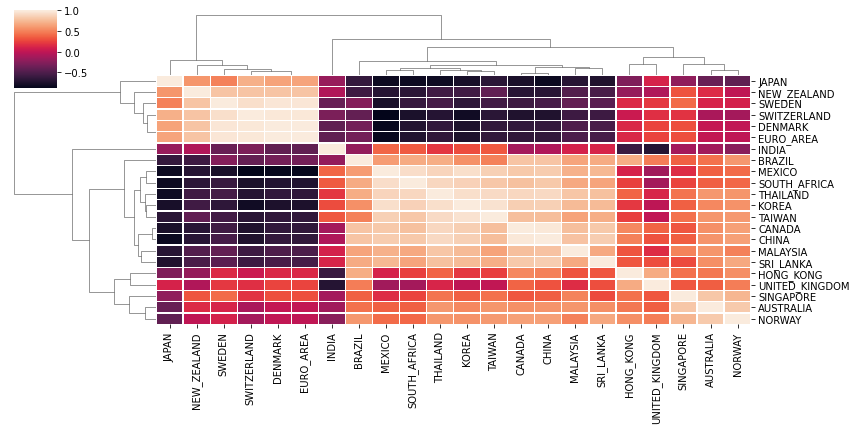

In [ ]:
corr = data_graph.corr()
fig = sns.clustermap(corr, annot=False, annot_kws={"size": 10}, linewidths=.4, figsize=(12, 6))
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.show()

In [ ]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links

var1            var2     value
0         AUSTRALIA       AUSTRALIA  1.000000
1         AUSTRALIA          BRAZIL  0.442774
2         AUSTRALIA          CANADA  0.574069
3         AUSTRALIA           CHINA  0.586433
4         AUSTRALIA         DENMARK  0.027006
..              ...             ...       ...
479  UNITED_KINGDOM          SWEDEN  0.218023
480  UNITED_KINGDOM     SWITZERLAND  0.180393
481  UNITED_KINGDOM          TAIWAN  0.011437
482  UNITED_KINGDOM        THAILAND  0.130526
483  UNITED_KINGDOM  UNITED_KINGDOM  1.000000

[484 rows x 3 columns]

In [ ]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) >= 0.6) & (links['var1'] != links['var2']) ]

links_filtered

var1         var2     value
13        AUSTRALIA       NORWAY  0.836450
14        AUSTRALIA    SINGAPORE  0.817890
20        AUSTRALIA     THAILAND  0.600695
24           BRAZIL       CANADA  0.809141
25           BRAZIL        CHINA  0.807183
..              ...          ...       ...
456        THAILAND    SRI_LANKA  0.793165
458        THAILAND  SWITZERLAND -0.689005
459        THAILAND       TAIWAN  0.918775
468  UNITED_KINGDOM    HONG_KONG  0.689121
469  UNITED_KINGDOM        INDIA -0.686362

[208 rows x 3 columns]

In [ ]:
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr = True)
mapping = dict(zip(sorted(G), range(22)))
H = nx.relabel_nodes(G, mapping)

In [ ]:
data_node_name = pd.DataFrame()
data_node_name['country'] = np.array(sorted(G.nodes))
data_node_name['node_number'] = np.array(sorted(H.nodes))
data_node_name

country  node_number
0        AUSTRALIA            0
1           BRAZIL            1
2           CANADA            2
3            CHINA            3
4          DENMARK            4
5        EURO_AREA            5
6        HONG_KONG            6
7            INDIA            7
8            JAPAN            8
9            KOREA            9
10        MALAYSIA           10
11          MEXICO           11
12     NEW_ZEALAND           12
13          NORWAY           13
14       SINGAPORE           14
15    SOUTH_AFRICA           15
16       SRI_LANKA           16
17          SWEDEN           17
18     SWITZERLAND           18
19          TAIWAN           19
20        THAILAND           20
21  UNITED_KINGDOM           21

In [ ]:
G.nodes

NodeView(('AUSTRALIA', 'NORWAY', 'SINGAPORE', 'THAILAND', 'BRAZIL', 'CANADA', 'CHINA', 'HONG_KONG', 'JAPAN', 'MALAYSIA', 'MEXICO', 'SOUTH_AFRICA', 'SRI_LANKA', 'DENMARK', 'EURO_AREA', 'KOREA', 'NEW_ZEALAND', 'SWITZERLAND', 'TAIWAN', 'SWEDEN', 'UNITED_KINGDOM', 'INDIA'))

In [ ]:
H.nodes

NodeView((0, 13, 14, 20, 1, 2, 3, 6, 8, 10, 11, 15, 16, 4, 5, 9, 12, 18, 19, 17, 21, 7))

In [ ]:
#divide into 4 nodes for training, 6 nodes for validation, and 13 nodes for test
train_node = [2,12,14,15]
val_node = [0,3,5,8,20,21]
test_node = [1,4,6,7,9,10,11,13,16,17,18,19]

train_mask = torch.zeros(22, dtype=torch.bool)
val_mask = torch.zeros(22, dtype=torch.bool)
test_mask = torch.zeros(22, dtype=torch.bool)

for i in train_node:
  train_mask[i] = True

for i in val_node:
  val_mask[i] = True

for i in test_node:
  test_mask[i] = True

for i in train_node:
  print(H.degree[i])

15
8
2
14


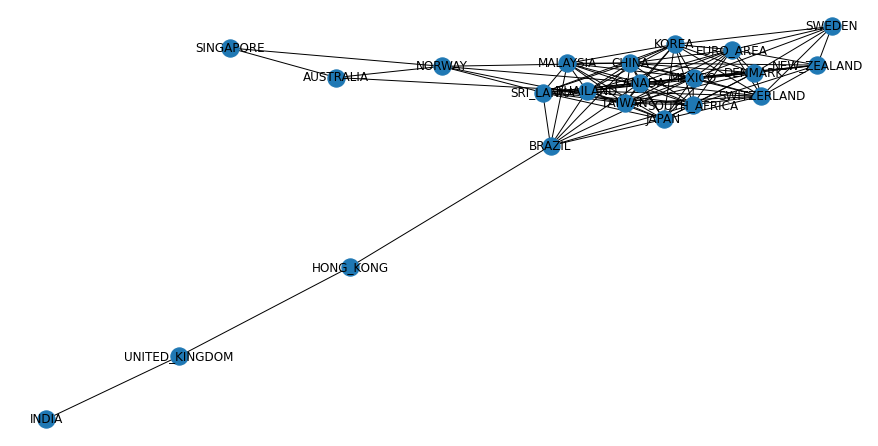

In [ ]:
plt.figure(figsize =(12, 6))
positions = nx.spring_layout(G, seed=15)
nx.draw(G, positions, with_labels=True)

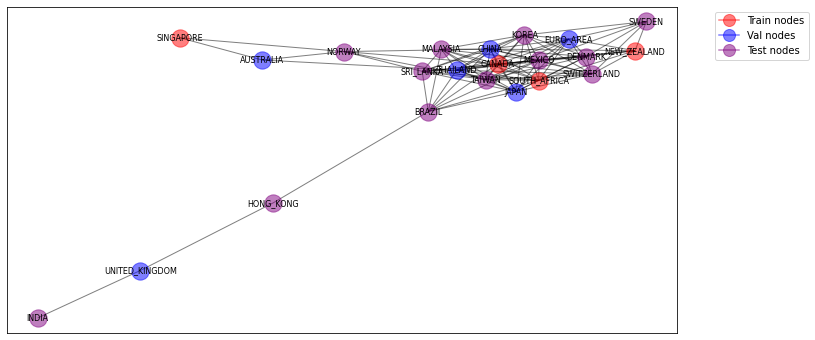

In [ ]:
plt.figure(figsize =(12, 6))

# define a graph, some nodes with a "Type" attribute, some without.

G1 = nx.Graph()
G1.add_nodes_from(data_node_name.loc[train_node].country.values, Type='TRAIN')
G1.add_nodes_from(data_node_name.loc[val_node].country.values, Type='VAL')
G1.add_nodes_from(data_node_name.loc[test_node].country.values, Type = 'TEST')
G1.add_edges_from(np.array(G.edges))

# extract nodes with specific setting of the attribute
train_nodes = [n for (n,ty) in \
    nx.get_node_attributes(G1,'Type').items() if ty == 'TRAIN']
val_nodes = [n for (n,ty) in \
    nx.get_node_attributes(G1,'Type').items() if ty == 'VAL']
# and find all the remaining nodes.
test_nodes = [n for (n,ty) in \
    nx.get_node_attributes(G1,'Type').items() if ty == 'TEST']

# now draw them in subsets  using the `nodelist` arg
#random_pos = nx.random_layout(G1, seed=42)
#pos = nx.spring_layout(G1, positions, fixed=node_pose.keys())
nx.draw_networkx_nodes(G1, positions, nodelist=train_nodes, \
    node_color='red', node_shape='o', alpha = 0.5)
nx.draw_networkx_nodes(G1, positions, nodelist=val_nodes, \
    node_color='blue', node_shape='o', alpha = 0.5)
nx.draw_networkx_nodes(G1, positions, nodelist=test_nodes, \
    node_color='purple', node_shape='o', alpha = 0.5)
nx.draw_networkx_edges(G1, positions, alpha=0.5)
nx.draw_networkx_labels(G1,positions, font_size=8)

train_legend = mlines.Line2D([], [], color='red', marker='o', alpha=0.5,
                          markersize=12, label='Train nodes')
val_legend = mlines.Line2D([], [], color='blue', marker='o', alpha=0.5,
                          markersize=12, label='Val nodes')
test_legend = mlines.Line2D([], [], color='purple', marker='o', alpha=0.5,
                          markersize=12, label='Test nodes')
plt.legend(handles=[train_legend, val_legend, test_legend], bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
data_node_name

country  node_number
0        AUSTRALIA            0
1           BRAZIL            1
2           CANADA            2
3            CHINA            3
4          DENMARK            4
5        EURO_AREA            5
6        HONG_KONG            6
7            INDIA            7
8            JAPAN            8
9            KOREA            9
10        MALAYSIA           10
11          MEXICO           11
12     NEW_ZEALAND           12
13          NORWAY           13
14       SINGAPORE           14
15    SOUTH_AFRICA           15
16       SRI_LANKA           16
17          SWEDEN           17
18     SWITZERLAND           18
19          TAIWAN           19
20        THAILAND           20
21  UNITED_KINGDOM           21

In [ ]:
edge_row1 = np.append(np.array([edge for edge in H.edges()]).T[0], np.array([edge for edge in H.edges()]).T[1])
edge_row2 = np.append(np.array([edge for edge in H.edges()]).T[1], np.array([edge for edge in H.edges()]).T[0])
edge = np.append([edge_row1], [edge_row2], axis=0)
edge_index = torch.LongTensor(edge)
edge_index

tensor([[ 0,  0,  0, 13, 13, 13, 13, 13, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  8,
          8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 15, 15, 15, 15, 15, 15, 15, 16, 16,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  9,  9,  9, 12, 12, 18, 18, 21, 13, 14, 20,  2,
          3, 14, 16, 19,  1,  2,  3,  4,  5,  8,  9, 10, 11, 15, 16, 18, 19,  2,
          3,  6,  8, 10, 11, 15, 16,  3,  4,  5,  8,  9, 10, 11, 12, 15, 16, 18,
         19,  4,  5,  8,  9, 10, 11, 12, 15, 16, 18, 19, 21,  4,  5,  9, 10, 11,
         15, 16, 18, 19,  9, 11, 15, 16, 19,  4,  5,  9, 12, 15, 16, 17, 18, 19,
          4,  5,  9, 12, 16, 18, 19,  9, 19,  5,  9, 12, 17, 18, 19,  9, 12, 17,
         18, 19, 17, 18, 19, 17, 18, 17, 19,  7],
        [13, 14, 20,  2,  3, 14, 16, 19,  1,  2,  3,  4,  5

In [ ]:
edge_index.shape

torch.Size([2, 208])

In [ ]:
edge_weight = []
for e in H.edges:
  w = H[e[0]][e[1]]['value']
  edge_weight.append(w)
edge_weight = np.stack(edge_weight)
edge_weight = np.append([edge_weight], [edge_weight])
edge_weight = torch.from_numpy((np.array(edge_weight)).astype(np.float32))
edge_weight.shape

torch.Size([208])

In [ ]:
links_filtered=links.loc[ (abs(links['value']) >= 0.9) ]#& (links['var1'] != links['var2']) ]

links_filtered

var1            var2     value
0         AUSTRALIA       AUSTRALIA  1.000000
23           BRAZIL          BRAZIL  1.000000
46           CANADA          CANADA  1.000000
47           CANADA           CHINA  0.984128
68            CHINA          CANADA  0.984128
69            CHINA           CHINA  1.000000
86            CHINA        THAILAND  0.905933
92          DENMARK         DENMARK  1.000000
93          DENMARK       EURO_AREA  0.999970
105         DENMARK          SWEDEN  0.973460
106         DENMARK     SWITZERLAND  0.978190
114       EURO_AREA         DENMARK  0.999970
115       EURO_AREA       EURO_AREA  1.000000
127       EURO_AREA          SWEDEN  0.972694
128       EURO_AREA     SWITZERLAND  0.978736
138       HONG_KONG       HONG_KONG  1.000000
161           INDIA           INDIA  1.000000
184           JAPAN           JAPAN  1.000000
207           KOREA           KOREA  1.000000
209           KOREA          MEXICO  0.937954
217           KOREA          TAIWAN  0.950981
218           KOREA        THAILAND  0.935821
230        MALAYSIA        MALAYSIA  1.000000
251          MEXICO           KOREA  0.937954
253          MEXICO          MEXICO  1.000000
257          MEXICO    SOUTH_AFRICA  0.928090
276     NEW_ZEALAND     NEW_ZEALAND  1.000000
299          NORWAY          NORWAY  1.000000
322       SINGAPORE       SINGAPORE  1.000000
341    SOUTH_AFRICA          MEXICO  0.928090
345    SOUTH_AFRICA    SOUTH_AFRICA  1.000000
350    SOUTH_AFRICA        THAILAND  0.904042
368       SRI_LANKA       SRI_LANKA  1.000000
378          SWEDEN         DENMARK  0.973460
379          SWEDEN       EURO_AREA  0.972694
391          SWEDEN          SWEDEN  1.000000
392          SWEDEN     SWITZERLAND  0.934734
400     SWITZERLAND         DENMARK  0.978190
401     SWITZERLAND       EURO_AREA  0.978736
413     SWITZERLAND          SWEDEN  0.934734
414     SWITZERLAND     SWITZERLAND  1.000000
427          TAIWAN           KOREA  0.950981
437          TAIWAN          TAIWAN  1.000000
438          TAIWAN        THAILAND  0.918775
443        THAILAND           CHINA  0.905933
449        THAILAND           KOREA  0.935821
455        THAILAND    SOUTH_AFRICA  0.904042
459        THAILAND          TAIWAN  0.918775
460        THAILAND        THAILAND  1.000000
483  UNITED_KINGDOM  UNITED_KINGDOM  1.000000

In [ ]:
G3 = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr = True)
mapping = dict(zip(sorted(G3), range(22)))
H3 = nx.relabel_nodes(G3, mapping)

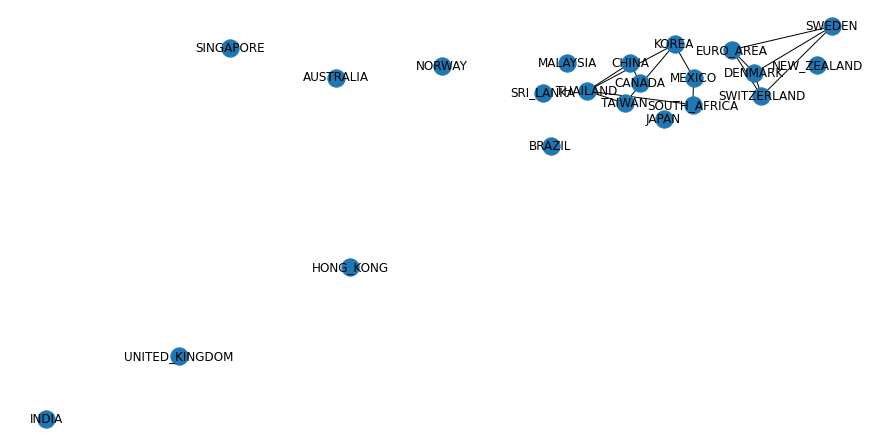

In [ ]:
plt.figure(figsize =(12, 6))
nx.draw(G3, positions, with_labels=True)

# Create features


In [ ]:
#create node features with 3 lags
#create univaritae time series forecasting with lag 3
def create_inout_sequences(input_data, window):
    x = []
    y = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        x.append(train_seq)
        y.append(train_label)
    return x, y

In [ ]:
data_train

AUSTRALIA  BRAZIL  ...  THAILAND_label  UNITED_KINGDOM_label
date                           ...                                      
2015-11-23     1.3912  3.7239  ...               0                     1
2015-11-24     1.3810  3.7064  ...               0                     0
2015-11-25     1.3801  3.7508  ...               0                     0
2015-11-26     1.3801  3.7508  ...               1                     1
2015-11-27     1.3904  3.7736  ...               0                     0
...               ...     ...  ...             ...                   ...
2018-08-14     1.3812  3.8852  ...               1                     1
2018-08-15     1.3826  3.9135  ...               0                     0
2018-08-16     1.3744  3.8985  ...               1                     0
2018-08-17     1.3732  3.9385  ...               0                     0
2018-08-18     1.3732  3.9385  ...               0                     0

[1000 rows x 44 columns]

In [ ]:
data_label = data_train.iloc[:, 22:]
data_value = data_train.iloc[:, :22]
data_value[:30]

AUSTRALIA  BRAZIL  CANADA  ...  TAIWAN  THAILAND  UNITED_KINGDOM
date                                   ...                                  
2015-11-23     1.3912  3.7239  1.3358  ...   32.62     35.83          0.6612
2015-11-24     1.3810  3.7064  1.3308  ...   32.53     35.75          0.6641
2015-11-25     1.3801  3.7508  1.3298  ...   32.47     35.64          0.6619
2015-11-26     1.3801  3.7508  1.3298  ...   32.47     35.64          0.6619
2015-11-27     1.3904  3.7736  1.3360  ...   32.69     35.88          0.6649
2015-11-28     1.3904  3.7736  1.3360  ...   32.69     35.88          0.6649
2015-11-29     1.3904  3.7736  1.3360  ...   32.69     35.88          0.6649
2015-11-30     1.3822  3.8982  1.3332  ...   32.53     35.75          0.6647
2015-12-01     1.3661  3.8491  1.3372  ...   32.53     35.75          0.6634
2015-12-02     1.3682  3.8633  1.3357  ...   32.53     35.75          0.6699
2015-12-03     1.3680  3.7762  1.3393  ...   32.53     35.75          0.6628
2015-12-04     1.3613  3.7426  1.3364  ...   32.53     35.75          0.6623
2015-12-05     1.3613  3.7426  1.3364  ...   32.53     35.75          0.6623
2015-12-06     1.3613  3.7426  1.3364  ...   32.53     35.75          0.6623
2015-12-07     1.3759  3.7595  1.3508  ...   32.89     35.89          0.6633
2015-12-08     1.3868  3.8032  1.3594  ...   32.94     35.94          0.6667
2015-12-09     1.3881  3.7264  1.3595  ...   32.90     35.92          0.6593
2015-12-10     1.3701  3.7787  1.3598  ...   32.74     36.03          0.6589
2015-12-11     1.3862  3.8791  1.3695  ...   33.01     36.15          0.6573
2015-12-12     1.3862  3.8791  1.3695  ...   33.01     36.15          0.6573
2015-12-13     1.3862  3.8791  1.3695  ...   33.01     36.15          0.6573
2015-12-14     1.3778  3.8972  1.3732  ...   32.90     36.09          0.6609
2015-12-15     1.3935  3.9000  1.3729  ...   32.75     36.01          0.6647
2015-12-16     1.3875  3.9421  1.3805  ...   32.70     35.97          0.6661
2015-12-17     1.4085  3.9053  1.3970  ...   33.00     36.17          0.6722
2015-12-18     1.3895  3.9336  1.3876  ...   32.85     36.08          0.6705
2015-12-19     1.3895  3.9336  1.3876  ...   32.85     36.08          0.6705
2015-12-20     1.3895  3.9336  1.3876  ...   32.85     36.08          0.6705
2015-12-21     1.3943  4.0231  1.3989  ...   32.87     36.15          0.6709
2015-12-22     1.3829  3.9980  1.3929  ...   32.79     36.08          0.6752

[30 rows x 22 columns]

In [ ]:
import pandas as pd
from sklearn import preprocessing
x = data_value.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
data_value_scaled = pd.DataFrame(x_scaled, columns = data_value.columns, index=data_value.index)

In [ ]:
def create_in_sequences(input_data, window):
    x = []
    #y = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        #train_label = output_data[i+window:i+window+1]
        x.append(train_seq)
        #y.append(train_label)
    return x
def create_out_sequences(output_data, window):
  y = []
  L = len(output_data)
  for i in range(L-window):
    train_label = output_data[i+window:i+window+1]
    y.append(train_label)
    return y

In [ ]:
#create train features based on actual values
window = 29
for i in data_value_scaled:
  globals()['train_seq_%s' %i] = create_in_sequences(data_value_scaled[i].values, window)
#create list of features
features = []
for i in data_value_scaled:
  f = globals()['train_seq_%s' %i][0]
  features.append(f)
features = np.stack(features)
features = torch.from_numpy((np.array(features)).astype(np.float32))

In [ ]:
features[0]

tensor([1.6309, 1.3841, 1.3623, 1.3623, 1.6115, 1.6115, 1.6115, 1.4131, 1.0236,
        1.0744, 1.0695, 0.9074, 0.9074, 0.9074, 1.2607, 1.5244, 1.5559, 1.1203,
        1.5099, 1.5099, 1.5099, 1.3067, 1.6865, 1.5414, 2.0495, 1.5898, 1.5898,
        1.5898, 1.7059])

In [ ]:
data_value_scaled[:30]

AUSTRALIA    BRAZIL    CANADA  ...    TAIWAN  THAILAND  UNITED_KINGDOM
date                                       ...                                    
2015-11-23   1.630897  1.185868  0.668244  ...  1.328369  1.213367       -2.134586
2015-11-24   1.384088  1.121956  0.550104  ...  1.253685  1.158360       -2.064683
2015-11-25   1.362311  1.284111  0.526475  ...  1.203896  1.082725       -2.117713
2015-11-26   1.362311  1.284111  0.526475  ...  1.203896  1.082725       -2.117713
2015-11-27   1.611539  1.367380  0.672970  ...  1.386456  1.247746       -2.045400
2015-11-28   1.611539  1.367380  0.672970  ...  1.386456  1.247746       -2.045400
2015-11-29   1.611539  1.367380  0.672970  ...  1.386456  1.247746       -2.045400
2015-11-30   1.413125  1.822437  0.606811  ...  1.253685  1.158360       -2.050221
2015-12-01   1.023554  1.643117  0.701324  ...  1.253685  1.158360       -2.081556
2015-12-02   1.074368  1.694977  0.665882  ...  1.253685  1.158360       -1.924879
2015-12-03   1.069528  1.376875  0.750943  ...  1.253685  1.158360       -2.096019
2015-12-04   0.907409  1.254163  0.682421  ...  1.253685  1.158360       -2.108071
2015-12-05   0.907409  1.254163  0.682421  ...  1.253685  1.158360       -2.108071
2015-12-06   0.907409  1.254163  0.682421  ...  1.253685  1.158360       -2.108071
2015-12-07   1.260684  1.315885  1.022667  ...  1.552419  1.254622       -2.083967
2015-12-08   1.524430  1.475483  1.225869  ...  1.593910  1.289002       -2.002012
2015-12-09   1.555886  1.194998  1.228232  ...  1.560717  1.275250       -2.180384
2015-12-10   1.120342  1.386006  1.235320  ...  1.427947  1.350885       -2.190025
2015-12-11   1.509912  1.752681  1.464513  ...  1.651997  1.433395       -2.228592
2015-12-12   1.509912  1.752681  1.464513  ...  1.651997  1.433395       -2.228592
2015-12-13   1.509912  1.752681  1.464513  ...  1.651997  1.433395       -2.228592
2015-12-14   1.306658  1.818785  1.551937  ...  1.560717  1.392140       -2.141817
2015-12-15   1.686550  1.829011  1.544849  ...  1.436245  1.337133       -2.050221
2015-12-16   1.541368  1.982766  1.724423  ...  1.394754  1.309629       -2.016475
2015-12-17   2.049504  1.848367  2.114287  ...  1.643699  1.447147       -1.869439
2015-12-18   1.589762  1.951723  1.892183  ...  1.519226  1.385264       -1.910416
2015-12-19   1.589762  1.951723  1.892183  ...  1.519226  1.385264       -1.910416
2015-12-20   1.589762  1.951723  1.892183  ...  1.519226  1.385264       -1.910416
2015-12-21   1.705907  2.278590  2.159181  ...  1.535823  1.433395       -1.900774
2015-12-22   1.430062  2.186921  2.017412  ...  1.469437  1.385264       -1.797126

[30 rows x 22 columns]

In [ ]:
features.shape

torch.Size([22, 29])

In [ ]:
#create train features based on actual values
window = 29
for i in data_label:
  globals()['train_seq_%s' %i] = create_in_sequences(data_label[i].values, window)
#create list of features
features1 = []
for i in data_label:
  f = globals()['train_seq_%s' %i][0]
  features1.append(f)
features1 = np.stack(features1)
features1 = torch.from_numpy((np.array(features1)).astype(np.float32))


In [ ]:
features1

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
         0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
         0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.

In [ ]:
features1.shape

torch.Size([22, 29])

In [ ]:
features1[0]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.])

In [ ]:
#create train features and targets for graph snapshots: each node with 29 features (29 lags)
window = 29
for i in data_label:
  globals()['train_target_%s' %i] = create_out_sequences(data_label[i].values, window)

#create list of targets:
targets = []
for i in data_label:
  t = globals()['train_target_%s' %i][0]
  targets.append(t)
targets = np.stack(targets)
targets = torch.LongTensor(targets)
targets = targets.view(-1)

In [ ]:
data_label[:30]

AUSTRALIA_label  BRAZIL_label  ...  THAILAND_label  UNITED_KINGDOM_label
date                                       ...                                      
2015-11-23                0             0  ...               0                     1
2015-11-24                0             1  ...               0                     0
2015-11-25                0             0  ...               0                     0
2015-11-26                1             1  ...               1                     1
2015-11-27                0             0  ...               0                     0
2015-11-28                0             0  ...               0                     0
2015-11-29                0             1  ...               0                     0
2015-11-30                0             0  ...               0                     0
2015-12-01                1             1  ...               0                     1
2015-12-02                0             0  ...               0                     0
2015-12-03                0             0  ...               0                     0
2015-12-04                0             0  ...               0                     0
2015-12-05                0             0  ...               0                     0
2015-12-06                1             1  ...               1                     1
2015-12-07                1             1  ...               1                     1
2015-12-08                1             0  ...               0                     0
2015-12-09                0             1  ...               1                     0
2015-12-10                1             1  ...               1                     0
2015-12-11                0             0  ...               0                     0
2015-12-12                0             0  ...               0                     0
2015-12-13                0             1  ...               0                     1
2015-12-14                1             1  ...               0                     1
2015-12-15                0             1  ...               0                     1
2015-12-16                1             0  ...               1                     1
2015-12-17                0             1  ...               0                     0
2015-12-18                0             0  ...               0                     0
2015-12-19                0             0  ...               0                     0
2015-12-20                1             1  ...               1                     1
2015-12-21                0             0  ...               0                     1
2015-12-22                1             0  ...               0                     0

[30 rows x 22 columns]

In [ ]:
targets

tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0])

In [ ]:
#divide into 4 nodes for training, 6 nodes for validation, and 13 nodes for test
train_node = [2,12,14,15]
val_node = [0,3,5,8,20,21]
test_node = [1,4,6,7,9,10,11,13,16,17,18,19]

train_mask = torch.zeros(22, dtype=torch.bool)
val_mask = torch.zeros(22, dtype=torch.bool)
test_mask = torch.zeros(22, dtype=torch.bool)

for i in train_node:
  train_mask[i] = True

for i in val_node:
  val_mask[i] = True

for i in test_node:
  test_mask[i] = True

for i in train_node:
  print(H.degree[i])

15
8
2
14


# Training GCN with corr >=0.6 

In [ ]:
links_self_loop = links.loc[ (links['var1'] == links['var2']) ]
links_self_loop = links_self_loop.reset_index()
links_self_loop

index            var1            var2  value
0       0       AUSTRALIA       AUSTRALIA    1.0
1      23          BRAZIL          BRAZIL    1.0
2      46          CANADA          CANADA    1.0
3      69           CHINA           CHINA    1.0
4      92         DENMARK         DENMARK    1.0
5     115       EURO_AREA       EURO_AREA    1.0
6     138       HONG_KONG       HONG_KONG    1.0
7     161           INDIA           INDIA    1.0
8     184           JAPAN           JAPAN    1.0
9     207           KOREA           KOREA    1.0
10    230        MALAYSIA        MALAYSIA    1.0
11    253          MEXICO          MEXICO    1.0
12    276     NEW_ZEALAND     NEW_ZEALAND    1.0
13    299          NORWAY          NORWAY    1.0
14    322       SINGAPORE       SINGAPORE    1.0
15    345    SOUTH_AFRICA    SOUTH_AFRICA    1.0
16    368       SRI_LANKA       SRI_LANKA    1.0
17    391          SWEDEN          SWEDEN    1.0
18    414     SWITZERLAND     SWITZERLAND    1.0
19    437          TAIWAN          TAIWAN    1.0
20    460        THAILAND        THAILAND    1.0
21    483  UNITED_KINGDOM  UNITED_KINGDOM    1.0

In [ ]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) >= 0.6) & (links['var1'] != links['var2']) ]
links_filtered = links_filtered.reset_index()
links_filtered = pd.concat([links_filtered, links_self_loop])
links_filtered['weight'] = links_filtered['value'].abs()
links_filtered

index            var1            var2     value    weight
0      13       AUSTRALIA          NORWAY  0.836450  0.836450
1      14       AUSTRALIA       SINGAPORE  0.817890  0.817890
2      20       AUSTRALIA        THAILAND  0.600695  0.600695
3      24          BRAZIL          CANADA  0.809141  0.809141
4      25          BRAZIL           CHINA  0.807183  0.807183
..    ...             ...             ...       ...       ...
17    391          SWEDEN          SWEDEN  1.000000  1.000000
18    414     SWITZERLAND     SWITZERLAND  1.000000  1.000000
19    437          TAIWAN          TAIWAN  1.000000  1.000000
20    460        THAILAND        THAILAND  1.000000  1.000000
21    483  UNITED_KINGDOM  UNITED_KINGDOM  1.000000  1.000000

[230 rows x 5 columns]

In [ ]:
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr = True)
mapping = dict(zip(sorted(G), range(22)))
H = nx.relabel_nodes(G, mapping)
H.remove_edges_from(nx.selfloop_edges(H))



In [ ]:
edge_weight = []
for e in H.edges:
  w = H[e[0]][e[1]]['weight']
  edge_weight.append(w)
edge_weight = np.stack(edge_weight)
edge_weight = np.append([edge_weight], [edge_weight])
edge_weight = torch.from_numpy((np.array(edge_weight)).astype(np.float32))
edge_weight.shape

torch.Size([208])

In [ ]:
sorted(G)

['AUSTRALIA',
 'BRAZIL',
 'CANADA',
 'CHINA',
 'DENMARK',
 'EURO_AREA',
 'HONG_KONG',
 'INDIA',
 'JAPAN',
 'KOREA',
 'MALAYSIA',
 'MEXICO',
 'NEW_ZEALAND',
 'NORWAY',
 'SINGAPORE',
 'SOUTH_AFRICA',
 'SRI_LANKA',
 'SWEDEN',
 'SWITZERLAND',
 'TAIWAN',
 'THAILAND',
 'UNITED_KINGDOM']

In [ ]:
G.nodes

NodeView(('AUSTRALIA', 'NORWAY', 'SINGAPORE', 'THAILAND', 'BRAZIL', 'CANADA', 'CHINA', 'HONG_KONG', 'JAPAN', 'MALAYSIA', 'MEXICO', 'SOUTH_AFRICA', 'SRI_LANKA', 'DENMARK', 'EURO_AREA', 'KOREA', 'NEW_ZEALAND', 'SWITZERLAND', 'TAIWAN', 'SWEDEN', 'UNITED_KINGDOM', 'INDIA'))

In [ ]:
H.nodes

NodeView((0, 13, 14, 20, 1, 2, 3, 6, 8, 10, 11, 15, 16, 4, 5, 9, 12, 18, 19, 17, 21, 7))

In [ ]:
data_node_name

country  node_number
0        AUSTRALIA            0
1           BRAZIL            1
2           CANADA            2
3            CHINA            3
4          DENMARK            4
5        EURO_AREA            5
6        HONG_KONG            6
7            INDIA            7
8            JAPAN            8
9            KOREA            9
10        MALAYSIA           10
11          MEXICO           11
12     NEW_ZEALAND           12
13          NORWAY           13
14       SINGAPORE           14
15    SOUTH_AFRICA           15
16       SRI_LANKA           16
17          SWEDEN           17
18     SWITZERLAND           18
19          TAIWAN           19
20        THAILAND           20
21  UNITED_KINGDOM           21

In [ ]:
A = nx.adjacency_matrix(H,nodelist=sorted(H.nodes())).todense()

In [ ]:
H.edges

EdgeView([(0, 13), (0, 14), (0, 20), (13, 2), (13, 3), (13, 14), (13, 16), (13, 19), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 8), (20, 9), (20, 10), (20, 11), (20, 15), (20, 16), (20, 18), (20, 19), (1, 2), (1, 3), (1, 6), (1, 8), (1, 10), (1, 11), (1, 15), (1, 16), (2, 3), (2, 4), (2, 5), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 15), (2, 16), (2, 18), (2, 19), (3, 4), (3, 5), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 15), (3, 16), (3, 18), (3, 19), (6, 21), (8, 4), (8, 5), (8, 9), (8, 10), (8, 11), (8, 15), (8, 16), (8, 18), (8, 19), (10, 9), (10, 11), (10, 15), (10, 16), (10, 19), (11, 4), (11, 5), (11, 9), (11, 12), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (15, 4), (15, 5), (15, 9), (15, 12), (15, 16), (15, 18), (15, 19), (16, 9), (16, 19), (4, 5), (4, 9), (4, 12), (4, 17), (4, 18), (4, 19), (5, 9), (5, 12), (5, 17), (5, 18), (5, 19), (9, 17), (9, 18), (9, 19), (12, 17), (12, 18), (18, 17), (18, 19), (21, 7)])

In [ ]:
edge_row1 = np.append(np.array([edge for edge in H.edges()]).T[0], np.array([edge for edge in H.edges()]).T[1])
edge_row2 = np.append(np.array([edge for edge in H.edges()]).T[1], np.array([edge for edge in H.edges()]).T[0])
edge = np.append([edge_row1], [edge_row2], axis=0)
edge_index = torch.LongTensor(edge)
edge_index

tensor([[ 0,  0,  0, 13, 13, 13, 13, 13, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  8,
          8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 15, 15, 15, 15, 15, 15, 15, 16, 16,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  9,  9,  9, 12, 12, 18, 18, 21, 13, 14, 20,  2,
          3, 14, 16, 19,  1,  2,  3,  4,  5,  8,  9, 10, 11, 15, 16, 18, 19,  2,
          3,  6,  8, 10, 11, 15, 16,  3,  4,  5,  8,  9, 10, 11, 12, 15, 16, 18,
         19,  4,  5,  8,  9, 10, 11, 12, 15, 16, 18, 19, 21,  4,  5,  9, 10, 11,
         15, 16, 18, 19,  9, 11, 15, 16, 19,  4,  5,  9, 12, 15, 16, 17, 18, 19,
          4,  5,  9, 12, 16, 18, 19,  9, 19,  5,  9, 12, 17, 18, 19,  9, 12, 17,
         18, 19, 17, 18, 19, 17, 18, 17, 19,  7],
        [13, 14, 20,  2,  3, 14, 16, 19,  1,  2,  3,  4,  5

In [ ]:
G.edges

EdgeView([('AUSTRALIA', 'NORWAY'), ('AUSTRALIA', 'SINGAPORE'), ('AUSTRALIA', 'THAILAND'), ('AUSTRALIA', 'AUSTRALIA'), ('NORWAY', 'CANADA'), ('NORWAY', 'CHINA'), ('NORWAY', 'SINGAPORE'), ('NORWAY', 'SRI_LANKA'), ('NORWAY', 'TAIWAN'), ('NORWAY', 'NORWAY'), ('SINGAPORE', 'SINGAPORE'), ('THAILAND', 'BRAZIL'), ('THAILAND', 'CANADA'), ('THAILAND', 'CHINA'), ('THAILAND', 'DENMARK'), ('THAILAND', 'EURO_AREA'), ('THAILAND', 'JAPAN'), ('THAILAND', 'KOREA'), ('THAILAND', 'MALAYSIA'), ('THAILAND', 'MEXICO'), ('THAILAND', 'SOUTH_AFRICA'), ('THAILAND', 'SRI_LANKA'), ('THAILAND', 'SWITZERLAND'), ('THAILAND', 'TAIWAN'), ('THAILAND', 'THAILAND'), ('BRAZIL', 'CANADA'), ('BRAZIL', 'CHINA'), ('BRAZIL', 'HONG_KONG'), ('BRAZIL', 'JAPAN'), ('BRAZIL', 'MALAYSIA'), ('BRAZIL', 'MEXICO'), ('BRAZIL', 'SOUTH_AFRICA'), ('BRAZIL', 'SRI_LANKA'), ('BRAZIL', 'BRAZIL'), ('CANADA', 'CHINA'), ('CANADA', 'DENMARK'), ('CANADA', 'EURO_AREA'), ('CANADA', 'JAPAN'), ('CANADA', 'KOREA'), ('CANADA', 'MALAYSIA'), ('CANADA', 'MEXIC

In [ ]:
features1.size(0)

22

In [ ]:
data = Data(x=features, edge_index=edge_index, edge_weight = edge_weight, y=targets, train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 208], edge_weight=[208], test_mask=[22], train_mask=[22], val_mask=[22], x=[22, 29], y=[22])
Number of nodes: 22
Number of edges: 208
Average node degree: 9.45
Number of training nodes: 4
Training node label rate: 0.18
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(29, hidden_channels)#, add_self_loops=False)
        self.conv2 = GCNConv(hidden_channels, 2)#, add_self_loops=False)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)# edge_attr)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)# edge_attr)
        return x

model = GCN(hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(29, 32)
  (conv2): GCNConv(32, 2)
)


In [ ]:
model.conv1.bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [ ]:
model.conv2.bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [ ]:
#check manually
W1 = model.conv1.weight.detach().numpy()
W2 = model.conv2.weight.detach().numpy()

In [ ]:
#check manually 
I = np.matrix(np.eye(A.shape[0]))
A_hat = A.copy() + I
D_hat = np.array(np.sum(np.array(A_hat), axis=1))
D_hat = np.matrix(np.diag(D_hat))
A_prime = fractional_matrix_power(D_hat,-0.5) * A_hat * fractional_matrix_power(D_hat, -0.5)
#A_prime

In [ ]:
def gcn_layer(A, X, W):
    return (A * X * W)
def relu(X):
   return np.maximum(0,X)
H_1 = relu(gcn_layer(A_prime, np.array(data.x), W1))
H_2 = gcn_layer(A_prime, H_1, W2)
output = H_2

In [ ]:
output

matrix([[-0.09845995,  0.13356344],
        [-0.03090403,  0.14126977],
        [-0.08399002,  0.12351814],
        [-0.08519307,  0.12401854],
        [ 0.00378585,  0.12512561],
        [ 0.00355718,  0.1252574 ],
        [ 0.30004365,  0.32942176],
        [ 0.44612959,  0.33459403],
        [-0.07362854,  0.10984981],
        [-0.05546509,  0.12005849],
        [-0.09811155,  0.08791685],
        [-0.04871408,  0.12723025],
        [ 0.02714607,  0.10618003],
        [-0.11071688,  0.12486052],
        [-0.09409276,  0.1340855 ],
        [-0.06639207,  0.11859598],
        [-0.11084336,  0.09782928],
        [ 0.04904765,  0.10072384],
        [-0.00081297,  0.12715122],
        [-0.08027575,  0.1175945 ],
        [-0.08888148,  0.12691694],
        [ 0.49359513,  0.42712339]])

In [ ]:
model(data.x, data.edge_index, data.edge_weight)

tensor([[-0.0985,  0.1336],
        [-0.0309,  0.1413],
        [-0.0840,  0.1235],
        [-0.0852,  0.1240],
        [ 0.0038,  0.1251],
        [ 0.0036,  0.1253],
        [ 0.3000,  0.3294],
        [ 0.4461,  0.3346],
        [-0.0736,  0.1098],
        [-0.0555,  0.1201],
        [-0.0981,  0.0879],
        [-0.0487,  0.1272],
        [ 0.0271,  0.1062],
        [-0.1107,  0.1249],
        [-0.0941,  0.1341],
        [-0.0664,  0.1186],
        [-0.1108,  0.0978],
        [ 0.0490,  0.1007],
        [-0.0008,  0.1272],
        [-0.0803,  0.1176],
        [-0.0889,  0.1269],
        [ 0.4936,  0.4271]], grad_fn=<AddBackward0>)

In [ ]:
#an example
torch.manual_seed(12)
criterion_ex = torch.nn.CrossEntropyLoss()
input_ex = torch.randn(4, 5, requires_grad=True)
target_ex = torch.empty(4, dtype=torch.long).random_(5)
loss_ex = criterion_ex(input_ex, target_ex)

In [ ]:
input_ex

tensor([[-0.1320, -0.1254,  0.3443, -0.4519, -1.2945],
        [-0.2623, -0.5353,  1.3466, -0.6958, -0.0522],
        [-0.0351,  0.5274, -0.6944, -0.2125,  0.2362],
        [-1.2438,  1.4400,  0.7946,  0.8444,  1.2668]], requires_grad=True)

In [ ]:
target_ex

tensor([3, 0, 2, 2])

In [ ]:
loss_ex

tensor(2.0258, grad_fn=<NllLossBackward>)

In [ ]:
torch.exp(input_ex)/torch.sum(torch.exp(input_ex), dim=1).view(4, -1)

tensor([[0.2148, 0.2162, 0.3458, 0.1560, 0.0672],
        [0.1157, 0.0881, 0.5784, 0.0750, 0.1428],
        [0.1845, 0.3237, 0.0954, 0.1545, 0.2419],
        [0.0229, 0.3350, 0.1757, 0.1847, 0.2817]], grad_fn=<DivBackward0>)

In [ ]:
torch.sum(torch.exp(input_ex), dim=1).view(4, -1)

tensor([[ 4.0799],
        [ 6.6470],
        [ 5.2343],
        [12.5986]], grad_fn=<ViewBackward>)

In [ ]:
-(np.log(0.1560) + np.log(0.1157) + np.log(0.0954) + np.log(0.1757))/4

2.025826975208022

In [ ]:
m = torch.nn.Softmax(dim=1)
m(input_ex)

tensor([[0.2148, 0.2162, 0.3458, 0.1560, 0.0672],
        [0.1157, 0.0881, 0.5784, 0.0750, 0.1428],
        [0.1845, 0.3237, 0.0954, 0.1545, 0.2419],
        [0.0229, 0.3350, 0.1757, 0.1847, 0.2817]], grad_fn=<SoftmaxBackward>)

In [ ]:
#our model
out = model(data.x, data.edge_index, data.edge_weight)
out[data.train_mask]

tensor([[-0.0840,  0.1235],
        [ 0.0271,  0.1062],
        [-0.0941,  0.1341],
        [-0.0664,  0.1186]], grad_fn=<IndexBackward>)

In [ ]:
np.exp(0.2473)/(np.exp(0.2473)+np.exp(-0.3397))

0.6426765107271206

In [ ]:
#rescaling them so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.
torch.exp(out[data.train_mask])/torch.sum(torch.exp(out[data.train_mask]), dim=1).view(4, -1)

tensor([[0.4483, 0.5517],
        [0.4803, 0.5197],
        [0.4432, 0.5568],
        [0.4539, 0.5461]], grad_fn=<DivBackward0>)

In [ ]:
#loss(x, class0)
-np.log(0.6427)

0.44207722660489646

In [ ]:
data.y[data.train_mask]

tensor([0, 1, 1, 0])

In [ ]:
m = torch.nn.Softmax(dim=1)
m(out[data.train_mask])

tensor([[0.4483, 0.5517],
        [0.4803, 0.5197],
        [0.4432, 0.5568],
        [0.4539, 0.5461]], grad_fn=<SoftmaxBackward>)

In [ ]:
-(np.log(0.4483) + np.log(0.5197) + np.log(0.5568) + np.log(0.4539))/4

0.7080559310675321

In [ ]:
data.y[data.train_mask]

tensor([0, 1, 1, 0])

In [ ]:
pred = out.argmax(dim=1)
pred[data.train_mask]

tensor([1, 1, 1, 1])

In [ ]:
criterion = torch.nn.CrossEntropyLoss() 
criterion(out[data.train_mask], data.y[data.train_mask])


tensor(0.7080, grad_fn=<NllLossBackward>)

In [ ]:
import timeit

start = timeit.default_timer()

#Your statements here
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(32)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=5e-4)  # Define optimizer.
es = EarlyStopping(patience=10)

def train():
      model.train()   # setting the model to train mode
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def val ():
  with torch.no_grad():
      model.eval()
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
      return val_loss

def test():
      with torch.no_grad():   #Turn off gradients.
        model.eval()   # set model to evaluation mode
        out = model(data.x, data.edge_index, data.edge_weight)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        return test_acc

losses, val_losses = [], []
val_loss = 1000000
for epoch in range(1, 2000):
    loss = train()
    val_loss = val()
    losses.append(loss)
    val_losses.append(val_loss)
    if es.step(val_loss):
        break 
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
    #metric = eval(model, data_loader_dev)  # evalution on dev set (i.e., holdout from training)

stop = timeit.default_timer()

print('Time: ', stop - start)
    

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7080, Val Loss: 0.7069
Epoch: 002, Train Loss: 0.7058, Val Loss: 0.7022
Epoch: 003, Train Loss: 0.7039, Val Loss: 0.6989
Epoch: 004, Train Loss: 0.7021, Val Loss: 0.6963
Epoch: 005, Train Loss: 0.7000, Val Loss: 0.6947
Epoch: 006, Train Loss: 0.6984, Val Loss: 0.6939
Epoch: 007, Train Loss: 0.6969, Val Loss: 0.6935
Epoch: 008, Train Loss: 0.6954, Val Loss: 0.6935
Epoch: 009, Train Loss: 0.6938, Val Loss: 0.6937
Epoch: 010, Train Loss: 0.6924, Val Loss: 0.6942
Epoch: 011, Train Loss: 0.6914, Val Loss: 0.6940
Epoch: 012, Train Loss: 0.6900, Val Loss: 0.6935
Epoch: 013, Train Loss: 0.6885, Val Loss: 0.6925
Epoch: 014, Train Loss: 0.6868, Val Loss: 0.6914
Epoch: 015, Train Loss: 0.6851, Val Loss: 0.6901
Epoch: 016, Train Loss: 0.6833, Val Loss: 0.6889
Epoch: 017, Train Loss: 0.6819, Val Loss: 0.6879
Epoch: 018, Train Loss: 0.6812, Val Loss: 0.6863
Epoch: 019, Train Loss: 0.6801, Val Loss: 0.6848
Epoch: 020, Train Loss: 0.6789, Val Loss: 0.6835
Epoch: 021, Train Lo

In [ ]:
val_loss

tensor(0.0038)

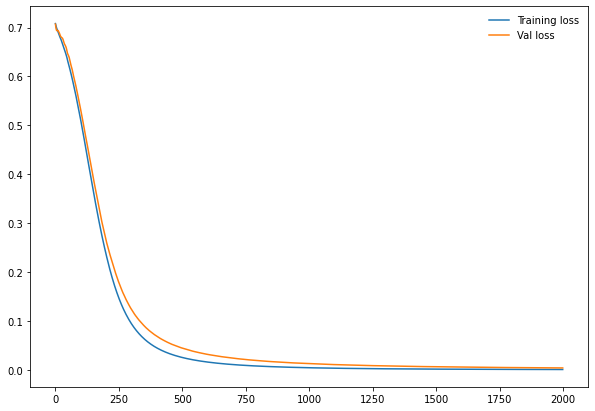

In [ ]:
plt.figure(figsize =(10, 7))
plt.plot(losses, label = "Training loss")
plt.plot(val_losses, label = "Val loss")
plt.legend(frameon=False)

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.5f}')

Test Accuracy: 0.66667


In [ ]:
model.eval()   # set model to evaluation mode
out = model(data.x, data.edge_index, data.edge_weight)
pred = out.argmax(dim=1)
print(pred[train_mask])
print(pred[val_mask])
print(pred[test_mask])

tensor([0, 1, 1, 0])
tensor([1, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])


In [ ]:
print(train_node)
print(val_node)
print(test_node)

[2, 12, 14, 15]
[0, 3, 5, 8, 20, 21]
[1, 4, 6, 7, 9, 10, 11, 13, 16, 17, 18, 19]


In [ ]:
print(targets[train_mask])
print(targets[val_mask])
print(targets[test_mask])

tensor([0, 1, 1, 0])
tensor([1, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1])


In [ ]:
data_node_name

country  node_number
0        AUSTRALIA            0
1           BRAZIL            1
2           CANADA            2
3            CHINA            3
4          DENMARK            4
5        EURO_AREA            5
6        HONG_KONG            6
7            INDIA            7
8            JAPAN            8
9            KOREA            9
10        MALAYSIA           10
11          MEXICO           11
12     NEW_ZEALAND           12
13          NORWAY           13
14       SINGAPORE           14
15    SOUTH_AFRICA           15
16       SRI_LANKA           16
17          SWEDEN           17
18     SWITZERLAND           18
19          TAIWAN           19
20        THAILAND           20
21  UNITED_KINGDOM           21

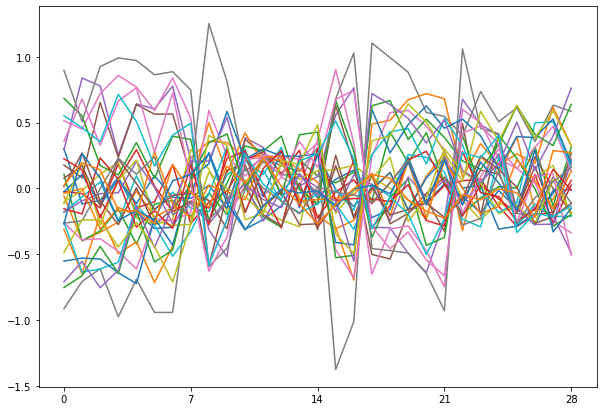

In [ ]:
plt.figure(figsize =(10, 7))
plt.plot(model.conv1.weight.detach().numpy())
#plt.title('model{0}'.format(i))
plt.xticks(np.arange(0, 30, 7))
plt.show()

[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 7, 9, 16, 17, 18] [10, 11, 13, 19]


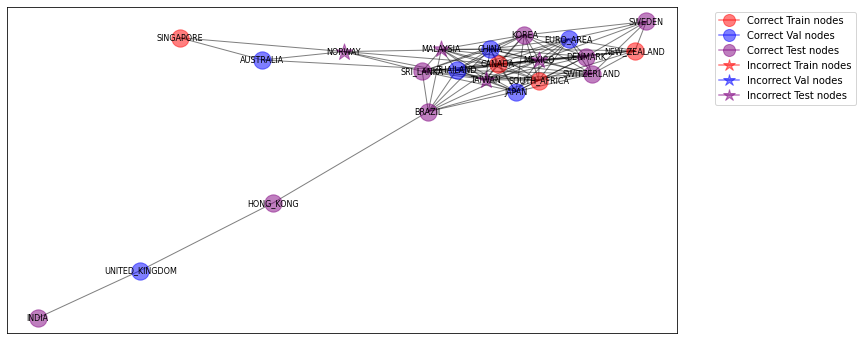

In [ ]:
classification_label(train_node,pred[train_mask],targets[train_mask],val_node,pred[val_mask],targets[val_mask], 
                         test_node,pred[test_mask],targets[test_mask], G)

# Training GCN with corr > 0.6 (use negative edgeweight)

In [ ]:
links_self_loop = links.loc[ (links['var1'] == links['var2']) ]
links_self_loop = links_self_loop.reset_index()
links_self_loop

index            var1            var2  value
0       0       AUSTRALIA       AUSTRALIA    1.0
1      23          BRAZIL          BRAZIL    1.0
2      46          CANADA          CANADA    1.0
3      69           CHINA           CHINA    1.0
4      92         DENMARK         DENMARK    1.0
5     115       EURO_AREA       EURO_AREA    1.0
6     138       HONG_KONG       HONG_KONG    1.0
7     161           INDIA           INDIA    1.0
8     184           JAPAN           JAPAN    1.0
9     207           KOREA           KOREA    1.0
10    230        MALAYSIA        MALAYSIA    1.0
11    253          MEXICO          MEXICO    1.0
12    276     NEW_ZEALAND     NEW_ZEALAND    1.0
13    299          NORWAY          NORWAY    1.0
14    322       SINGAPORE       SINGAPORE    1.0
15    345    SOUTH_AFRICA    SOUTH_AFRICA    1.0
16    368       SRI_LANKA       SRI_LANKA    1.0
17    391          SWEDEN          SWEDEN    1.0
18    414     SWITZERLAND     SWITZERLAND    1.0
19    437          TAIWAN          TAIWAN    1.0
20    460        THAILAND        THAILAND    1.0
21    483  UNITED_KINGDOM  UNITED_KINGDOM    1.0

In [ ]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) >= 0.6) & (links['var1'] != links['var2']) ]
links_filtered = links_filtered.reset_index()
links_filtered = pd.concat([links_filtered, links_self_loop])
links_filtered['weight'] = links_filtered['value']
links_filtered

index            var1            var2     value    weight
0      13       AUSTRALIA          NORWAY  0.836450  0.836450
1      14       AUSTRALIA       SINGAPORE  0.817890  0.817890
2      20       AUSTRALIA        THAILAND  0.600695  0.600695
3      24          BRAZIL          CANADA  0.809141  0.809141
4      25          BRAZIL           CHINA  0.807183  0.807183
..    ...             ...             ...       ...       ...
17    391          SWEDEN          SWEDEN  1.000000  1.000000
18    414     SWITZERLAND     SWITZERLAND  1.000000  1.000000
19    437          TAIWAN          TAIWAN  1.000000  1.000000
20    460        THAILAND        THAILAND  1.000000  1.000000
21    483  UNITED_KINGDOM  UNITED_KINGDOM  1.000000  1.000000

[230 rows x 5 columns]

In [ ]:
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr = True)
mapping = dict(zip(sorted(G), range(22)))
H = nx.relabel_nodes(G, mapping)
H.remove_edges_from(nx.selfloop_edges(H))

In [ ]:
edge_weight = []
for e in H.edges:
  w = H[e[0]][e[1]]['weight']
  edge_weight.append(w)
edge_weight = np.stack(edge_weight)
edge_weight = np.append([edge_weight], [edge_weight])
edge_weight = torch.from_numpy((np.array(edge_weight)).astype(np.float32))
edge_weight.shape

torch.Size([208])

In [ ]:
edge_index

tensor([[ 0,  0,  0, 13, 13, 13, 13, 13, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  8,
          8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 15, 15, 15, 15, 15, 15, 15, 16, 16,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  9,  9,  9, 12, 12, 18, 18, 21, 13, 14, 20,  2,
          3, 14, 16, 19,  1,  2,  3,  4,  5,  8,  9, 10, 11, 15, 16, 18, 19,  2,
          3,  6,  8, 10, 11, 15, 16,  3,  4,  5,  8,  9, 10, 11, 12, 15, 16, 18,
         19,  4,  5,  8,  9, 10, 11, 12, 15, 16, 18, 19, 21,  4,  5,  9, 10, 11,
         15, 16, 18, 19,  9, 11, 15, 16, 19,  4,  5,  9, 12, 15, 16, 17, 18, 19,
          4,  5,  9, 12, 16, 18, 19,  9, 19,  5,  9, 12, 17, 18, 19,  9, 12, 17,
         18, 19, 17, 18, 19, 17, 18, 17, 19,  7],
        [13, 14, 20,  2,  3, 14, 16, 19,  1,  2,  3,  4,  5

In [ ]:
data_node_name

country  node_number
0        AUSTRALIA            0
1           BRAZIL            1
2           CANADA            2
3            CHINA            3
4          DENMARK            4
5        EURO_AREA            5
6        HONG_KONG            6
7            INDIA            7
8            JAPAN            8
9            KOREA            9
10        MALAYSIA           10
11          MEXICO           11
12     NEW_ZEALAND           12
13          NORWAY           13
14       SINGAPORE           14
15    SOUTH_AFRICA           15
16       SRI_LANKA           16
17          SWEDEN           17
18     SWITZERLAND           18
19          TAIWAN           19
20        THAILAND           20
21  UNITED_KINGDOM           21

In [ ]:
edge_weight

tensor([ 0.8364,  0.8179,  0.6007,  0.6339,  0.6358,  0.7418,  0.6745,  0.6089,
         0.6935,  0.8976,  0.9059, -0.6329, -0.6366, -0.8027,  0.9358,  0.8136,
         0.8859,  0.9040,  0.7932, -0.6890,  0.9188,  0.8091,  0.8072,  0.6948,
        -0.6150,  0.6609,  0.6233,  0.6902,  0.6873,  0.9841, -0.6322, -0.6359,
        -0.7511,  0.8563,  0.7817,  0.8291, -0.6771,  0.7892,  0.8259, -0.7211,
         0.7846, -0.6236, -0.6276, -0.8199,  0.8626,  0.8004,  0.8460, -0.6706,
         0.8273,  0.8496, -0.7199,  0.7746,  0.6891,  0.6536,  0.6572, -0.7522,
        -0.6847, -0.8124, -0.8161, -0.7192,  0.7073, -0.6699,  0.7619,  0.7151,
         0.6833,  0.6778,  0.6483, -0.8432, -0.8456,  0.9380, -0.6911,  0.9281,
         0.7462, -0.7495, -0.8757,  0.8643, -0.7055, -0.7073,  0.8709, -0.6610,
         0.6577, -0.7402,  0.8204,  0.7614,  0.7063,  1.0000, -0.7319,  0.8052,
         0.9735,  0.9782, -0.6275, -0.7353,  0.8047,  0.9727,  0.9787, -0.6308,
        -0.6475, -0.7903,  0.9510,  0.80

In [ ]:
data = Data(x=features, edge_index=edge_index, y=targets,edge_weight=edge_weight, train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 208], edge_weight=[208], test_mask=[22], train_mask=[22], val_mask=[22], x=[22, 29], y=[22])
Number of nodes: 22
Number of edges: 208
Average node degree: 9.45
Number of training nodes: 4
Training node label rate: 0.18
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
A = nx.adjacency_matrix(H,nodelist=sorted(H.nodes())).todense()

In [ ]:
#use our code
edge_weight.shape

torch.Size([208])

In [ ]:
#weight
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv_edgeweight(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv_edgeweight, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index_self_loop, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        edge_weight_self_loop = torch.cat((edge_weight, torch.ones(data.x.size(0))), dim=0)

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        #print(x)

        # Step 3: Compute normalization.
        row, col = edge_index_self_loop
        #sum x_j with the index corresponding to the same target nodes in edge_index
        def duplicates(list, item):
          return [i for i, x in enumerate(list) if x == item]
        degree_weight = []
        for i in range(len(data.x)):
          sum = torch.sum(np.abs(edge_weight_self_loop)[duplicates(col, i)], dim=0)
          degree_weight.append(sum)
        degree_weight = torch.stack(degree_weight, dim =0)
        #print(degree_weight)
        row, col = edge_index_self_loop
        deg = degree_weight
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * np.abs(edge_weight_self_loop) * deg_inv_sqrt[col]
        
        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index_self_loop, x=x, norm=norm)

    def message(self, x_i, x_j, norm):
        # x_j has shape [E, out_channels]
        #global edge_weight
        edge_weight_self_loop = torch.cat((edge_weight, torch.ones(data.x.size(0))), dim=0)
        #print(edge_weight_self_loop.shape)
        x_j = x_i + torch.sign(edge_weight_self_loop).view(-1,1)*(x_j-x_i)
        #print(x_j)

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [ ]:
edge_weight.shape

torch.Size([208])

In [ ]:
# model output
conv = GCNConv_edgeweight(29, 2)
conv.lin.weight.data.fill_(0.01)
conv.lin.bias.data.fill_(0)
out_new = conv(data.x, edge_index, edge_weight)
print(out_new)

tensor([[ 0.3334,  0.3334],
        [ 0.0086,  0.0086],
        [ 0.1740,  0.1740],
        [-0.2380, -0.2380],
        [ 0.4238,  0.4238],
        [ 0.4106,  0.4106],
        [-0.2380, -0.2380],
        [ 0.3109,  0.3109],
        [ 1.0789,  1.0789],
        [ 0.0977,  0.0977],
        [ 0.0529,  0.0529],
        [-0.5887, -0.5887],
        [ 0.4482,  0.4482],
        [ 0.2174,  0.2174],
        [ 0.3218,  0.3218],
        [ 0.1081,  0.1081],
        [-0.0233, -0.0233],
        [ 0.2144,  0.2144],
        [ 0.4135,  0.4135],
        [ 0.1823,  0.1823],
        [ 0.1930,  0.1930],
        [-0.7882, -0.7882]], grad_fn=<ScatterAddBackward>)


In [ ]:
#define model with 2-layer
class GCNConv_edgeweight_two_layer(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2):
        super(GCNConv_edgeweight_two_layer, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv_edgeweight(29, hidden_channels1)
        self.conv2 = GCNConv_edgeweight(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv_edgeweight(hidden_channels2, 2)
        #self.conv4 = GCNConv_edgeweight(hidden_channels3, 2)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        #x = F.dropout(x, p=0.25, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

model = GCNConv_edgeweight_two_layer(64,16)
print(model)

GCNConv_edgeweight_two_layer(
  (conv1): GCNConv_edgeweight(
    (lin): Linear(in_features=29, out_features=64, bias=True)
  )
  (conv2): GCNConv_edgeweight(
    (lin): Linear(in_features=64, out_features=16, bias=True)
  )
  (conv3): GCNConv_edgeweight(
    (lin): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [ ]:
import timeit

start = timeit.default_timer()

#Your statements here

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCNConv_edgeweight_two_layer(32,16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #, weight_decay=5e-4)  # Define optimizer.
es = EarlyStopping(patience=10)

def train():
      model.train()   # setting the model to train mode
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def val ():
  with torch.no_grad():
      model.eval()
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
      return val_loss

def test():
      with torch.no_grad():   #Turn off gradients.
        model.eval()   # set model to evaluation mode
        out = model(data.x, data.edge_index, data.edge_weight)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        return test_acc

losses, val_losses = [], []
val_loss = 1000000
for epoch in range(1, 5000):
    loss = train()
    val_loss = val()
    losses.append(loss)
    val_losses.append(val_loss)
    if es.step(val_loss):
        break 
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
    #metric = eval(model, data_loader_dev)  # evalution on dev set (i.e., holdout from training)

stop = timeit.default_timer()

print('Time: ', stop - start)
    

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7470, Val Loss: 2.7082
Epoch: 002, Train Loss: 2.7433, Val Loss: 2.7043
Epoch: 003, Train Loss: 2.7397, Val Loss: 2.7004
Epoch: 004, Train Loss: 2.7360, Val Loss: 2.6966
Epoch: 005, Train Loss: 2.7323, Val Loss: 2.6927
Epoch: 006, Train Loss: 2.7287, Val Loss: 2.6889
Epoch: 007, Train Loss: 2.7250, Val Loss: 2.6851
Epoch: 008, Train Loss: 2.7213, Val Loss: 2.6812
Epoch: 009, Train Loss: 2.7176, Val Loss: 2.6774
Epoch: 010, Train Loss: 2.7139, Val Loss: 2.6735
Epoch: 011, Train Loss: 2.7102, Val Loss: 2.6697
Epoch: 012, Train Loss: 2.7065, Val Loss: 2.6657
Epoch: 013, Train Loss: 2.7027, Val Loss: 2.6617
Epoch: 014, Train Loss: 2.6989, Val Loss: 2.6577
Epoch: 015, Train Loss: 2.6950, Val Loss: 2.6537
Epoch: 016, Train Loss: 2.6912, Val Loss: 2.6497
Epoch: 017, Train Loss: 2.6874, Val Loss: 2.6457
Epoch: 018, Train Loss: 2.6836, Val Loss: 2.6417
Epoch: 019, Train Loss: 2.6798, Val Loss: 2.6377
Epoch: 020, Train Loss: 2.6759, Val Loss: 2.6338
Epoch: 021, Train Lo

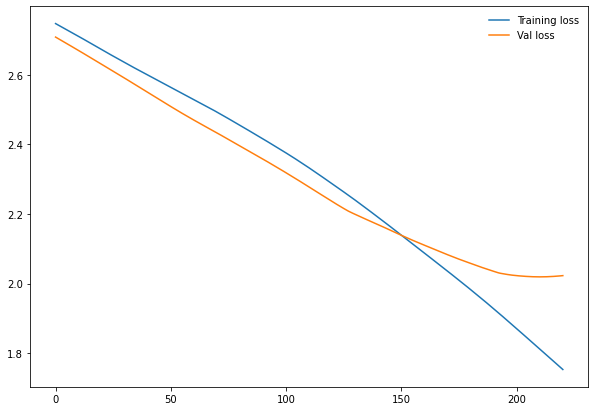

In [ ]:
plt.figure(figsize =(10, 7))
plt.plot(losses, label = "Training loss")
plt.plot(val_losses, label = "Val loss")
plt.legend(frameon=False)

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.5f}')

Test Accuracy: 0.66667


In [ ]:
model.eval()   # set model to evaluation mode
out = model(data.x, data.edge_index, data.edge_weight)
pred = out.argmax(dim=1)
print(pred[train_mask])
print(pred[val_mask])
print(pred[test_mask])

tensor([0, 1, 1, 0])
tensor([1, 0, 1, 1, 0, 0])
tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0])


[2, 12, 14, 15] [] [0, 3, 5, 20, 21] [8] [1, 4, 6, 9, 13, 16, 17, 18] [7, 10, 11, 19]


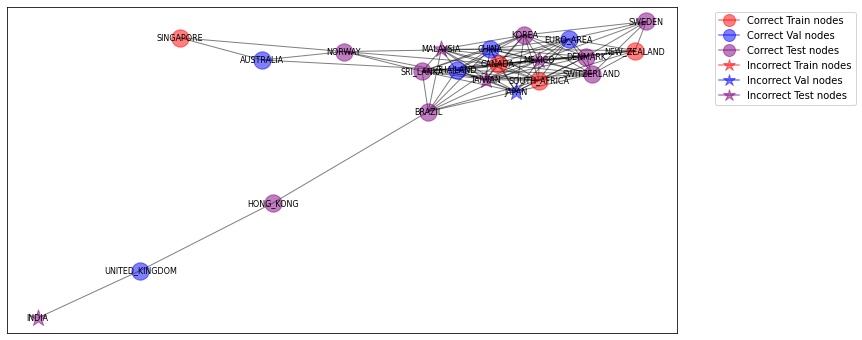

In [ ]:
classification_label(train_node,pred[train_mask],targets[train_mask],val_node,pred[val_mask],targets[val_mask], 
                         test_node,pred[test_mask],targets[test_mask], G)

# Training multiple models (corr=0.6)

In [ ]:
#for saving models
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
links_self_loop = links.loc[ (links['var1'] == links['var2']) ]
links_self_loop = links_self_loop.reset_index()
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) >= 0.6) & (links['var1'] != links['var2']) ]
links_filtered = links_filtered.reset_index()
links_filtered = pd.concat([links_filtered, links_self_loop])
links_filtered['weight'] = links_filtered['value'].abs()
links_filtered

index            var1            var2     value    weight
0      13       AUSTRALIA          NORWAY  0.836450  0.836450
1      14       AUSTRALIA       SINGAPORE  0.817890  0.817890
2      20       AUSTRALIA        THAILAND  0.600695  0.600695
3      24          BRAZIL          CANADA  0.809141  0.809141
4      25          BRAZIL           CHINA  0.807183  0.807183
..    ...             ...             ...       ...       ...
17    391          SWEDEN          SWEDEN  1.000000  1.000000
18    414     SWITZERLAND     SWITZERLAND  1.000000  1.000000
19    437          TAIWAN          TAIWAN  1.000000  1.000000
20    460        THAILAND        THAILAND  1.000000  1.000000
21    483  UNITED_KINGDOM  UNITED_KINGDOM  1.000000  1.000000

[230 rows x 5 columns]

In [ ]:
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr = True)
mapping = dict(zip(sorted(G), range(22)))
H = nx.relabel_nodes(G, mapping)
H.remove_edges_from(nx.selfloop_edges(H))

In [ ]:
edge_row1 = np.append(np.array([edge for edge in H.edges()]).T[0], np.array([edge for edge in H.edges()]).T[1])
edge_row2 = np.append(np.array([edge for edge in H.edges()]).T[1], np.array([edge for edge in H.edges()]).T[0])
edge = np.append([edge_row1], [edge_row2], axis=0)
edge_index = torch.LongTensor(edge)
edge_index.shape

torch.Size([2, 208])

In [ ]:
edge_weight = []
for e in H.edges:
  w = H[e[0]][e[1]]['weight']
  edge_weight.append(w)
edge_weight = np.stack(edge_weight)
edge_weight = np.append([edge_weight], [edge_weight])
edge_weight = torch.from_numpy((np.array(edge_weight)).astype(np.float32))
edge_weight.shape

torch.Size([208])

In [ ]:
import h5py

In [ ]:
data = Data(x=features1, edge_index=edge_index, edge_weight=edge_weight, y=targets, train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 208], edge_weight=[208], test_mask=[22], train_mask=[22], val_mask=[22], x=[22, 29], y=[22])
Number of nodes: 22
Number of edges: 208
Average node degree: 9.45
Number of training nodes: 4
Training node label rate: 0.18
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
import timeit

start = timeit.default_timer()

#Your statements here

m1={}
for i in range(30):
  #print('model'+ str(i))
  class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(29, hidden_channels)#, add_self_loops=False)
        self.conv2 = GCNConv(hidden_channels, 2)#, add_self_loops=False)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)# edge_attr)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)# edge_attr)
        return x

  #model = GCN(hidden_channels=16)
  #print(model)
  #print(model.conv1.bias)
  from IPython.display import Javascript  # Restrict height of output cell.
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

  model = GCN(32)
  criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)  # Define optimizer.
  es = EarlyStopping(patience=10)

  def train():
      model.train()   # setting the model to train mode
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

  def val ():
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
        return val_loss

  def test():
        with torch.no_grad():   #Turn off gradients.
          model.eval()   # set model to evaluation mode
          out = model(data.x, data.edge_index, data.edge_weight)
          pred = out.argmax(dim=1)  # Use the class with highest probability.
          test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
          test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
          return test_acc

  losses, val_losses = [], []
  val_loss = 100000
  for epoch in range(1, 2000):
      loss = train()
      val_loss = val()
      losses.append(loss)
      val_losses.append(val_loss)
      if es.step(val_loss):
        break
      print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
  test_acc = test()
  #print(f'Test Accuracy: {test_acc:.5f}')
  model.eval()   # set model to evaluation mode
  out = model(data.x, data.edge_index, data.edge_weight)
  pred = out.argmax(dim=1)
  model_save_name = 'classifier1.pt'
  path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
  torch.save({'model_state_dict': model.state_dict(),
            'losses': losses,
            'val_losses': val_losses,
            'test_acc': test_acc,
            'pred': pred
            }, path)
  m1["model{0}".format(i)]=torch.load(path)

torch.save(m1, F"/content/gdrive/My Drive/Colab Notebooks/m1")

stop = timeit.default_timer()

print('Time: ', stop - start)


<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7189, Val Loss: 0.7229
Epoch: 002, Train Loss: 0.7140, Val Loss: 0.7146
Epoch: 003, Train Loss: 0.7092, Val Loss: 0.7064
Epoch: 004, Train Loss: 0.7043, Val Loss: 0.6984
Epoch: 005, Train Loss: 0.6998, Val Loss: 0.6907
Epoch: 006, Train Loss: 0.6955, Val Loss: 0.6833
Epoch: 007, Train Loss: 0.6915, Val Loss: 0.6761
Epoch: 008, Train Loss: 0.6878, Val Loss: 0.6694
Epoch: 009, Train Loss: 0.6842, Val Loss: 0.6632
Epoch: 010, Train Loss: 0.6809, Val Loss: 0.6574
Epoch: 011, Train Loss: 0.6780, Val Loss: 0.6520
Epoch: 012, Train Loss: 0.6753, Val Loss: 0.6470
Epoch: 013, Train Loss: 0.6727, Val Loss: 0.6423
Epoch: 014, Train Loss: 0.6703, Val Loss: 0.6380
Epoch: 015, Train Loss: 0.6681, Val Loss: 0.6339
Epoch: 016, Train Loss: 0.6659, Val Loss: 0.6302
Epoch: 017, Train Loss: 0.6637, Val Loss: 0.6266
Epoch: 018, Train Loss: 0.6616, Val Loss: 0.6233
Epoch: 019, Train Loss: 0.6594, Val Loss: 0.6203
Epoch: 020, Train Loss: 0.6573, Val Loss: 0.6174
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6197, Val Loss: 0.6127
Epoch: 002, Train Loss: 0.6135, Val Loss: 0.6032
Epoch: 003, Train Loss: 0.6079, Val Loss: 0.5946
Epoch: 004, Train Loss: 0.6029, Val Loss: 0.5867
Epoch: 005, Train Loss: 0.5983, Val Loss: 0.5795
Epoch: 006, Train Loss: 0.5941, Val Loss: 0.5730
Epoch: 007, Train Loss: 0.5902, Val Loss: 0.5673
Epoch: 008, Train Loss: 0.5865, Val Loss: 0.5621
Epoch: 009, Train Loss: 0.5830, Val Loss: 0.5575
Epoch: 010, Train Loss: 0.5795, Val Loss: 0.5533
Epoch: 011, Train Loss: 0.5760, Val Loss: 0.5493
Epoch: 012, Train Loss: 0.5724, Val Loss: 0.5457
Epoch: 013, Train Loss: 0.5687, Val Loss: 0.5423
Epoch: 014, Train Loss: 0.5650, Val Loss: 0.5392
Epoch: 015, Train Loss: 0.5614, Val Loss: 0.5362
Epoch: 016, Train Loss: 0.5577, Val Loss: 0.5335
Epoch: 017, Train Loss: 0.5542, Val Loss: 0.5310
Epoch: 018, Train Loss: 0.5507, Val Loss: 0.5286
Epoch: 019, Train Loss: 0.5472, Val Loss: 0.5265
Epoch: 020, Train Loss: 0.5437, Val Loss: 0.5245
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6914, Val Loss: 0.6520
Epoch: 002, Train Loss: 0.6858, Val Loss: 0.6519
Epoch: 003, Train Loss: 0.6806, Val Loss: 0.6516
Epoch: 004, Train Loss: 0.6755, Val Loss: 0.6511
Epoch: 005, Train Loss: 0.6708, Val Loss: 0.6504
Epoch: 006, Train Loss: 0.6662, Val Loss: 0.6495
Epoch: 007, Train Loss: 0.6619, Val Loss: 0.6483
Epoch: 008, Train Loss: 0.6576, Val Loss: 0.6468
Epoch: 009, Train Loss: 0.6535, Val Loss: 0.6450
Epoch: 010, Train Loss: 0.6495, Val Loss: 0.6427
Epoch: 011, Train Loss: 0.6455, Val Loss: 0.6402
Epoch: 012, Train Loss: 0.6415, Val Loss: 0.6375
Epoch: 013, Train Loss: 0.6376, Val Loss: 0.6346
Epoch: 014, Train Loss: 0.6337, Val Loss: 0.6315
Epoch: 015, Train Loss: 0.6299, Val Loss: 0.6283
Epoch: 016, Train Loss: 0.6261, Val Loss: 0.6250
Epoch: 017, Train Loss: 0.6224, Val Loss: 0.6217
Epoch: 018, Train Loss: 0.6187, Val Loss: 0.6184
Epoch: 019, Train Loss: 0.6150, Val Loss: 0.6152
Epoch: 020, Train Loss: 0.6114, Val Loss: 0.6121
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.8964, Val Loss: 0.9513
Epoch: 002, Train Loss: 0.8826, Val Loss: 0.9317
Epoch: 003, Train Loss: 0.8696, Val Loss: 0.9127
Epoch: 004, Train Loss: 0.8571, Val Loss: 0.8944
Epoch: 005, Train Loss: 0.8451, Val Loss: 0.8768
Epoch: 006, Train Loss: 0.8336, Val Loss: 0.8598
Epoch: 007, Train Loss: 0.8226, Val Loss: 0.8435
Epoch: 008, Train Loss: 0.8121, Val Loss: 0.8279
Epoch: 009, Train Loss: 0.8021, Val Loss: 0.8130
Epoch: 010, Train Loss: 0.7926, Val Loss: 0.7987
Epoch: 011, Train Loss: 0.7835, Val Loss: 0.7850
Epoch: 012, Train Loss: 0.7749, Val Loss: 0.7720
Epoch: 013, Train Loss: 0.7668, Val Loss: 0.7599
Epoch: 014, Train Loss: 0.7593, Val Loss: 0.7485
Epoch: 015, Train Loss: 0.7523, Val Loss: 0.7378
Epoch: 016, Train Loss: 0.7458, Val Loss: 0.7277
Epoch: 017, Train Loss: 0.7397, Val Loss: 0.7182
Epoch: 018, Train Loss: 0.7340, Val Loss: 0.7095
Epoch: 019, Train Loss: 0.7290, Val Loss: 0.7014
Epoch: 020, Train Loss: 0.7243, Val Loss: 0.6939
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6727, Val Loss: 0.7234
Epoch: 002, Train Loss: 0.6673, Val Loss: 0.7131
Epoch: 003, Train Loss: 0.6623, Val Loss: 0.7035
Epoch: 004, Train Loss: 0.6579, Val Loss: 0.6946
Epoch: 005, Train Loss: 0.6539, Val Loss: 0.6863
Epoch: 006, Train Loss: 0.6502, Val Loss: 0.6786
Epoch: 007, Train Loss: 0.6469, Val Loss: 0.6716
Epoch: 008, Train Loss: 0.6439, Val Loss: 0.6651
Epoch: 009, Train Loss: 0.6412, Val Loss: 0.6591
Epoch: 010, Train Loss: 0.6388, Val Loss: 0.6539
Epoch: 011, Train Loss: 0.6366, Val Loss: 0.6492
Epoch: 012, Train Loss: 0.6346, Val Loss: 0.6450
Epoch: 013, Train Loss: 0.6328, Val Loss: 0.6413
Epoch: 014, Train Loss: 0.6311, Val Loss: 0.6380
Epoch: 015, Train Loss: 0.6295, Val Loss: 0.6351
Epoch: 016, Train Loss: 0.6279, Val Loss: 0.6324
Epoch: 017, Train Loss: 0.6263, Val Loss: 0.6300
Epoch: 018, Train Loss: 0.6245, Val Loss: 0.6278
Epoch: 019, Train Loss: 0.6226, Val Loss: 0.6259
Epoch: 020, Train Loss: 0.6208, Val Loss: 0.6243
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6779, Val Loss: 0.6229
Epoch: 002, Train Loss: 0.6741, Val Loss: 0.6192
Epoch: 003, Train Loss: 0.6702, Val Loss: 0.6155
Epoch: 004, Train Loss: 0.6664, Val Loss: 0.6117
Epoch: 005, Train Loss: 0.6625, Val Loss: 0.6079
Epoch: 006, Train Loss: 0.6586, Val Loss: 0.6040
Epoch: 007, Train Loss: 0.6546, Val Loss: 0.6004
Epoch: 008, Train Loss: 0.6506, Val Loss: 0.5969
Epoch: 009, Train Loss: 0.6468, Val Loss: 0.5935
Epoch: 010, Train Loss: 0.6429, Val Loss: 0.5902
Epoch: 011, Train Loss: 0.6391, Val Loss: 0.5870
Epoch: 012, Train Loss: 0.6354, Val Loss: 0.5840
Epoch: 013, Train Loss: 0.6318, Val Loss: 0.5811
Epoch: 014, Train Loss: 0.6284, Val Loss: 0.5784
Epoch: 015, Train Loss: 0.6249, Val Loss: 0.5758
Epoch: 016, Train Loss: 0.6216, Val Loss: 0.5733
Epoch: 017, Train Loss: 0.6183, Val Loss: 0.5709
Epoch: 018, Train Loss: 0.6151, Val Loss: 0.5686
Epoch: 019, Train Loss: 0.6119, Val Loss: 0.5663
Epoch: 020, Train Loss: 0.6088, Val Loss: 0.5638
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7271, Val Loss: 0.7099
Epoch: 002, Train Loss: 0.7199, Val Loss: 0.6970
Epoch: 003, Train Loss: 0.7133, Val Loss: 0.6851
Epoch: 004, Train Loss: 0.7075, Val Loss: 0.6740
Epoch: 005, Train Loss: 0.7021, Val Loss: 0.6639
Epoch: 006, Train Loss: 0.6972, Val Loss: 0.6547
Epoch: 007, Train Loss: 0.6928, Val Loss: 0.6464
Epoch: 008, Train Loss: 0.6889, Val Loss: 0.6390
Epoch: 009, Train Loss: 0.6852, Val Loss: 0.6324
Epoch: 010, Train Loss: 0.6818, Val Loss: 0.6265
Epoch: 011, Train Loss: 0.6784, Val Loss: 0.6213
Epoch: 012, Train Loss: 0.6752, Val Loss: 0.6168
Epoch: 013, Train Loss: 0.6721, Val Loss: 0.6129
Epoch: 014, Train Loss: 0.6691, Val Loss: 0.6094
Epoch: 015, Train Loss: 0.6661, Val Loss: 0.6063
Epoch: 016, Train Loss: 0.6629, Val Loss: 0.6037
Epoch: 017, Train Loss: 0.6599, Val Loss: 0.6014
Epoch: 018, Train Loss: 0.6568, Val Loss: 0.5994
Epoch: 019, Train Loss: 0.6536, Val Loss: 0.5976
Epoch: 020, Train Loss: 0.6504, Val Loss: 0.5960
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6478, Val Loss: 0.6159
Epoch: 002, Train Loss: 0.6437, Val Loss: 0.6104
Epoch: 003, Train Loss: 0.6398, Val Loss: 0.6056
Epoch: 004, Train Loss: 0.6359, Val Loss: 0.6016
Epoch: 005, Train Loss: 0.6322, Val Loss: 0.5982
Epoch: 006, Train Loss: 0.6284, Val Loss: 0.5953
Epoch: 007, Train Loss: 0.6247, Val Loss: 0.5926
Epoch: 008, Train Loss: 0.6210, Val Loss: 0.5902
Epoch: 009, Train Loss: 0.6173, Val Loss: 0.5879
Epoch: 010, Train Loss: 0.6135, Val Loss: 0.5856
Epoch: 011, Train Loss: 0.6099, Val Loss: 0.5833
Epoch: 012, Train Loss: 0.6062, Val Loss: 0.5808
Epoch: 013, Train Loss: 0.6026, Val Loss: 0.5783
Epoch: 014, Train Loss: 0.5990, Val Loss: 0.5756
Epoch: 015, Train Loss: 0.5955, Val Loss: 0.5727
Epoch: 016, Train Loss: 0.5919, Val Loss: 0.5698
Epoch: 017, Train Loss: 0.5884, Val Loss: 0.5668
Epoch: 018, Train Loss: 0.5849, Val Loss: 0.5638
Epoch: 019, Train Loss: 0.5814, Val Loss: 0.5608
Epoch: 020, Train Loss: 0.5779, Val Loss: 0.5578
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.8244, Val Loss: 0.9016
Epoch: 002, Train Loss: 0.8131, Val Loss: 0.8848
Epoch: 003, Train Loss: 0.8018, Val Loss: 0.8682
Epoch: 004, Train Loss: 0.7907, Val Loss: 0.8517
Epoch: 005, Train Loss: 0.7797, Val Loss: 0.8356
Epoch: 006, Train Loss: 0.7689, Val Loss: 0.8197
Epoch: 007, Train Loss: 0.7583, Val Loss: 0.8040
Epoch: 008, Train Loss: 0.7478, Val Loss: 0.7887
Epoch: 009, Train Loss: 0.7375, Val Loss: 0.7736
Epoch: 010, Train Loss: 0.7276, Val Loss: 0.7589
Epoch: 011, Train Loss: 0.7180, Val Loss: 0.7448
Epoch: 012, Train Loss: 0.7087, Val Loss: 0.7313
Epoch: 013, Train Loss: 0.6999, Val Loss: 0.7180
Epoch: 014, Train Loss: 0.6915, Val Loss: 0.7051
Epoch: 015, Train Loss: 0.6835, Val Loss: 0.6928
Epoch: 016, Train Loss: 0.6760, Val Loss: 0.6810
Epoch: 017, Train Loss: 0.6689, Val Loss: 0.6695
Epoch: 018, Train Loss: 0.6622, Val Loss: 0.6587
Epoch: 019, Train Loss: 0.6559, Val Loss: 0.6485
Epoch: 020, Train Loss: 0.6501, Val Loss: 0.6390
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6793, Val Loss: 0.6495
Epoch: 002, Train Loss: 0.6756, Val Loss: 0.6437
Epoch: 003, Train Loss: 0.6718, Val Loss: 0.6383
Epoch: 004, Train Loss: 0.6681, Val Loss: 0.6332
Epoch: 005, Train Loss: 0.6645, Val Loss: 0.6285
Epoch: 006, Train Loss: 0.6609, Val Loss: 0.6241
Epoch: 007, Train Loss: 0.6574, Val Loss: 0.6201
Epoch: 008, Train Loss: 0.6540, Val Loss: 0.6163
Epoch: 009, Train Loss: 0.6506, Val Loss: 0.6126
Epoch: 010, Train Loss: 0.6471, Val Loss: 0.6090
Epoch: 011, Train Loss: 0.6435, Val Loss: 0.6053
Epoch: 012, Train Loss: 0.6397, Val Loss: 0.6018
Epoch: 013, Train Loss: 0.6358, Val Loss: 0.5984
Epoch: 014, Train Loss: 0.6318, Val Loss: 0.5953
Epoch: 015, Train Loss: 0.6282, Val Loss: 0.5925
Epoch: 016, Train Loss: 0.6247, Val Loss: 0.5897
Epoch: 017, Train Loss: 0.6212, Val Loss: 0.5870
Epoch: 018, Train Loss: 0.6177, Val Loss: 0.5845
Epoch: 019, Train Loss: 0.6142, Val Loss: 0.5821
Epoch: 020, Train Loss: 0.6107, Val Loss: 0.5797
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6743, Val Loss: 0.6956
Epoch: 002, Train Loss: 0.6675, Val Loss: 0.6858
Epoch: 003, Train Loss: 0.6611, Val Loss: 0.6768
Epoch: 004, Train Loss: 0.6550, Val Loss: 0.6685
Epoch: 005, Train Loss: 0.6494, Val Loss: 0.6606
Epoch: 006, Train Loss: 0.6441, Val Loss: 0.6532
Epoch: 007, Train Loss: 0.6391, Val Loss: 0.6464
Epoch: 008, Train Loss: 0.6343, Val Loss: 0.6401
Epoch: 009, Train Loss: 0.6299, Val Loss: 0.6344
Epoch: 010, Train Loss: 0.6258, Val Loss: 0.6291
Epoch: 011, Train Loss: 0.6219, Val Loss: 0.6244
Epoch: 012, Train Loss: 0.6181, Val Loss: 0.6202
Epoch: 013, Train Loss: 0.6143, Val Loss: 0.6163
Epoch: 014, Train Loss: 0.6106, Val Loss: 0.6127
Epoch: 015, Train Loss: 0.6069, Val Loss: 0.6096
Epoch: 016, Train Loss: 0.6032, Val Loss: 0.6067
Epoch: 017, Train Loss: 0.5997, Val Loss: 0.6041
Epoch: 018, Train Loss: 0.5962, Val Loss: 0.6017
Epoch: 019, Train Loss: 0.5927, Val Loss: 0.5994
Epoch: 020, Train Loss: 0.5893, Val Loss: 0.5972
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6384, Val Loss: 0.6479
Epoch: 002, Train Loss: 0.6346, Val Loss: 0.6426
Epoch: 003, Train Loss: 0.6311, Val Loss: 0.6376
Epoch: 004, Train Loss: 0.6277, Val Loss: 0.6327
Epoch: 005, Train Loss: 0.6244, Val Loss: 0.6280
Epoch: 006, Train Loss: 0.6212, Val Loss: 0.6234
Epoch: 007, Train Loss: 0.6181, Val Loss: 0.6193
Epoch: 008, Train Loss: 0.6152, Val Loss: 0.6153
Epoch: 009, Train Loss: 0.6124, Val Loss: 0.6116
Epoch: 010, Train Loss: 0.6097, Val Loss: 0.6081
Epoch: 011, Train Loss: 0.6070, Val Loss: 0.6048
Epoch: 012, Train Loss: 0.6043, Val Loss: 0.6017
Epoch: 013, Train Loss: 0.6016, Val Loss: 0.5988
Epoch: 014, Train Loss: 0.5988, Val Loss: 0.5961
Epoch: 015, Train Loss: 0.5960, Val Loss: 0.5935
Epoch: 016, Train Loss: 0.5932, Val Loss: 0.5912
Epoch: 017, Train Loss: 0.5905, Val Loss: 0.5890
Epoch: 018, Train Loss: 0.5876, Val Loss: 0.5871
Epoch: 019, Train Loss: 0.5849, Val Loss: 0.5855
Epoch: 020, Train Loss: 0.5822, Val Loss: 0.5839
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6471, Val Loss: 0.6491
Epoch: 002, Train Loss: 0.6438, Val Loss: 0.6447
Epoch: 003, Train Loss: 0.6405, Val Loss: 0.6404
Epoch: 004, Train Loss: 0.6374, Val Loss: 0.6363
Epoch: 005, Train Loss: 0.6344, Val Loss: 0.6324
Epoch: 006, Train Loss: 0.6314, Val Loss: 0.6287
Epoch: 007, Train Loss: 0.6285, Val Loss: 0.6251
Epoch: 008, Train Loss: 0.6257, Val Loss: 0.6217
Epoch: 009, Train Loss: 0.6229, Val Loss: 0.6183
Epoch: 010, Train Loss: 0.6202, Val Loss: 0.6150
Epoch: 011, Train Loss: 0.6175, Val Loss: 0.6120
Epoch: 012, Train Loss: 0.6148, Val Loss: 0.6091
Epoch: 013, Train Loss: 0.6121, Val Loss: 0.6065
Epoch: 014, Train Loss: 0.6095, Val Loss: 0.6041
Epoch: 015, Train Loss: 0.6071, Val Loss: 0.6017
Epoch: 016, Train Loss: 0.6047, Val Loss: 0.5997
Epoch: 017, Train Loss: 0.6024, Val Loss: 0.5978
Epoch: 018, Train Loss: 0.6003, Val Loss: 0.5960
Epoch: 019, Train Loss: 0.5981, Val Loss: 0.5943
Epoch: 020, Train Loss: 0.5961, Val Loss: 0.5926
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6572, Val Loss: 0.6520
Epoch: 002, Train Loss: 0.6540, Val Loss: 0.6467
Epoch: 003, Train Loss: 0.6511, Val Loss: 0.6421
Epoch: 004, Train Loss: 0.6486, Val Loss: 0.6378
Epoch: 005, Train Loss: 0.6462, Val Loss: 0.6337
Epoch: 006, Train Loss: 0.6439, Val Loss: 0.6298
Epoch: 007, Train Loss: 0.6415, Val Loss: 0.6262
Epoch: 008, Train Loss: 0.6393, Val Loss: 0.6228
Epoch: 009, Train Loss: 0.6370, Val Loss: 0.6197
Epoch: 010, Train Loss: 0.6348, Val Loss: 0.6167
Epoch: 011, Train Loss: 0.6326, Val Loss: 0.6140
Epoch: 012, Train Loss: 0.6304, Val Loss: 0.6116
Epoch: 013, Train Loss: 0.6284, Val Loss: 0.6093
Epoch: 014, Train Loss: 0.6263, Val Loss: 0.6072
Epoch: 015, Train Loss: 0.6243, Val Loss: 0.6054
Epoch: 016, Train Loss: 0.6223, Val Loss: 0.6036
Epoch: 017, Train Loss: 0.6203, Val Loss: 0.6021
Epoch: 018, Train Loss: 0.6184, Val Loss: 0.6006
Epoch: 019, Train Loss: 0.6165, Val Loss: 0.5993
Epoch: 020, Train Loss: 0.6146, Val Loss: 0.5980
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7584, Val Loss: 0.7916
Epoch: 002, Train Loss: 0.7491, Val Loss: 0.7777
Epoch: 003, Train Loss: 0.7404, Val Loss: 0.7643
Epoch: 004, Train Loss: 0.7322, Val Loss: 0.7515
Epoch: 005, Train Loss: 0.7246, Val Loss: 0.7393
Epoch: 006, Train Loss: 0.7174, Val Loss: 0.7276
Epoch: 007, Train Loss: 0.7106, Val Loss: 0.7166
Epoch: 008, Train Loss: 0.7043, Val Loss: 0.7062
Epoch: 009, Train Loss: 0.6985, Val Loss: 0.6965
Epoch: 010, Train Loss: 0.6932, Val Loss: 0.6874
Epoch: 011, Train Loss: 0.6883, Val Loss: 0.6790
Epoch: 012, Train Loss: 0.6837, Val Loss: 0.6712
Epoch: 013, Train Loss: 0.6795, Val Loss: 0.6641
Epoch: 014, Train Loss: 0.6756, Val Loss: 0.6574
Epoch: 015, Train Loss: 0.6720, Val Loss: 0.6514
Epoch: 016, Train Loss: 0.6686, Val Loss: 0.6456
Epoch: 017, Train Loss: 0.6652, Val Loss: 0.6403
Epoch: 018, Train Loss: 0.6621, Val Loss: 0.6355
Epoch: 019, Train Loss: 0.6592, Val Loss: 0.6311
Epoch: 020, Train Loss: 0.6566, Val Loss: 0.6271
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6685, Val Loss: 0.6063
Epoch: 002, Train Loss: 0.6617, Val Loss: 0.6068
Epoch: 003, Train Loss: 0.6557, Val Loss: 0.6077
Epoch: 004, Train Loss: 0.6502, Val Loss: 0.6089
Epoch: 005, Train Loss: 0.6453, Val Loss: 0.6103
Epoch: 006, Train Loss: 0.6408, Val Loss: 0.6119
Epoch: 007, Train Loss: 0.6366, Val Loss: 0.6136
Epoch: 008, Train Loss: 0.6329, Val Loss: 0.6153
Epoch: 009, Train Loss: 0.6295, Val Loss: 0.6169
Epoch: 010, Train Loss: 0.6264, Val Loss: 0.6183


<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7216, Val Loss: 0.7297
Epoch: 002, Train Loss: 0.7139, Val Loss: 0.7168
Epoch: 003, Train Loss: 0.7069, Val Loss: 0.7049
Epoch: 004, Train Loss: 0.7006, Val Loss: 0.6939
Epoch: 005, Train Loss: 0.6948, Val Loss: 0.6840
Epoch: 006, Train Loss: 0.6895, Val Loss: 0.6749
Epoch: 007, Train Loss: 0.6847, Val Loss: 0.6668
Epoch: 008, Train Loss: 0.6802, Val Loss: 0.6595
Epoch: 009, Train Loss: 0.6761, Val Loss: 0.6529
Epoch: 010, Train Loss: 0.6721, Val Loss: 0.6472
Epoch: 011, Train Loss: 0.6685, Val Loss: 0.6421
Epoch: 012, Train Loss: 0.6652, Val Loss: 0.6376
Epoch: 013, Train Loss: 0.6619, Val Loss: 0.6336
Epoch: 014, Train Loss: 0.6587, Val Loss: 0.6301
Epoch: 015, Train Loss: 0.6556, Val Loss: 0.6270
Epoch: 016, Train Loss: 0.6524, Val Loss: 0.6243
Epoch: 017, Train Loss: 0.6493, Val Loss: 0.6220
Epoch: 018, Train Loss: 0.6461, Val Loss: 0.6200
Epoch: 019, Train Loss: 0.6429, Val Loss: 0.6183
Epoch: 020, Train Loss: 0.6397, Val Loss: 0.6168
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7070, Val Loss: 0.6865
Epoch: 002, Train Loss: 0.7007, Val Loss: 0.6765
Epoch: 003, Train Loss: 0.6950, Val Loss: 0.6674
Epoch: 004, Train Loss: 0.6896, Val Loss: 0.6589
Epoch: 005, Train Loss: 0.6847, Val Loss: 0.6513
Epoch: 006, Train Loss: 0.6800, Val Loss: 0.6445
Epoch: 007, Train Loss: 0.6754, Val Loss: 0.6386
Epoch: 008, Train Loss: 0.6710, Val Loss: 0.6335
Epoch: 009, Train Loss: 0.6669, Val Loss: 0.6290
Epoch: 010, Train Loss: 0.6628, Val Loss: 0.6251
Epoch: 011, Train Loss: 0.6588, Val Loss: 0.6220
Epoch: 012, Train Loss: 0.6550, Val Loss: 0.6193
Epoch: 013, Train Loss: 0.6511, Val Loss: 0.6169
Epoch: 014, Train Loss: 0.6474, Val Loss: 0.6148
Epoch: 015, Train Loss: 0.6439, Val Loss: 0.6131
Epoch: 016, Train Loss: 0.6404, Val Loss: 0.6115
Epoch: 017, Train Loss: 0.6371, Val Loss: 0.6100
Epoch: 018, Train Loss: 0.6339, Val Loss: 0.6083
Epoch: 019, Train Loss: 0.6306, Val Loss: 0.6067
Epoch: 020, Train Loss: 0.6275, Val Loss: 0.6049
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6721, Val Loss: 0.7021
Epoch: 002, Train Loss: 0.6650, Val Loss: 0.6905
Epoch: 003, Train Loss: 0.6586, Val Loss: 0.6796
Epoch: 004, Train Loss: 0.6527, Val Loss: 0.6695
Epoch: 005, Train Loss: 0.6471, Val Loss: 0.6602
Epoch: 006, Train Loss: 0.6419, Val Loss: 0.6514
Epoch: 007, Train Loss: 0.6371, Val Loss: 0.6434
Epoch: 008, Train Loss: 0.6324, Val Loss: 0.6362
Epoch: 009, Train Loss: 0.6280, Val Loss: 0.6294
Epoch: 010, Train Loss: 0.6238, Val Loss: 0.6231
Epoch: 011, Train Loss: 0.6198, Val Loss: 0.6173
Epoch: 012, Train Loss: 0.6160, Val Loss: 0.6120
Epoch: 013, Train Loss: 0.6123, Val Loss: 0.6071
Epoch: 014, Train Loss: 0.6087, Val Loss: 0.6025
Epoch: 015, Train Loss: 0.6051, Val Loss: 0.5983
Epoch: 016, Train Loss: 0.6017, Val Loss: 0.5946
Epoch: 017, Train Loss: 0.5984, Val Loss: 0.5913
Epoch: 018, Train Loss: 0.5952, Val Loss: 0.5882
Epoch: 019, Train Loss: 0.5922, Val Loss: 0.5854
Epoch: 020, Train Loss: 0.5891, Val Loss: 0.5827
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6975, Val Loss: 0.6485
Epoch: 002, Train Loss: 0.6927, Val Loss: 0.6487
Epoch: 003, Train Loss: 0.6883, Val Loss: 0.6490
Epoch: 004, Train Loss: 0.6842, Val Loss: 0.6494
Epoch: 005, Train Loss: 0.6805, Val Loss: 0.6499
Epoch: 006, Train Loss: 0.6770, Val Loss: 0.6503
Epoch: 007, Train Loss: 0.6738, Val Loss: 0.6505
Epoch: 008, Train Loss: 0.6705, Val Loss: 0.6506
Epoch: 009, Train Loss: 0.6675, Val Loss: 0.6506
Epoch: 010, Train Loss: 0.6645, Val Loss: 0.6503


<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6711, Val Loss: 0.6228
Epoch: 002, Train Loss: 0.6670, Val Loss: 0.6214
Epoch: 003, Train Loss: 0.6631, Val Loss: 0.6200
Epoch: 004, Train Loss: 0.6593, Val Loss: 0.6185
Epoch: 005, Train Loss: 0.6555, Val Loss: 0.6169
Epoch: 006, Train Loss: 0.6518, Val Loss: 0.6153
Epoch: 007, Train Loss: 0.6482, Val Loss: 0.6135
Epoch: 008, Train Loss: 0.6446, Val Loss: 0.6116
Epoch: 009, Train Loss: 0.6410, Val Loss: 0.6097
Epoch: 010, Train Loss: 0.6374, Val Loss: 0.6076
Epoch: 011, Train Loss: 0.6338, Val Loss: 0.6054
Epoch: 012, Train Loss: 0.6302, Val Loss: 0.6031
Epoch: 013, Train Loss: 0.6267, Val Loss: 0.6007
Epoch: 014, Train Loss: 0.6232, Val Loss: 0.5982
Epoch: 015, Train Loss: 0.6196, Val Loss: 0.5957
Epoch: 016, Train Loss: 0.6161, Val Loss: 0.5932
Epoch: 017, Train Loss: 0.6126, Val Loss: 0.5908
Epoch: 018, Train Loss: 0.6091, Val Loss: 0.5884
Epoch: 019, Train Loss: 0.6058, Val Loss: 0.5861
Epoch: 020, Train Loss: 0.6025, Val Loss: 0.5838
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7988, Val Loss: 0.8754
Epoch: 002, Train Loss: 0.7849, Val Loss: 0.8545
Epoch: 003, Train Loss: 0.7716, Val Loss: 0.8345
Epoch: 004, Train Loss: 0.7591, Val Loss: 0.8153
Epoch: 005, Train Loss: 0.7472, Val Loss: 0.7970
Epoch: 006, Train Loss: 0.7360, Val Loss: 0.7797
Epoch: 007, Train Loss: 0.7256, Val Loss: 0.7637
Epoch: 008, Train Loss: 0.7160, Val Loss: 0.7486
Epoch: 009, Train Loss: 0.7072, Val Loss: 0.7345
Epoch: 010, Train Loss: 0.6992, Val Loss: 0.7213
Epoch: 011, Train Loss: 0.6918, Val Loss: 0.7090
Epoch: 012, Train Loss: 0.6850, Val Loss: 0.6976
Epoch: 013, Train Loss: 0.6788, Val Loss: 0.6870
Epoch: 014, Train Loss: 0.6733, Val Loss: 0.6771
Epoch: 015, Train Loss: 0.6682, Val Loss: 0.6681
Epoch: 016, Train Loss: 0.6637, Val Loss: 0.6598
Epoch: 017, Train Loss: 0.6597, Val Loss: 0.6522
Epoch: 018, Train Loss: 0.6561, Val Loss: 0.6453
Epoch: 019, Train Loss: 0.6529, Val Loss: 0.6391
Epoch: 020, Train Loss: 0.6501, Val Loss: 0.6333
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6533, Val Loss: 0.6731
Epoch: 002, Train Loss: 0.6468, Val Loss: 0.6613
Epoch: 003, Train Loss: 0.6411, Val Loss: 0.6506
Epoch: 004, Train Loss: 0.6360, Val Loss: 0.6410
Epoch: 005, Train Loss: 0.6316, Val Loss: 0.6324
Epoch: 006, Train Loss: 0.6277, Val Loss: 0.6247
Epoch: 007, Train Loss: 0.6243, Val Loss: 0.6179
Epoch: 008, Train Loss: 0.6213, Val Loss: 0.6118
Epoch: 009, Train Loss: 0.6187, Val Loss: 0.6065
Epoch: 010, Train Loss: 0.6164, Val Loss: 0.6018
Epoch: 011, Train Loss: 0.6144, Val Loss: 0.5976
Epoch: 012, Train Loss: 0.6124, Val Loss: 0.5941
Epoch: 013, Train Loss: 0.6106, Val Loss: 0.5909
Epoch: 014, Train Loss: 0.6089, Val Loss: 0.5882
Epoch: 015, Train Loss: 0.6071, Val Loss: 0.5858
Epoch: 016, Train Loss: 0.6052, Val Loss: 0.5837
Epoch: 017, Train Loss: 0.6033, Val Loss: 0.5818
Epoch: 018, Train Loss: 0.6014, Val Loss: 0.5801
Epoch: 019, Train Loss: 0.5993, Val Loss: 0.5787
Epoch: 020, Train Loss: 0.5972, Val Loss: 0.5774
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7035, Val Loss: 0.6218
Epoch: 002, Train Loss: 0.6971, Val Loss: 0.6211
Epoch: 003, Train Loss: 0.6910, Val Loss: 0.6206
Epoch: 004, Train Loss: 0.6853, Val Loss: 0.6204
Epoch: 005, Train Loss: 0.6801, Val Loss: 0.6204
Epoch: 006, Train Loss: 0.6752, Val Loss: 0.6206
Epoch: 007, Train Loss: 0.6707, Val Loss: 0.6208
Epoch: 008, Train Loss: 0.6666, Val Loss: 0.6210
Epoch: 009, Train Loss: 0.6628, Val Loss: 0.6211
Epoch: 010, Train Loss: 0.6592, Val Loss: 0.6212
Epoch: 011, Train Loss: 0.6559, Val Loss: 0.6210
Epoch: 012, Train Loss: 0.6527, Val Loss: 0.6204
Epoch: 013, Train Loss: 0.6495, Val Loss: 0.6194
Epoch: 014, Train Loss: 0.6465, Val Loss: 0.6180
Epoch: 015, Train Loss: 0.6434, Val Loss: 0.6164
Epoch: 016, Train Loss: 0.6404, Val Loss: 0.6145
Epoch: 017, Train Loss: 0.6375, Val Loss: 0.6123
Epoch: 018, Train Loss: 0.6346, Val Loss: 0.6099
Epoch: 019, Train Loss: 0.6318, Val Loss: 0.6073
Epoch: 020, Train Loss: 0.6291, Val Loss: 0.6046
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7188, Val Loss: 0.6021
Epoch: 002, Train Loss: 0.7096, Val Loss: 0.5993
Epoch: 003, Train Loss: 0.7010, Val Loss: 0.5968
Epoch: 004, Train Loss: 0.6929, Val Loss: 0.5948
Epoch: 005, Train Loss: 0.6852, Val Loss: 0.5931
Epoch: 006, Train Loss: 0.6781, Val Loss: 0.5917
Epoch: 007, Train Loss: 0.6714, Val Loss: 0.5906
Epoch: 008, Train Loss: 0.6650, Val Loss: 0.5896
Epoch: 009, Train Loss: 0.6590, Val Loss: 0.5889
Epoch: 010, Train Loss: 0.6534, Val Loss: 0.5884
Epoch: 011, Train Loss: 0.6483, Val Loss: 0.5881
Epoch: 012, Train Loss: 0.6434, Val Loss: 0.5878
Epoch: 013, Train Loss: 0.6389, Val Loss: 0.5876
Epoch: 014, Train Loss: 0.6347, Val Loss: 0.5875
Epoch: 015, Train Loss: 0.6307, Val Loss: 0.5873
Epoch: 016, Train Loss: 0.6270, Val Loss: 0.5871
Epoch: 017, Train Loss: 0.6236, Val Loss: 0.5869
Epoch: 018, Train Loss: 0.6204, Val Loss: 0.5867
Epoch: 019, Train Loss: 0.6173, Val Loss: 0.5865
Epoch: 020, Train Loss: 0.6147, Val Loss: 0.5863
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7459, Val Loss: 0.6329
Epoch: 002, Train Loss: 0.7337, Val Loss: 0.6303
Epoch: 003, Train Loss: 0.7223, Val Loss: 0.6282
Epoch: 004, Train Loss: 0.7114, Val Loss: 0.6267
Epoch: 005, Train Loss: 0.7012, Val Loss: 0.6260
Epoch: 006, Train Loss: 0.6919, Val Loss: 0.6260
Epoch: 007, Train Loss: 0.6836, Val Loss: 0.6267
Epoch: 008, Train Loss: 0.6764, Val Loss: 0.6279
Epoch: 009, Train Loss: 0.6702, Val Loss: 0.6296
Epoch: 010, Train Loss: 0.6648, Val Loss: 0.6315
Epoch: 011, Train Loss: 0.6600, Val Loss: 0.6335
Epoch: 012, Train Loss: 0.6557, Val Loss: 0.6356
Epoch: 013, Train Loss: 0.6520, Val Loss: 0.6376
Epoch: 014, Train Loss: 0.6487, Val Loss: 0.6395
Epoch: 015, Train Loss: 0.6456, Val Loss: 0.6410


<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7327, Val Loss: 0.6938
Epoch: 002, Train Loss: 0.7282, Val Loss: 0.6918
Epoch: 003, Train Loss: 0.7239, Val Loss: 0.6899
Epoch: 004, Train Loss: 0.7198, Val Loss: 0.6881
Epoch: 005, Train Loss: 0.7158, Val Loss: 0.6863
Epoch: 006, Train Loss: 0.7118, Val Loss: 0.6844
Epoch: 007, Train Loss: 0.7079, Val Loss: 0.6825
Epoch: 008, Train Loss: 0.7041, Val Loss: 0.6806
Epoch: 009, Train Loss: 0.7003, Val Loss: 0.6787
Epoch: 010, Train Loss: 0.6967, Val Loss: 0.6769
Epoch: 011, Train Loss: 0.6931, Val Loss: 0.6749
Epoch: 012, Train Loss: 0.6896, Val Loss: 0.6729
Epoch: 013, Train Loss: 0.6861, Val Loss: 0.6708
Epoch: 014, Train Loss: 0.6826, Val Loss: 0.6685
Epoch: 015, Train Loss: 0.6791, Val Loss: 0.6662
Epoch: 016, Train Loss: 0.6757, Val Loss: 0.6638
Epoch: 017, Train Loss: 0.6723, Val Loss: 0.6615
Epoch: 018, Train Loss: 0.6690, Val Loss: 0.6591
Epoch: 019, Train Loss: 0.6658, Val Loss: 0.6567
Epoch: 020, Train Loss: 0.6627, Val Loss: 0.6543
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7822, Val Loss: 0.6667
Epoch: 002, Train Loss: 0.7739, Val Loss: 0.6649
Epoch: 003, Train Loss: 0.7661, Val Loss: 0.6633
Epoch: 004, Train Loss: 0.7587, Val Loss: 0.6617
Epoch: 005, Train Loss: 0.7515, Val Loss: 0.6602
Epoch: 006, Train Loss: 0.7445, Val Loss: 0.6586
Epoch: 007, Train Loss: 0.7378, Val Loss: 0.6568
Epoch: 008, Train Loss: 0.7312, Val Loss: 0.6550
Epoch: 009, Train Loss: 0.7251, Val Loss: 0.6529
Epoch: 010, Train Loss: 0.7192, Val Loss: 0.6507
Epoch: 011, Train Loss: 0.7134, Val Loss: 0.6482
Epoch: 012, Train Loss: 0.7077, Val Loss: 0.6452
Epoch: 013, Train Loss: 0.7021, Val Loss: 0.6421
Epoch: 014, Train Loss: 0.6967, Val Loss: 0.6390
Epoch: 015, Train Loss: 0.6917, Val Loss: 0.6358
Epoch: 016, Train Loss: 0.6871, Val Loss: 0.6325
Epoch: 017, Train Loss: 0.6826, Val Loss: 0.6291
Epoch: 018, Train Loss: 0.6782, Val Loss: 0.6255
Epoch: 019, Train Loss: 0.6738, Val Loss: 0.6219
Epoch: 020, Train Loss: 0.6696, Val Loss: 0.6181
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7615, Val Loss: 0.7745
Epoch: 002, Train Loss: 0.7491, Val Loss: 0.7542
Epoch: 003, Train Loss: 0.7382, Val Loss: 0.7359
Epoch: 004, Train Loss: 0.7287, Val Loss: 0.7195
Epoch: 005, Train Loss: 0.7205, Val Loss: 0.7050
Epoch: 006, Train Loss: 0.7135, Val Loss: 0.6920
Epoch: 007, Train Loss: 0.7074, Val Loss: 0.6805
Epoch: 008, Train Loss: 0.7021, Val Loss: 0.6705
Epoch: 009, Train Loss: 0.6975, Val Loss: 0.6620
Epoch: 010, Train Loss: 0.6934, Val Loss: 0.6549
Epoch: 011, Train Loss: 0.6897, Val Loss: 0.6489
Epoch: 012, Train Loss: 0.6862, Val Loss: 0.6438
Epoch: 013, Train Loss: 0.6828, Val Loss: 0.6394
Epoch: 014, Train Loss: 0.6793, Val Loss: 0.6358
Epoch: 015, Train Loss: 0.6756, Val Loss: 0.6328
Epoch: 016, Train Loss: 0.6720, Val Loss: 0.6306
Epoch: 017, Train Loss: 0.6686, Val Loss: 0.6287
Epoch: 018, Train Loss: 0.6650, Val Loss: 0.6272
Epoch: 019, Train Loss: 0.6614, Val Loss: 0.6259
Epoch: 020, Train Loss: 0.6578, Val Loss: 0.6249
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.7363, Val Loss: 0.7783
Epoch: 002, Train Loss: 0.7198, Val Loss: 0.7546
Epoch: 003, Train Loss: 0.7044, Val Loss: 0.7318
Epoch: 004, Train Loss: 0.6899, Val Loss: 0.7108
Epoch: 005, Train Loss: 0.6770, Val Loss: 0.6913
Epoch: 006, Train Loss: 0.6652, Val Loss: 0.6730
Epoch: 007, Train Loss: 0.6545, Val Loss: 0.6564
Epoch: 008, Train Loss: 0.6452, Val Loss: 0.6413
Epoch: 009, Train Loss: 0.6372, Val Loss: 0.6280
Epoch: 010, Train Loss: 0.6304, Val Loss: 0.6161
Epoch: 011, Train Loss: 0.6248, Val Loss: 0.6057
Epoch: 012, Train Loss: 0.6200, Val Loss: 0.5966
Epoch: 013, Train Loss: 0.6160, Val Loss: 0.5887
Epoch: 014, Train Loss: 0.6128, Val Loss: 0.5820
Epoch: 015, Train Loss: 0.6101, Val Loss: 0.5761
Epoch: 016, Train Loss: 0.6078, Val Loss: 0.5711
Epoch: 017, Train Loss: 0.6059, Val Loss: 0.5668
Epoch: 018, Train Loss: 0.6042, Val Loss: 0.5632
Epoch: 019, Train Loss: 0.6026, Val Loss: 0.5599
Epoch: 020, Train Loss: 0.6010, Val Loss: 0.5570
Epoch: 021, Train Lo

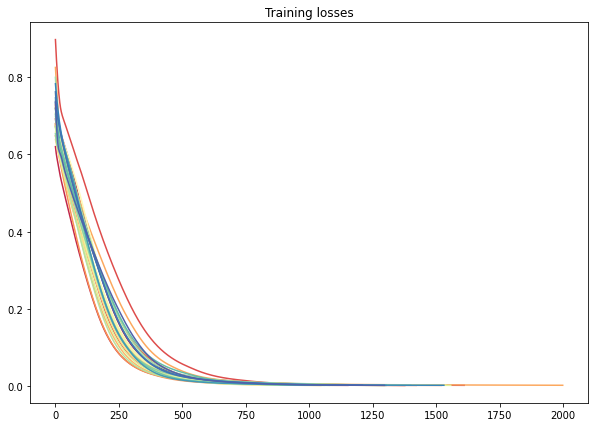

In [ ]:
import seaborn as sns
plt.figure(figsize =(10, 7))
with sns.color_palette("Spectral", n_colors=30):
    for i in range(30):
      plt.plot(m1['model{0}'.format(i)]['losses'])
plt.title("Training losses")
plt.show()

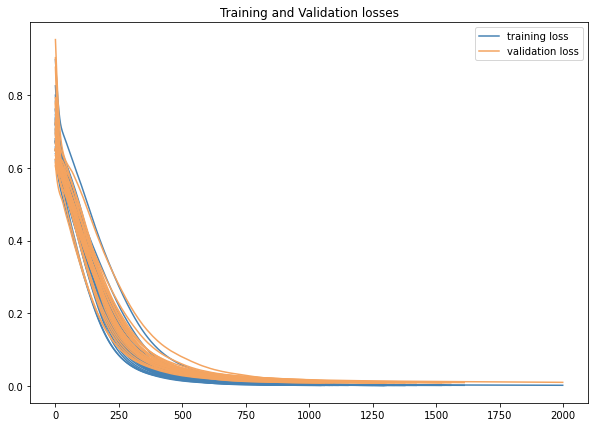

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
plt.figure(figsize =(10, 7))
with sns.color_palette(mcolors.CSS4_COLORS):
    for i in range(30):
      train_plot = plt.plot(m1['model{0}'.format(i)]['losses'],'steelblue', label=('' if i==0 else '_') + 'training loss')
    for i in range(30):
      val_plot = plt.plot(m1['model{0}'.format(i)]['val_losses'], 'sandybrown', label=('' if i==0 else '_') + 'validation loss')
plt.title("Training and Validation losses")
plt.legend()
plt.show()

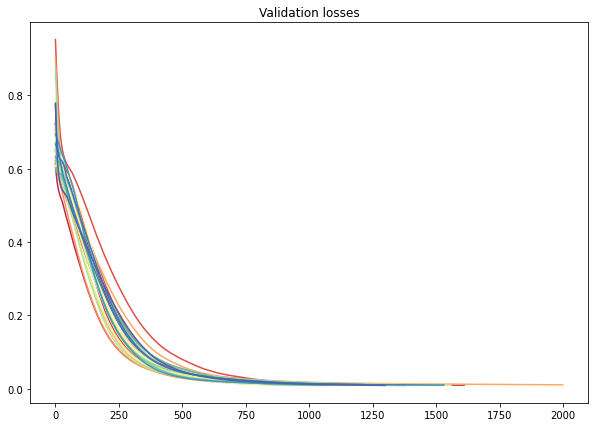

In [ ]:
import seaborn as sns
plt.figure(figsize =(10, 7))
with sns.color_palette("Spectral", n_colors=30):
    for i in range(30):
      plt.plot(m1['model{0}'.format(i)]['val_losses'])
plt.title("Validation losses")
plt.show()

In [ ]:
m1_test_acc = []
for i in range(30):
  m1_test_acc.append(m1['model{0}'.format(i)]['test_acc'])
m1_test_acc = pd.DataFrame(m1_test_acc)
m1_test_acc.describe()

0
count  30.000000
mean    0.708333
std     0.127137
min     0.333333
25%     0.750000
50%     0.750000
75%     0.750000
max     0.750000

In [ ]:
m1.keys()

dict_keys(['model0', 'model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'model14', 'model15', 'model16', 'model17', 'model18', 'model19', 'model20', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26', 'model27', 'model28', 'model29'])

In [ ]:
for i in range(30):
  classification_label(train_node,m1['model{0}'.format(i)]['pred'][train_mask],targets[train_mask],val_node,m1['model{0}'.format(i)]['pred'][val_mask],targets[val_mask], 
                         test_node,m1['model{0}'.format(i)]['pred'][test_mask],targets[test_mask], G)

In [ ]:
for i in range(30):
  plt.figure(figsize =(10, 7))
  plt.plot(m1['model{0}'.format(i)]['model_state_dict']['conv1.weight'])
  plt.title('model{0}'.format(i))
  plt.xticks(np.arange(0, 30, 7))
  plt.show()

# Training multiple models (corr=0.6): negative edgeweight


In [ ]:
#for saving models
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
links_self_loop = links.loc[ (links['var1'] == links['var2']) ]
links_self_loop = links_self_loop.reset_index()
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) >= 0.6) & (links['var1'] != links['var2']) ]
links_filtered = links_filtered.reset_index()
links_filtered = pd.concat([links_filtered, links_self_loop])
links_filtered['weight'] = links_filtered['value']
links_filtered

index            var1            var2     value    weight
0      13       AUSTRALIA          NORWAY  0.836450  0.836450
1      14       AUSTRALIA       SINGAPORE  0.817890  0.817890
2      20       AUSTRALIA        THAILAND  0.600695  0.600695
3      24          BRAZIL          CANADA  0.809141  0.809141
4      25          BRAZIL           CHINA  0.807183  0.807183
..    ...             ...             ...       ...       ...
17    391          SWEDEN          SWEDEN  1.000000  1.000000
18    414     SWITZERLAND     SWITZERLAND  1.000000  1.000000
19    437          TAIWAN          TAIWAN  1.000000  1.000000
20    460        THAILAND        THAILAND  1.000000  1.000000
21    483  UNITED_KINGDOM  UNITED_KINGDOM  1.000000  1.000000

[230 rows x 5 columns]

In [ ]:
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr = True)
mapping = dict(zip(sorted(G), range(22)))
H = nx.relabel_nodes(G, mapping)
H.remove_edges_from(nx.selfloop_edges(H))

In [ ]:
edge_row1 = np.append(np.array([edge for edge in H.edges()]).T[0], np.array([edge for edge in H.edges()]).T[1])
edge_row2 = np.append(np.array([edge for edge in H.edges()]).T[1], np.array([edge for edge in H.edges()]).T[0])
edge = np.append([edge_row1], [edge_row2], axis=0)
edge_index = torch.LongTensor(edge)
edge_index.shape

torch.Size([2, 208])

In [ ]:
edge_weight = []
for e in H.edges:
  w = H[e[0]][e[1]]['weight']
  edge_weight.append(w)
edge_weight = np.stack(edge_weight)
edge_weight = np.append([edge_weight], [edge_weight])
edge_weight = torch.from_numpy((np.array(edge_weight)).astype(np.float32))
edge_weight.shape

torch.Size([208])

In [ ]:
import h5py

In [ ]:
data = Data(x=features1, edge_index=edge_index, edge_weight=edge_weight, y=targets, train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 208], edge_weight=[208], test_mask=[22], train_mask=[22], val_mask=[22], x=[22, 29], y=[22])
Number of nodes: 22
Number of edges: 208
Average node degree: 9.45
Number of training nodes: 4
Training node label rate: 0.18
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
import timeit

start = timeit.default_timer()

#Your statements here

m1={}
for i in range(30):
  #print('model'+ str(i))
  class GCNConv_edgeweight_two_layer(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2):
        super(GCNConv_edgeweight_two_layer, self).__init__()
        self.conv1 = GCNConv_edgeweight(29, hidden_channels1)
        self.conv2 = GCNConv_edgeweight(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv_edgeweight(hidden_channels2, 2)
        #self.conv4 = GCNConv_edgeweight(hidden_channels3, 2)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        #x = F.dropout(x, p=0.25, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

  #model = GCN(hidden_channels=16)
  #print(model)
  #print(model.conv1.bias)
  from IPython.display import Javascript  # Restrict height of output cell.
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

  model = GCNConv_edgeweight_two_layer(32,16)
  criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=5e-4)  # Define optimizer.
  es = EarlyStopping(patience=10)

  def train():
      model.train()   # setting the model to train mode
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

  def val ():
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
        return val_loss

  def test():
        with torch.no_grad():   #Turn off gradients.
          model.eval()   # set model to evaluation mode
          out = model(data.x, data.edge_index, data.edge_weight)
          pred = out.argmax(dim=1)  # Use the class with highest probability.
          test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
          test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
          return test_acc

  losses, val_losses = [], []
  val_loss = 100000
  for epoch in range(1, 2000):
      loss = train()
      val_loss = val()
      losses.append(loss)
      val_losses.append(val_loss)
      if es.step(val_loss):
        break
      print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
  test_acc = test()
  #print(f'Test Accuracy: {test_acc:.5f}')
  model.eval()   # set model to evaluation mode
  out = model(data.x, data.edge_index, data.edge_weight)
  pred = out.argmax(dim=1)
  model_save_name = 'classifier1.pt'
  path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
  torch.save({'model_state_dict': model.state_dict(),
            'losses': losses,
            'val_losses': val_losses,
            'test_acc': test_acc,
            'pred': pred
            }, path)
  m1["model{0}".format(i)]=torch.load(path)

torch.save(m1, F"/content/gdrive/My Drive/Colab Notebooks/m1")

stop = timeit.default_timer()

print('Time: ', stop - start)


<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8564, Val Loss: 2.7740
Epoch: 002, Train Loss: 2.8538, Val Loss: 2.7722
Epoch: 003, Train Loss: 2.8512, Val Loss: 2.7704
Epoch: 004, Train Loss: 2.8487, Val Loss: 2.7686
Epoch: 005, Train Loss: 2.8461, Val Loss: 2.7668
Epoch: 006, Train Loss: 2.8435, Val Loss: 2.7650
Epoch: 007, Train Loss: 2.8410, Val Loss: 2.7632
Epoch: 008, Train Loss: 2.8384, Val Loss: 2.7614
Epoch: 009, Train Loss: 2.8358, Val Loss: 2.7596
Epoch: 010, Train Loss: 2.8333, Val Loss: 2.7578
Epoch: 011, Train Loss: 2.8307, Val Loss: 2.7560
Epoch: 012, Train Loss: 2.8282, Val Loss: 2.7543
Epoch: 013, Train Loss: 2.8256, Val Loss: 2.7525
Epoch: 014, Train Loss: 2.8231, Val Loss: 2.7507
Epoch: 015, Train Loss: 2.8205, Val Loss: 2.7489
Epoch: 016, Train Loss: 2.8180, Val Loss: 2.7471
Epoch: 017, Train Loss: 2.8154, Val Loss: 2.7453
Epoch: 018, Train Loss: 2.8129, Val Loss: 2.7436
Epoch: 019, Train Loss: 2.8103, Val Loss: 2.7418
Epoch: 020, Train Loss: 2.8078, Val Loss: 2.7400
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.6154, Val Loss: 2.5527
Epoch: 002, Train Loss: 2.6131, Val Loss: 2.5511
Epoch: 003, Train Loss: 2.6109, Val Loss: 2.5495
Epoch: 004, Train Loss: 2.6086, Val Loss: 2.5479
Epoch: 005, Train Loss: 2.6064, Val Loss: 2.5463
Epoch: 006, Train Loss: 2.6041, Val Loss: 2.5447
Epoch: 007, Train Loss: 2.6018, Val Loss: 2.5431
Epoch: 008, Train Loss: 2.5996, Val Loss: 2.5415
Epoch: 009, Train Loss: 2.5973, Val Loss: 2.5399
Epoch: 010, Train Loss: 2.5951, Val Loss: 2.5383
Epoch: 011, Train Loss: 2.5928, Val Loss: 2.5367
Epoch: 012, Train Loss: 2.5906, Val Loss: 2.5351
Epoch: 013, Train Loss: 2.5883, Val Loss: 2.5335
Epoch: 014, Train Loss: 2.5861, Val Loss: 2.5319
Epoch: 015, Train Loss: 2.5838, Val Loss: 2.5303
Epoch: 016, Train Loss: 2.5816, Val Loss: 2.5288
Epoch: 017, Train Loss: 2.5794, Val Loss: 2.5272
Epoch: 018, Train Loss: 2.5772, Val Loss: 2.5256
Epoch: 019, Train Loss: 2.5749, Val Loss: 2.5241
Epoch: 020, Train Loss: 2.5727, Val Loss: 2.5225
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8061, Val Loss: 2.8593
Epoch: 002, Train Loss: 2.8037, Val Loss: 2.8574
Epoch: 003, Train Loss: 2.8013, Val Loss: 2.8555
Epoch: 004, Train Loss: 2.7989, Val Loss: 2.8535
Epoch: 005, Train Loss: 2.7965, Val Loss: 2.8516
Epoch: 006, Train Loss: 2.7941, Val Loss: 2.8497
Epoch: 007, Train Loss: 2.7917, Val Loss: 2.8478
Epoch: 008, Train Loss: 2.7893, Val Loss: 2.8459
Epoch: 009, Train Loss: 2.7870, Val Loss: 2.8440
Epoch: 010, Train Loss: 2.7846, Val Loss: 2.8421
Epoch: 011, Train Loss: 2.7822, Val Loss: 2.8402
Epoch: 012, Train Loss: 2.7799, Val Loss: 2.8383
Epoch: 013, Train Loss: 2.7775, Val Loss: 2.8364
Epoch: 014, Train Loss: 2.7752, Val Loss: 2.8345
Epoch: 015, Train Loss: 2.7728, Val Loss: 2.8326
Epoch: 016, Train Loss: 2.7704, Val Loss: 2.8307
Epoch: 017, Train Loss: 2.7681, Val Loss: 2.8288
Epoch: 018, Train Loss: 2.7657, Val Loss: 2.8269
Epoch: 019, Train Loss: 2.7634, Val Loss: 2.8250
Epoch: 020, Train Loss: 2.7611, Val Loss: 2.8232
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7195, Val Loss: 2.7180
Epoch: 002, Train Loss: 2.7174, Val Loss: 2.7166
Epoch: 003, Train Loss: 2.7153, Val Loss: 2.7153
Epoch: 004, Train Loss: 2.7133, Val Loss: 2.7140
Epoch: 005, Train Loss: 2.7112, Val Loss: 2.7127
Epoch: 006, Train Loss: 2.7091, Val Loss: 2.7113
Epoch: 007, Train Loss: 2.7070, Val Loss: 2.7100
Epoch: 008, Train Loss: 2.7050, Val Loss: 2.7087
Epoch: 009, Train Loss: 2.7029, Val Loss: 2.7074
Epoch: 010, Train Loss: 2.7008, Val Loss: 2.7060
Epoch: 011, Train Loss: 2.6987, Val Loss: 2.7047
Epoch: 012, Train Loss: 2.6966, Val Loss: 2.7034
Epoch: 013, Train Loss: 2.6945, Val Loss: 2.7020
Epoch: 014, Train Loss: 2.6924, Val Loss: 2.7007
Epoch: 015, Train Loss: 2.6903, Val Loss: 2.6993
Epoch: 016, Train Loss: 2.6882, Val Loss: 2.6980
Epoch: 017, Train Loss: 2.6861, Val Loss: 2.6966
Epoch: 018, Train Loss: 2.6840, Val Loss: 2.6953
Epoch: 019, Train Loss: 2.6819, Val Loss: 2.6939
Epoch: 020, Train Loss: 2.6798, Val Loss: 2.6926
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8970, Val Loss: 2.9295
Epoch: 002, Train Loss: 2.8943, Val Loss: 2.9276
Epoch: 003, Train Loss: 2.8916, Val Loss: 2.9257
Epoch: 004, Train Loss: 2.8889, Val Loss: 2.9238
Epoch: 005, Train Loss: 2.8862, Val Loss: 2.9219
Epoch: 006, Train Loss: 2.8835, Val Loss: 2.9200
Epoch: 007, Train Loss: 2.8808, Val Loss: 2.9182
Epoch: 008, Train Loss: 2.8781, Val Loss: 2.9163
Epoch: 009, Train Loss: 2.8754, Val Loss: 2.9144
Epoch: 010, Train Loss: 2.8727, Val Loss: 2.9125
Epoch: 011, Train Loss: 2.8700, Val Loss: 2.9106
Epoch: 012, Train Loss: 2.8673, Val Loss: 2.9088
Epoch: 013, Train Loss: 2.8646, Val Loss: 2.9069
Epoch: 014, Train Loss: 2.8620, Val Loss: 2.9050
Epoch: 015, Train Loss: 2.8593, Val Loss: 2.9031
Epoch: 016, Train Loss: 2.8566, Val Loss: 2.9013
Epoch: 017, Train Loss: 2.8539, Val Loss: 2.8994
Epoch: 018, Train Loss: 2.8513, Val Loss: 2.8976
Epoch: 019, Train Loss: 2.8486, Val Loss: 2.8957
Epoch: 020, Train Loss: 2.8459, Val Loss: 2.8938
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.6716, Val Loss: 2.7030
Epoch: 002, Train Loss: 2.6693, Val Loss: 2.7017
Epoch: 003, Train Loss: 2.6671, Val Loss: 2.7004
Epoch: 004, Train Loss: 2.6649, Val Loss: 2.6990
Epoch: 005, Train Loss: 2.6627, Val Loss: 2.6977
Epoch: 006, Train Loss: 2.6605, Val Loss: 2.6964
Epoch: 007, Train Loss: 2.6582, Val Loss: 2.6951
Epoch: 008, Train Loss: 2.6560, Val Loss: 2.6939
Epoch: 009, Train Loss: 2.6538, Val Loss: 2.6926
Epoch: 010, Train Loss: 2.6516, Val Loss: 2.6913
Epoch: 011, Train Loss: 2.6494, Val Loss: 2.6900
Epoch: 012, Train Loss: 2.6473, Val Loss: 2.6887
Epoch: 013, Train Loss: 2.6451, Val Loss: 2.6875
Epoch: 014, Train Loss: 2.6429, Val Loss: 2.6862
Epoch: 015, Train Loss: 2.6408, Val Loss: 2.6849
Epoch: 016, Train Loss: 2.6386, Val Loss: 2.6836
Epoch: 017, Train Loss: 2.6365, Val Loss: 2.6824
Epoch: 018, Train Loss: 2.6343, Val Loss: 2.6811
Epoch: 019, Train Loss: 2.6321, Val Loss: 2.6798
Epoch: 020, Train Loss: 2.6300, Val Loss: 2.6786
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8188, Val Loss: 2.7700
Epoch: 002, Train Loss: 2.8163, Val Loss: 2.7682
Epoch: 003, Train Loss: 2.8137, Val Loss: 2.7665
Epoch: 004, Train Loss: 2.8112, Val Loss: 2.7647
Epoch: 005, Train Loss: 2.8086, Val Loss: 2.7629
Epoch: 006, Train Loss: 2.8061, Val Loss: 2.7612
Epoch: 007, Train Loss: 2.8035, Val Loss: 2.7594
Epoch: 008, Train Loss: 2.8010, Val Loss: 2.7576
Epoch: 009, Train Loss: 2.7984, Val Loss: 2.7558
Epoch: 010, Train Loss: 2.7959, Val Loss: 2.7540
Epoch: 011, Train Loss: 2.7933, Val Loss: 2.7523
Epoch: 012, Train Loss: 2.7908, Val Loss: 2.7505
Epoch: 013, Train Loss: 2.7882, Val Loss: 2.7487
Epoch: 014, Train Loss: 2.7857, Val Loss: 2.7469
Epoch: 015, Train Loss: 2.7832, Val Loss: 2.7451
Epoch: 016, Train Loss: 2.7806, Val Loss: 2.7433
Epoch: 017, Train Loss: 2.7781, Val Loss: 2.7415
Epoch: 018, Train Loss: 2.7756, Val Loss: 2.7397
Epoch: 019, Train Loss: 2.7731, Val Loss: 2.7379
Epoch: 020, Train Loss: 2.7706, Val Loss: 2.7360
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7469, Val Loss: 2.9853
Epoch: 002, Train Loss: 2.7433, Val Loss: 2.9828
Epoch: 003, Train Loss: 2.7396, Val Loss: 2.9804
Epoch: 004, Train Loss: 2.7360, Val Loss: 2.9779
Epoch: 005, Train Loss: 2.7324, Val Loss: 2.9754
Epoch: 006, Train Loss: 2.7287, Val Loss: 2.9730
Epoch: 007, Train Loss: 2.7251, Val Loss: 2.9705
Epoch: 008, Train Loss: 2.7214, Val Loss: 2.9680
Epoch: 009, Train Loss: 2.7178, Val Loss: 2.9655
Epoch: 010, Train Loss: 2.7142, Val Loss: 2.9631
Epoch: 011, Train Loss: 2.7106, Val Loss: 2.9606
Epoch: 012, Train Loss: 2.7069, Val Loss: 2.9581
Epoch: 013, Train Loss: 2.7034, Val Loss: 2.9557
Epoch: 014, Train Loss: 2.6998, Val Loss: 2.9532
Epoch: 015, Train Loss: 2.6962, Val Loss: 2.9507
Epoch: 016, Train Loss: 2.6927, Val Loss: 2.9483
Epoch: 017, Train Loss: 2.6891, Val Loss: 2.9458
Epoch: 018, Train Loss: 2.6855, Val Loss: 2.9434
Epoch: 019, Train Loss: 2.6820, Val Loss: 2.9409
Epoch: 020, Train Loss: 2.6784, Val Loss: 2.9384
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7946, Val Loss: 2.8254
Epoch: 002, Train Loss: 2.7927, Val Loss: 2.8241
Epoch: 003, Train Loss: 2.7908, Val Loss: 2.8229
Epoch: 004, Train Loss: 2.7888, Val Loss: 2.8216
Epoch: 005, Train Loss: 2.7869, Val Loss: 2.8204
Epoch: 006, Train Loss: 2.7850, Val Loss: 2.8192
Epoch: 007, Train Loss: 2.7830, Val Loss: 2.8179
Epoch: 008, Train Loss: 2.7810, Val Loss: 2.8167
Epoch: 009, Train Loss: 2.7791, Val Loss: 2.8154
Epoch: 010, Train Loss: 2.7771, Val Loss: 2.8142
Epoch: 011, Train Loss: 2.7751, Val Loss: 2.8129
Epoch: 012, Train Loss: 2.7732, Val Loss: 2.8117
Epoch: 013, Train Loss: 2.7712, Val Loss: 2.8104
Epoch: 014, Train Loss: 2.7692, Val Loss: 2.8091
Epoch: 015, Train Loss: 2.7672, Val Loss: 2.8078
Epoch: 016, Train Loss: 2.7652, Val Loss: 2.8065
Epoch: 017, Train Loss: 2.7633, Val Loss: 2.8052
Epoch: 018, Train Loss: 2.7613, Val Loss: 2.8039
Epoch: 019, Train Loss: 2.7593, Val Loss: 2.8027
Epoch: 020, Train Loss: 2.7573, Val Loss: 2.8014
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8203, Val Loss: 2.7870
Epoch: 002, Train Loss: 2.8181, Val Loss: 2.7855
Epoch: 003, Train Loss: 2.8158, Val Loss: 2.7841
Epoch: 004, Train Loss: 2.8136, Val Loss: 2.7827
Epoch: 005, Train Loss: 2.8113, Val Loss: 2.7813
Epoch: 006, Train Loss: 2.8091, Val Loss: 2.7798
Epoch: 007, Train Loss: 2.8068, Val Loss: 2.7784
Epoch: 008, Train Loss: 2.8045, Val Loss: 2.7770
Epoch: 009, Train Loss: 2.8023, Val Loss: 2.7756
Epoch: 010, Train Loss: 2.8000, Val Loss: 2.7741
Epoch: 011, Train Loss: 2.7978, Val Loss: 2.7727
Epoch: 012, Train Loss: 2.7955, Val Loss: 2.7713
Epoch: 013, Train Loss: 2.7932, Val Loss: 2.7698
Epoch: 014, Train Loss: 2.7909, Val Loss: 2.7684
Epoch: 015, Train Loss: 2.7887, Val Loss: 2.7670
Epoch: 016, Train Loss: 2.7864, Val Loss: 2.7655
Epoch: 017, Train Loss: 2.7841, Val Loss: 2.7641
Epoch: 018, Train Loss: 2.7818, Val Loss: 2.7626
Epoch: 019, Train Loss: 2.7795, Val Loss: 2.7612
Epoch: 020, Train Loss: 2.7773, Val Loss: 2.7598
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7439, Val Loss: 2.9110
Epoch: 002, Train Loss: 2.7417, Val Loss: 2.9095
Epoch: 003, Train Loss: 2.7395, Val Loss: 2.9081
Epoch: 004, Train Loss: 2.7374, Val Loss: 2.9067
Epoch: 005, Train Loss: 2.7352, Val Loss: 2.9053
Epoch: 006, Train Loss: 2.7331, Val Loss: 2.9039
Epoch: 007, Train Loss: 2.7309, Val Loss: 2.9024
Epoch: 008, Train Loss: 2.7288, Val Loss: 2.9010
Epoch: 009, Train Loss: 2.7266, Val Loss: 2.8996
Epoch: 010, Train Loss: 2.7245, Val Loss: 2.8982
Epoch: 011, Train Loss: 2.7223, Val Loss: 2.8968
Epoch: 012, Train Loss: 2.7201, Val Loss: 2.8953
Epoch: 013, Train Loss: 2.7180, Val Loss: 2.8939
Epoch: 014, Train Loss: 2.7158, Val Loss: 2.8925
Epoch: 015, Train Loss: 2.7137, Val Loss: 2.8911
Epoch: 016, Train Loss: 2.7115, Val Loss: 2.8896
Epoch: 017, Train Loss: 2.7093, Val Loss: 2.8882
Epoch: 018, Train Loss: 2.7072, Val Loss: 2.8868
Epoch: 019, Train Loss: 2.7050, Val Loss: 2.8854
Epoch: 020, Train Loss: 2.7029, Val Loss: 2.8839
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8537, Val Loss: 2.8601
Epoch: 002, Train Loss: 2.8516, Val Loss: 2.8587
Epoch: 003, Train Loss: 2.8496, Val Loss: 2.8573
Epoch: 004, Train Loss: 2.8475, Val Loss: 2.8560
Epoch: 005, Train Loss: 2.8455, Val Loss: 2.8546
Epoch: 006, Train Loss: 2.8434, Val Loss: 2.8532
Epoch: 007, Train Loss: 2.8414, Val Loss: 2.8519
Epoch: 008, Train Loss: 2.8393, Val Loss: 2.8505
Epoch: 009, Train Loss: 2.8373, Val Loss: 2.8492
Epoch: 010, Train Loss: 2.8352, Val Loss: 2.8478
Epoch: 011, Train Loss: 2.8331, Val Loss: 2.8465
Epoch: 012, Train Loss: 2.8311, Val Loss: 2.8452
Epoch: 013, Train Loss: 2.8290, Val Loss: 2.8438
Epoch: 014, Train Loss: 2.8269, Val Loss: 2.8425
Epoch: 015, Train Loss: 2.8248, Val Loss: 2.8412
Epoch: 016, Train Loss: 2.8227, Val Loss: 2.8399
Epoch: 017, Train Loss: 2.8206, Val Loss: 2.8386
Epoch: 018, Train Loss: 2.8185, Val Loss: 2.8373
Epoch: 019, Train Loss: 2.8164, Val Loss: 2.8360
Epoch: 020, Train Loss: 2.8143, Val Loss: 2.8347
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.9105, Val Loss: 2.8976
Epoch: 002, Train Loss: 2.9083, Val Loss: 2.8959
Epoch: 003, Train Loss: 2.9062, Val Loss: 2.8943
Epoch: 004, Train Loss: 2.9040, Val Loss: 2.8927
Epoch: 005, Train Loss: 2.9019, Val Loss: 2.8910
Epoch: 006, Train Loss: 2.8998, Val Loss: 2.8894
Epoch: 007, Train Loss: 2.8977, Val Loss: 2.8877
Epoch: 008, Train Loss: 2.8955, Val Loss: 2.8861
Epoch: 009, Train Loss: 2.8934, Val Loss: 2.8844
Epoch: 010, Train Loss: 2.8913, Val Loss: 2.8828
Epoch: 011, Train Loss: 2.8892, Val Loss: 2.8812
Epoch: 012, Train Loss: 2.8871, Val Loss: 2.8795
Epoch: 013, Train Loss: 2.8850, Val Loss: 2.8779
Epoch: 014, Train Loss: 2.8829, Val Loss: 2.8763
Epoch: 015, Train Loss: 2.8807, Val Loss: 2.8746
Epoch: 016, Train Loss: 2.8786, Val Loss: 2.8730
Epoch: 017, Train Loss: 2.8764, Val Loss: 2.8714
Epoch: 018, Train Loss: 2.8743, Val Loss: 2.8697
Epoch: 019, Train Loss: 2.8721, Val Loss: 2.8681
Epoch: 020, Train Loss: 2.8700, Val Loss: 2.8665
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 3.0426, Val Loss: 3.0823
Epoch: 002, Train Loss: 3.0400, Val Loss: 3.0804
Epoch: 003, Train Loss: 3.0375, Val Loss: 3.0785
Epoch: 004, Train Loss: 3.0349, Val Loss: 3.0766
Epoch: 005, Train Loss: 3.0323, Val Loss: 3.0747
Epoch: 006, Train Loss: 3.0298, Val Loss: 3.0728
Epoch: 007, Train Loss: 3.0272, Val Loss: 3.0709
Epoch: 008, Train Loss: 3.0246, Val Loss: 3.0691
Epoch: 009, Train Loss: 3.0221, Val Loss: 3.0672
Epoch: 010, Train Loss: 3.0195, Val Loss: 3.0653
Epoch: 011, Train Loss: 3.0169, Val Loss: 3.0634
Epoch: 012, Train Loss: 3.0143, Val Loss: 3.0616
Epoch: 013, Train Loss: 3.0117, Val Loss: 3.0597
Epoch: 014, Train Loss: 3.0091, Val Loss: 3.0579
Epoch: 015, Train Loss: 3.0065, Val Loss: 3.0560
Epoch: 016, Train Loss: 3.0040, Val Loss: 3.0542
Epoch: 017, Train Loss: 3.0014, Val Loss: 3.0523
Epoch: 018, Train Loss: 2.9988, Val Loss: 3.0505
Epoch: 019, Train Loss: 2.9962, Val Loss: 3.0487
Epoch: 020, Train Loss: 2.9936, Val Loss: 3.0469
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.6945, Val Loss: 2.7339
Epoch: 002, Train Loss: 2.6923, Val Loss: 2.7325
Epoch: 003, Train Loss: 2.6901, Val Loss: 2.7311
Epoch: 004, Train Loss: 2.6879, Val Loss: 2.7296
Epoch: 005, Train Loss: 2.6857, Val Loss: 2.7282
Epoch: 006, Train Loss: 2.6835, Val Loss: 2.7268
Epoch: 007, Train Loss: 2.6813, Val Loss: 2.7254
Epoch: 008, Train Loss: 2.6791, Val Loss: 2.7240
Epoch: 009, Train Loss: 2.6770, Val Loss: 2.7226
Epoch: 010, Train Loss: 2.6748, Val Loss: 2.7212
Epoch: 011, Train Loss: 2.6726, Val Loss: 2.7198
Epoch: 012, Train Loss: 2.6705, Val Loss: 2.7185
Epoch: 013, Train Loss: 2.6683, Val Loss: 2.7171
Epoch: 014, Train Loss: 2.6662, Val Loss: 2.7157
Epoch: 015, Train Loss: 2.6640, Val Loss: 2.7144
Epoch: 016, Train Loss: 2.6619, Val Loss: 2.7130
Epoch: 017, Train Loss: 2.6597, Val Loss: 2.7116
Epoch: 018, Train Loss: 2.6576, Val Loss: 2.7103
Epoch: 019, Train Loss: 2.6554, Val Loss: 2.7089
Epoch: 020, Train Loss: 2.6533, Val Loss: 2.7075
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.6958, Val Loss: 2.7738
Epoch: 002, Train Loss: 2.6931, Val Loss: 2.7720
Epoch: 003, Train Loss: 2.6904, Val Loss: 2.7701
Epoch: 004, Train Loss: 2.6877, Val Loss: 2.7683
Epoch: 005, Train Loss: 2.6850, Val Loss: 2.7664
Epoch: 006, Train Loss: 2.6824, Val Loss: 2.7646
Epoch: 007, Train Loss: 2.6797, Val Loss: 2.7628
Epoch: 008, Train Loss: 2.6771, Val Loss: 2.7610
Epoch: 009, Train Loss: 2.6744, Val Loss: 2.7592
Epoch: 010, Train Loss: 2.6718, Val Loss: 2.7573
Epoch: 011, Train Loss: 2.6692, Val Loss: 2.7555
Epoch: 012, Train Loss: 2.6666, Val Loss: 2.7537
Epoch: 013, Train Loss: 2.6639, Val Loss: 2.7519
Epoch: 014, Train Loss: 2.6613, Val Loss: 2.7501
Epoch: 015, Train Loss: 2.6587, Val Loss: 2.7483
Epoch: 016, Train Loss: 2.6560, Val Loss: 2.7465
Epoch: 017, Train Loss: 2.6534, Val Loss: 2.7447
Epoch: 018, Train Loss: 2.6508, Val Loss: 2.7429
Epoch: 019, Train Loss: 2.6482, Val Loss: 2.7411
Epoch: 020, Train Loss: 2.6455, Val Loss: 2.7393
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7707, Val Loss: 2.8137
Epoch: 002, Train Loss: 2.7681, Val Loss: 2.8116
Epoch: 003, Train Loss: 2.7655, Val Loss: 2.8095
Epoch: 004, Train Loss: 2.7629, Val Loss: 2.8075
Epoch: 005, Train Loss: 2.7603, Val Loss: 2.8054
Epoch: 006, Train Loss: 2.7577, Val Loss: 2.8033
Epoch: 007, Train Loss: 2.7551, Val Loss: 2.8013
Epoch: 008, Train Loss: 2.7525, Val Loss: 2.7993
Epoch: 009, Train Loss: 2.7499, Val Loss: 2.7972
Epoch: 010, Train Loss: 2.7474, Val Loss: 2.7952
Epoch: 011, Train Loss: 2.7448, Val Loss: 2.7932
Epoch: 012, Train Loss: 2.7422, Val Loss: 2.7911
Epoch: 013, Train Loss: 2.7397, Val Loss: 2.7891
Epoch: 014, Train Loss: 2.7371, Val Loss: 2.7871
Epoch: 015, Train Loss: 2.7346, Val Loss: 2.7851
Epoch: 016, Train Loss: 2.7321, Val Loss: 2.7831
Epoch: 017, Train Loss: 2.7295, Val Loss: 2.7811
Epoch: 018, Train Loss: 2.7270, Val Loss: 2.7790
Epoch: 019, Train Loss: 2.7245, Val Loss: 2.7770
Epoch: 020, Train Loss: 2.7219, Val Loss: 2.7750
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7862, Val Loss: 2.7905
Epoch: 002, Train Loss: 2.7835, Val Loss: 2.7888
Epoch: 003, Train Loss: 2.7807, Val Loss: 2.7869
Epoch: 004, Train Loss: 2.7780, Val Loss: 2.7851
Epoch: 005, Train Loss: 2.7753, Val Loss: 2.7833
Epoch: 006, Train Loss: 2.7726, Val Loss: 2.7815
Epoch: 007, Train Loss: 2.7698, Val Loss: 2.7797
Epoch: 008, Train Loss: 2.7671, Val Loss: 2.7780
Epoch: 009, Train Loss: 2.7644, Val Loss: 2.7762
Epoch: 010, Train Loss: 2.7617, Val Loss: 2.7744
Epoch: 011, Train Loss: 2.7590, Val Loss: 2.7726
Epoch: 012, Train Loss: 2.7563, Val Loss: 2.7709
Epoch: 013, Train Loss: 2.7536, Val Loss: 2.7691
Epoch: 014, Train Loss: 2.7509, Val Loss: 2.7673
Epoch: 015, Train Loss: 2.7482, Val Loss: 2.7655
Epoch: 016, Train Loss: 2.7455, Val Loss: 2.7637
Epoch: 017, Train Loss: 2.7428, Val Loss: 2.7620
Epoch: 018, Train Loss: 2.7401, Val Loss: 2.7602
Epoch: 019, Train Loss: 2.7375, Val Loss: 2.7584
Epoch: 020, Train Loss: 2.7348, Val Loss: 2.7566
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.5917, Val Loss: 2.7019
Epoch: 002, Train Loss: 2.5895, Val Loss: 2.7004
Epoch: 003, Train Loss: 2.5873, Val Loss: 2.6989
Epoch: 004, Train Loss: 2.5851, Val Loss: 2.6975
Epoch: 005, Train Loss: 2.5829, Val Loss: 2.6960
Epoch: 006, Train Loss: 2.5807, Val Loss: 2.6946
Epoch: 007, Train Loss: 2.5786, Val Loss: 2.6931
Epoch: 008, Train Loss: 2.5764, Val Loss: 2.6916
Epoch: 009, Train Loss: 2.5742, Val Loss: 2.6902
Epoch: 010, Train Loss: 2.5720, Val Loss: 2.6887
Epoch: 011, Train Loss: 2.5698, Val Loss: 2.6872
Epoch: 012, Train Loss: 2.5676, Val Loss: 2.6858
Epoch: 013, Train Loss: 2.5654, Val Loss: 2.6843
Epoch: 014, Train Loss: 2.5632, Val Loss: 2.6828
Epoch: 015, Train Loss: 2.5610, Val Loss: 2.6814
Epoch: 016, Train Loss: 2.5588, Val Loss: 2.6799
Epoch: 017, Train Loss: 2.5567, Val Loss: 2.6784
Epoch: 018, Train Loss: 2.5545, Val Loss: 2.6770
Epoch: 019, Train Loss: 2.5522, Val Loss: 2.6755
Epoch: 020, Train Loss: 2.5501, Val Loss: 2.6741
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7321, Val Loss: 2.7960
Epoch: 002, Train Loss: 2.7294, Val Loss: 2.7941
Epoch: 003, Train Loss: 2.7268, Val Loss: 2.7923
Epoch: 004, Train Loss: 2.7241, Val Loss: 2.7904
Epoch: 005, Train Loss: 2.7215, Val Loss: 2.7886
Epoch: 006, Train Loss: 2.7188, Val Loss: 2.7867
Epoch: 007, Train Loss: 2.7162, Val Loss: 2.7849
Epoch: 008, Train Loss: 2.7135, Val Loss: 2.7830
Epoch: 009, Train Loss: 2.7109, Val Loss: 2.7812
Epoch: 010, Train Loss: 2.7082, Val Loss: 2.7793
Epoch: 011, Train Loss: 2.7056, Val Loss: 2.7775
Epoch: 012, Train Loss: 2.7029, Val Loss: 2.7756
Epoch: 013, Train Loss: 2.7003, Val Loss: 2.7738
Epoch: 014, Train Loss: 2.6977, Val Loss: 2.7720
Epoch: 015, Train Loss: 2.6951, Val Loss: 2.7701
Epoch: 016, Train Loss: 2.6925, Val Loss: 2.7683
Epoch: 017, Train Loss: 2.6899, Val Loss: 2.7665
Epoch: 018, Train Loss: 2.6872, Val Loss: 2.7647
Epoch: 019, Train Loss: 2.6846, Val Loss: 2.7628
Epoch: 020, Train Loss: 2.6820, Val Loss: 2.7610
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.9123, Val Loss: 2.9136
Epoch: 002, Train Loss: 2.9099, Val Loss: 2.9118
Epoch: 003, Train Loss: 2.9074, Val Loss: 2.9100
Epoch: 004, Train Loss: 2.9050, Val Loss: 2.9083
Epoch: 005, Train Loss: 2.9026, Val Loss: 2.9065
Epoch: 006, Train Loss: 2.9001, Val Loss: 2.9047
Epoch: 007, Train Loss: 2.8977, Val Loss: 2.9029
Epoch: 008, Train Loss: 2.8952, Val Loss: 2.9011
Epoch: 009, Train Loss: 2.8927, Val Loss: 2.8993
Epoch: 010, Train Loss: 2.8902, Val Loss: 2.8975
Epoch: 011, Train Loss: 2.8877, Val Loss: 2.8956
Epoch: 012, Train Loss: 2.8851, Val Loss: 2.8938
Epoch: 013, Train Loss: 2.8826, Val Loss: 2.8920
Epoch: 014, Train Loss: 2.8801, Val Loss: 2.8902
Epoch: 015, Train Loss: 2.8776, Val Loss: 2.8884
Epoch: 016, Train Loss: 2.8750, Val Loss: 2.8866
Epoch: 017, Train Loss: 2.8725, Val Loss: 2.8848
Epoch: 018, Train Loss: 2.8700, Val Loss: 2.8830
Epoch: 019, Train Loss: 2.8675, Val Loss: 2.8811
Epoch: 020, Train Loss: 2.8649, Val Loss: 2.8793
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8864, Val Loss: 2.8042
Epoch: 002, Train Loss: 2.8844, Val Loss: 2.8029
Epoch: 003, Train Loss: 2.8823, Val Loss: 2.8015
Epoch: 004, Train Loss: 2.8802, Val Loss: 2.8001
Epoch: 005, Train Loss: 2.8781, Val Loss: 2.7988
Epoch: 006, Train Loss: 2.8760, Val Loss: 2.7974
Epoch: 007, Train Loss: 2.8739, Val Loss: 2.7960
Epoch: 008, Train Loss: 2.8718, Val Loss: 2.7947
Epoch: 009, Train Loss: 2.8698, Val Loss: 2.7933
Epoch: 010, Train Loss: 2.8677, Val Loss: 2.7919
Epoch: 011, Train Loss: 2.8656, Val Loss: 2.7906
Epoch: 012, Train Loss: 2.8635, Val Loss: 2.7892
Epoch: 013, Train Loss: 2.8614, Val Loss: 2.7878
Epoch: 014, Train Loss: 2.8594, Val Loss: 2.7865
Epoch: 015, Train Loss: 2.8573, Val Loss: 2.7851
Epoch: 016, Train Loss: 2.8552, Val Loss: 2.7837
Epoch: 017, Train Loss: 2.8531, Val Loss: 2.7824
Epoch: 018, Train Loss: 2.8511, Val Loss: 2.7810
Epoch: 019, Train Loss: 2.8490, Val Loss: 2.7796
Epoch: 020, Train Loss: 2.8469, Val Loss: 2.7783
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.6548, Val Loss: 2.7424
Epoch: 002, Train Loss: 2.6522, Val Loss: 2.7404
Epoch: 003, Train Loss: 2.6497, Val Loss: 2.7385
Epoch: 004, Train Loss: 2.6471, Val Loss: 2.7365
Epoch: 005, Train Loss: 2.6445, Val Loss: 2.7346
Epoch: 006, Train Loss: 2.6419, Val Loss: 2.7326
Epoch: 007, Train Loss: 2.6393, Val Loss: 2.7307
Epoch: 008, Train Loss: 2.6368, Val Loss: 2.7287
Epoch: 009, Train Loss: 2.6342, Val Loss: 2.7268
Epoch: 010, Train Loss: 2.6316, Val Loss: 2.7248
Epoch: 011, Train Loss: 2.6290, Val Loss: 2.7229
Epoch: 012, Train Loss: 2.6264, Val Loss: 2.7210
Epoch: 013, Train Loss: 2.6238, Val Loss: 2.7190
Epoch: 014, Train Loss: 2.6212, Val Loss: 2.7170
Epoch: 015, Train Loss: 2.6186, Val Loss: 2.7151
Epoch: 016, Train Loss: 2.6160, Val Loss: 2.7131
Epoch: 017, Train Loss: 2.6134, Val Loss: 2.7112
Epoch: 018, Train Loss: 2.6108, Val Loss: 2.7093
Epoch: 019, Train Loss: 2.6082, Val Loss: 2.7073
Epoch: 020, Train Loss: 2.6056, Val Loss: 2.7054
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7626, Val Loss: 2.7930
Epoch: 002, Train Loss: 2.7604, Val Loss: 2.7916
Epoch: 003, Train Loss: 2.7582, Val Loss: 2.7902
Epoch: 004, Train Loss: 2.7561, Val Loss: 2.7888
Epoch: 005, Train Loss: 2.7539, Val Loss: 2.7874
Epoch: 006, Train Loss: 2.7517, Val Loss: 2.7860
Epoch: 007, Train Loss: 2.7496, Val Loss: 2.7847
Epoch: 008, Train Loss: 2.7474, Val Loss: 2.7833
Epoch: 009, Train Loss: 2.7453, Val Loss: 2.7819
Epoch: 010, Train Loss: 2.7431, Val Loss: 2.7805
Epoch: 011, Train Loss: 2.7410, Val Loss: 2.7792
Epoch: 012, Train Loss: 2.7388, Val Loss: 2.7778
Epoch: 013, Train Loss: 2.7367, Val Loss: 2.7765
Epoch: 014, Train Loss: 2.7345, Val Loss: 2.7751
Epoch: 015, Train Loss: 2.7323, Val Loss: 2.7737
Epoch: 016, Train Loss: 2.7302, Val Loss: 2.7724
Epoch: 017, Train Loss: 2.7280, Val Loss: 2.7710
Epoch: 018, Train Loss: 2.7259, Val Loss: 2.7697
Epoch: 019, Train Loss: 2.7237, Val Loss: 2.7683
Epoch: 020, Train Loss: 2.7216, Val Loss: 2.7670
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.8638, Val Loss: 2.7852
Epoch: 002, Train Loss: 2.8606, Val Loss: 2.7832
Epoch: 003, Train Loss: 2.8574, Val Loss: 2.7812
Epoch: 004, Train Loss: 2.8542, Val Loss: 2.7792
Epoch: 005, Train Loss: 2.8510, Val Loss: 2.7772
Epoch: 006, Train Loss: 2.8478, Val Loss: 2.7752
Epoch: 007, Train Loss: 2.8446, Val Loss: 2.7732
Epoch: 008, Train Loss: 2.8415, Val Loss: 2.7712
Epoch: 009, Train Loss: 2.8383, Val Loss: 2.7692
Epoch: 010, Train Loss: 2.8351, Val Loss: 2.7672
Epoch: 011, Train Loss: 2.8319, Val Loss: 2.7652
Epoch: 012, Train Loss: 2.8287, Val Loss: 2.7633
Epoch: 013, Train Loss: 2.8255, Val Loss: 2.7613
Epoch: 014, Train Loss: 2.8223, Val Loss: 2.7593
Epoch: 015, Train Loss: 2.8192, Val Loss: 2.7573
Epoch: 016, Train Loss: 2.8161, Val Loss: 2.7553
Epoch: 017, Train Loss: 2.8129, Val Loss: 2.7533
Epoch: 018, Train Loss: 2.8098, Val Loss: 2.7513
Epoch: 019, Train Loss: 2.8066, Val Loss: 2.7493
Epoch: 020, Train Loss: 2.8035, Val Loss: 2.7473
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.5499, Val Loss: 2.6828
Epoch: 002, Train Loss: 2.5477, Val Loss: 2.6814
Epoch: 003, Train Loss: 2.5454, Val Loss: 2.6801
Epoch: 004, Train Loss: 2.5432, Val Loss: 2.6788
Epoch: 005, Train Loss: 2.5410, Val Loss: 2.6774
Epoch: 006, Train Loss: 2.5388, Val Loss: 2.6761
Epoch: 007, Train Loss: 2.5365, Val Loss: 2.6748
Epoch: 008, Train Loss: 2.5343, Val Loss: 2.6734
Epoch: 009, Train Loss: 2.5321, Val Loss: 2.6721
Epoch: 010, Train Loss: 2.5298, Val Loss: 2.6708
Epoch: 011, Train Loss: 2.5276, Val Loss: 2.6694
Epoch: 012, Train Loss: 2.5253, Val Loss: 2.6681
Epoch: 013, Train Loss: 2.5230, Val Loss: 2.6667
Epoch: 014, Train Loss: 2.5207, Val Loss: 2.6654
Epoch: 015, Train Loss: 2.5185, Val Loss: 2.6640
Epoch: 016, Train Loss: 2.5162, Val Loss: 2.6627
Epoch: 017, Train Loss: 2.5139, Val Loss: 2.6613
Epoch: 018, Train Loss: 2.5116, Val Loss: 2.6599
Epoch: 019, Train Loss: 2.5093, Val Loss: 2.6586
Epoch: 020, Train Loss: 2.5070, Val Loss: 2.6572
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.6203, Val Loss: 2.6887
Epoch: 002, Train Loss: 2.6177, Val Loss: 2.6870
Epoch: 003, Train Loss: 2.6150, Val Loss: 2.6852
Epoch: 004, Train Loss: 2.6124, Val Loss: 2.6835
Epoch: 005, Train Loss: 2.6098, Val Loss: 2.6818
Epoch: 006, Train Loss: 2.6072, Val Loss: 2.6800
Epoch: 007, Train Loss: 2.6045, Val Loss: 2.6783
Epoch: 008, Train Loss: 2.6019, Val Loss: 2.6766
Epoch: 009, Train Loss: 2.5993, Val Loss: 2.6748
Epoch: 010, Train Loss: 2.5966, Val Loss: 2.6731
Epoch: 011, Train Loss: 2.5940, Val Loss: 2.6714
Epoch: 012, Train Loss: 2.5915, Val Loss: 2.6697
Epoch: 013, Train Loss: 2.5889, Val Loss: 2.6679
Epoch: 014, Train Loss: 2.5863, Val Loss: 2.6662
Epoch: 015, Train Loss: 2.5837, Val Loss: 2.6645
Epoch: 016, Train Loss: 2.5811, Val Loss: 2.6628
Epoch: 017, Train Loss: 2.5785, Val Loss: 2.6610
Epoch: 018, Train Loss: 2.5759, Val Loss: 2.6593
Epoch: 019, Train Loss: 2.5733, Val Loss: 2.6575
Epoch: 020, Train Loss: 2.5707, Val Loss: 2.6558
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.7238, Val Loss: 2.6633
Epoch: 002, Train Loss: 2.7212, Val Loss: 2.6615
Epoch: 003, Train Loss: 2.7187, Val Loss: 2.6596
Epoch: 004, Train Loss: 2.7161, Val Loss: 2.6578
Epoch: 005, Train Loss: 2.7136, Val Loss: 2.6559
Epoch: 006, Train Loss: 2.7110, Val Loss: 2.6540
Epoch: 007, Train Loss: 2.7085, Val Loss: 2.6522
Epoch: 008, Train Loss: 2.7059, Val Loss: 2.6503
Epoch: 009, Train Loss: 2.7034, Val Loss: 2.6484
Epoch: 010, Train Loss: 2.7008, Val Loss: 2.6465
Epoch: 011, Train Loss: 2.6982, Val Loss: 2.6446
Epoch: 012, Train Loss: 2.6957, Val Loss: 2.6427
Epoch: 013, Train Loss: 2.6931, Val Loss: 2.6409
Epoch: 014, Train Loss: 2.6905, Val Loss: 2.6390
Epoch: 015, Train Loss: 2.6879, Val Loss: 2.6371
Epoch: 016, Train Loss: 2.6853, Val Loss: 2.6352
Epoch: 017, Train Loss: 2.6828, Val Loss: 2.6333
Epoch: 018, Train Loss: 2.6802, Val Loss: 2.6314
Epoch: 019, Train Loss: 2.6776, Val Loss: 2.6295
Epoch: 020, Train Loss: 2.6750, Val Loss: 2.6276
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.9969, Val Loss: 3.0245
Epoch: 002, Train Loss: 2.9944, Val Loss: 3.0228
Epoch: 003, Train Loss: 2.9920, Val Loss: 3.0211
Epoch: 004, Train Loss: 2.9896, Val Loss: 3.0194
Epoch: 005, Train Loss: 2.9872, Val Loss: 3.0177
Epoch: 006, Train Loss: 2.9848, Val Loss: 3.0159
Epoch: 007, Train Loss: 2.9824, Val Loss: 3.0142
Epoch: 008, Train Loss: 2.9800, Val Loss: 3.0125
Epoch: 009, Train Loss: 2.9776, Val Loss: 3.0108
Epoch: 010, Train Loss: 2.9752, Val Loss: 3.0091
Epoch: 011, Train Loss: 2.9728, Val Loss: 3.0073
Epoch: 012, Train Loss: 2.9705, Val Loss: 3.0056
Epoch: 013, Train Loss: 2.9682, Val Loss: 3.0039
Epoch: 014, Train Loss: 2.9659, Val Loss: 3.0022
Epoch: 015, Train Loss: 2.9636, Val Loss: 3.0006
Epoch: 016, Train Loss: 2.9613, Val Loss: 2.9989
Epoch: 017, Train Loss: 2.9589, Val Loss: 2.9972
Epoch: 018, Train Loss: 2.9566, Val Loss: 2.9955
Epoch: 019, Train Loss: 2.9543, Val Loss: 2.9938
Epoch: 020, Train Loss: 2.9520, Val Loss: 2.9921
Epoch: 021, Train Lo

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2.5696, Val Loss: 2.6949
Epoch: 002, Train Loss: 2.5666, Val Loss: 2.6929
Epoch: 003, Train Loss: 2.5637, Val Loss: 2.6910
Epoch: 004, Train Loss: 2.5607, Val Loss: 2.6890
Epoch: 005, Train Loss: 2.5577, Val Loss: 2.6870
Epoch: 006, Train Loss: 2.5548, Val Loss: 2.6851
Epoch: 007, Train Loss: 2.5518, Val Loss: 2.6831
Epoch: 008, Train Loss: 2.5488, Val Loss: 2.6812
Epoch: 009, Train Loss: 2.5459, Val Loss: 2.6792
Epoch: 010, Train Loss: 2.5429, Val Loss: 2.6772
Epoch: 011, Train Loss: 2.5399, Val Loss: 2.6753
Epoch: 012, Train Loss: 2.5370, Val Loss: 2.6733
Epoch: 013, Train Loss: 2.5340, Val Loss: 2.6714
Epoch: 014, Train Loss: 2.5311, Val Loss: 2.6694
Epoch: 015, Train Loss: 2.5281, Val Loss: 2.6675
Epoch: 016, Train Loss: 2.5251, Val Loss: 2.6655
Epoch: 017, Train Loss: 2.5222, Val Loss: 2.6636
Epoch: 018, Train Loss: 2.5192, Val Loss: 2.6616
Epoch: 019, Train Loss: 2.5162, Val Loss: 2.6597
Epoch: 020, Train Loss: 2.5132, Val Loss: 2.6577
Epoch: 021, Train Lo

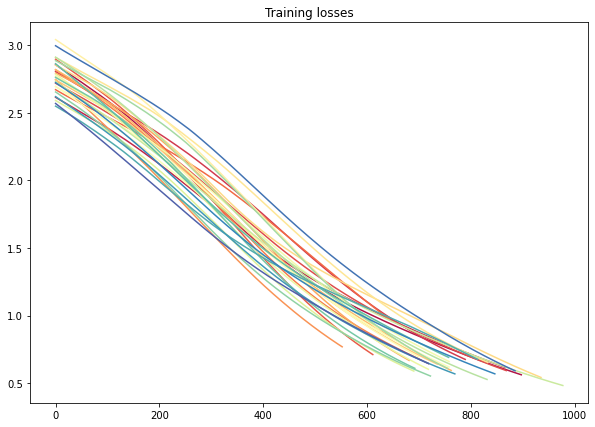

In [ ]:
import seaborn as sns
plt.figure(figsize =(10, 7))
with sns.color_palette("Spectral", n_colors=30):
    for i in range(30):
      plt.plot(m1['model{0}'.format(i)]['losses'])
plt.title("Training losses")
plt.show()

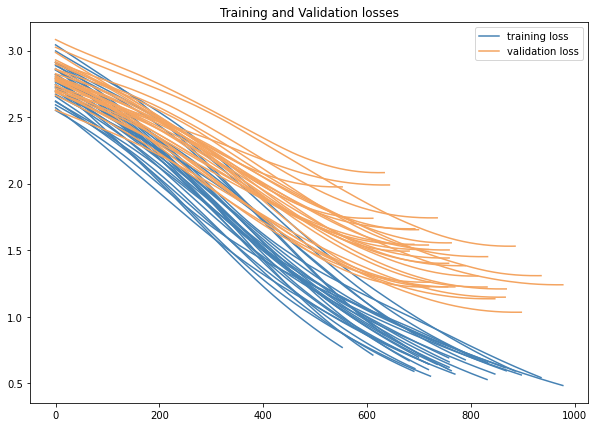

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
plt.figure(figsize =(10, 7))
with sns.color_palette(mcolors.CSS4_COLORS):
    for i in range(30):
      train_plot = plt.plot(m1['model{0}'.format(i)]['losses'],'steelblue', label=('' if i==0 else '_') + 'training loss')
    for i in range(30):
      val_plot = plt.plot(m1['model{0}'.format(i)]['val_losses'], 'sandybrown', label=('' if i==0 else '_') + 'validation loss')
plt.title("Training and Validation losses")
plt.legend()
plt.show()

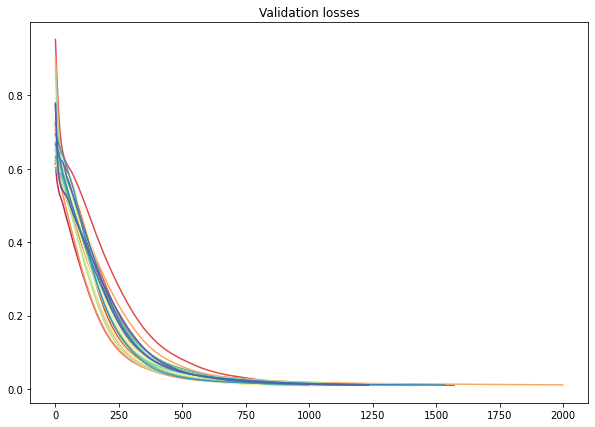

In [ ]:
import seaborn as sns
plt.figure(figsize =(10, 7))
with sns.color_palette("Spectral", n_colors=30):
    for i in range(30):
      plt.plot(m1['model{0}'.format(i)]['val_losses'])
plt.title("Validation losses")
plt.show()

In [ ]:
m1_test_acc = []
for i in range(30):
  m1_test_acc.append(m1['model{0}'.format(i)]['test_acc'])
m1_test_acc = pd.DataFrame(m1_test_acc)
m1_test_acc.describe()

0
count  30.000000
mean    0.636111
std     0.046338
min     0.583333
25%     0.583333
50%     0.666667
75%     0.666667
max     0.750000

In [ ]:
m1.keys()

dict_keys(['model0', 'model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'model14', 'model15', 'model16', 'model17', 'model18', 'model19', 'model20', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26', 'model27', 'model28', 'model29'])

[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 16, 17, 18] [7, 10, 11, 13, 19]
[2, 12, 15] [14] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 7, 9, 16, 17, 18] [10, 11, 13, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 13, 16, 17, 18] [7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 16, 17, 18] [7, 10, 11, 13, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 9, 13, 16, 17, 18] [6, 7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 9, 13, 16, 17, 18] [6, 7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 7, 9, 16, 17, 18] [10, 11, 13, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 13, 16, 17, 18] [7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 9, 13, 16, 17, 18] [6, 7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 13, 16, 17, 18] [7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 9, 13, 16, 17, 18] [6, 7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 16, 17, 18] [7, 10, 11, 13, 19]
[2, 12, 15] [14] [3, 8, 20, 21] [0, 5] [1, 4, 6, 7, 9, 16, 17, 18] [10, 11, 13, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 7, 9, 16, 17, 18] [10, 11, 13, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 16, 17, 18] [7, 10, 11, 13, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 9, 13, 16, 17, 18] [7, 10, 11, 19]
[2, 12, 14, 15] [] [0, 3, 5, 8, 20, 21] [] [1, 4, 6, 7, 9, 16, 17, 18] [10, 11, 13, 19]


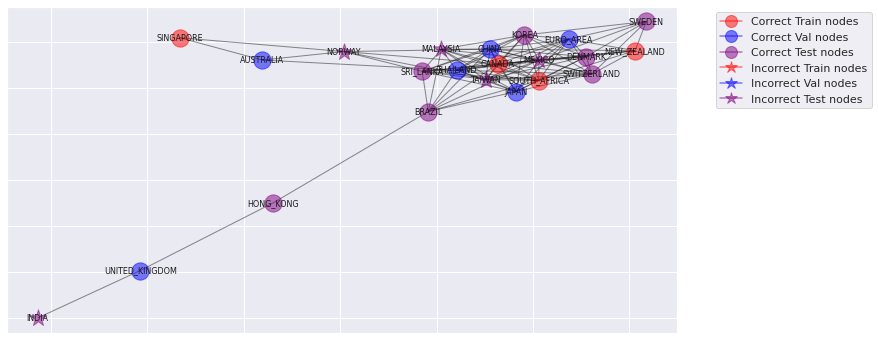

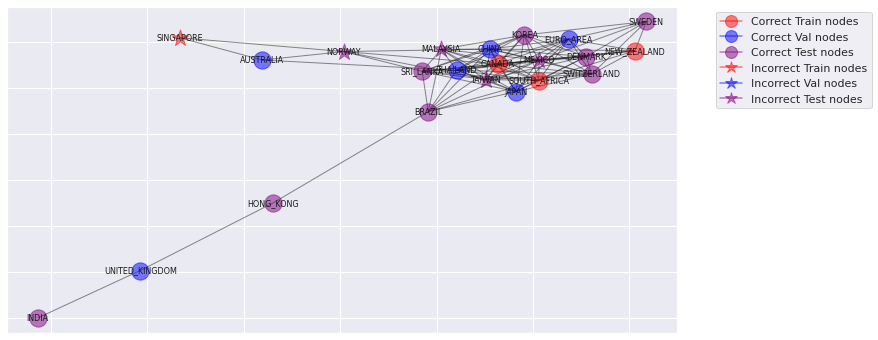

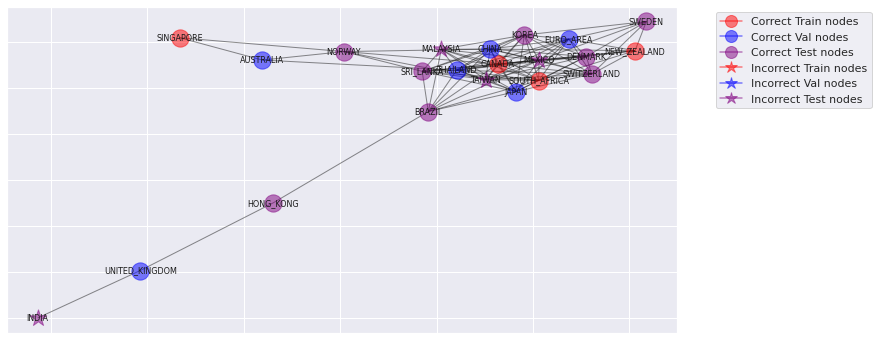

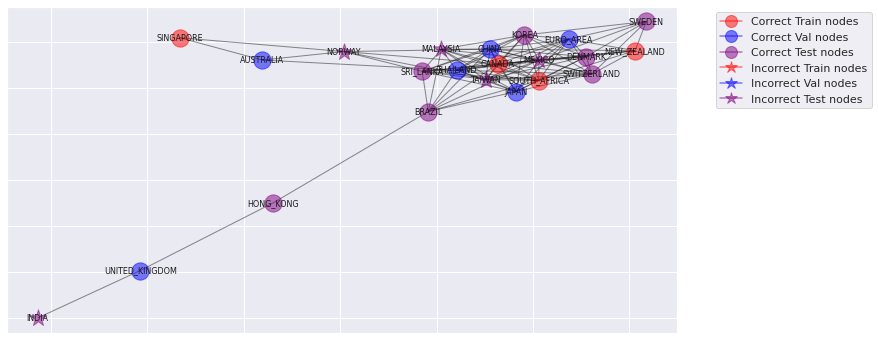

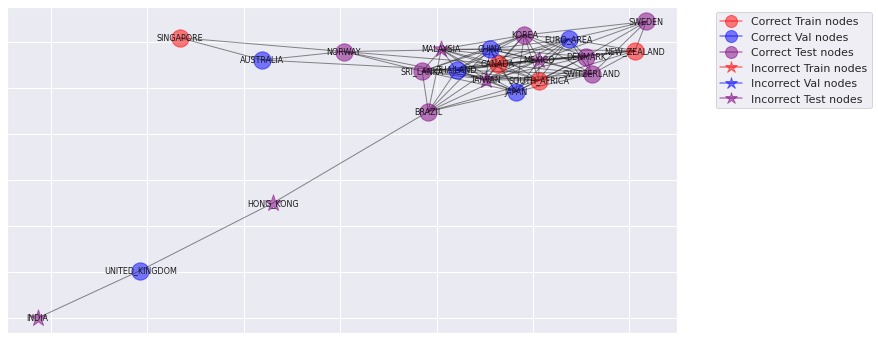

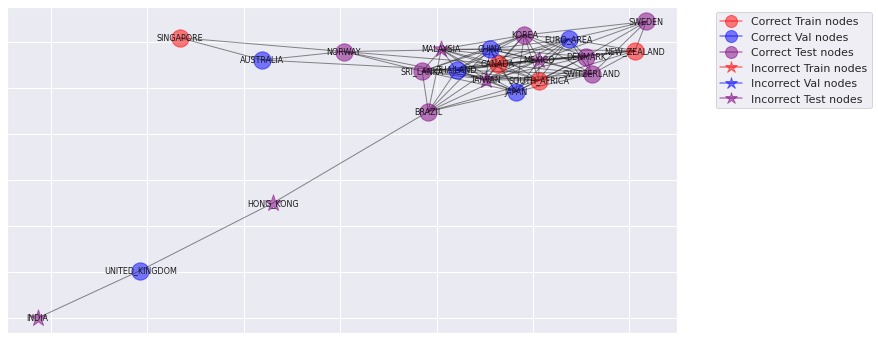

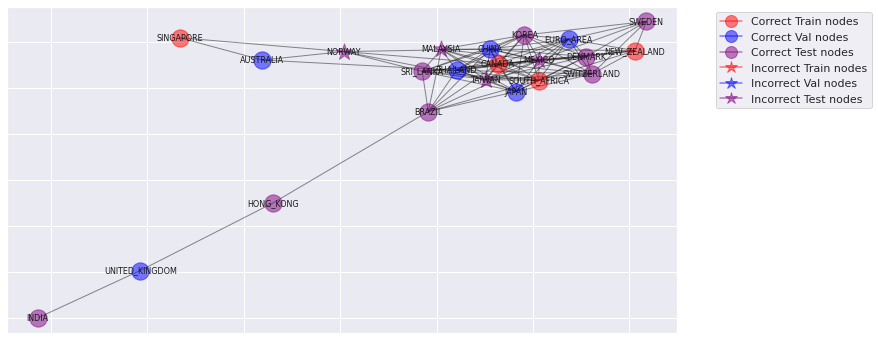

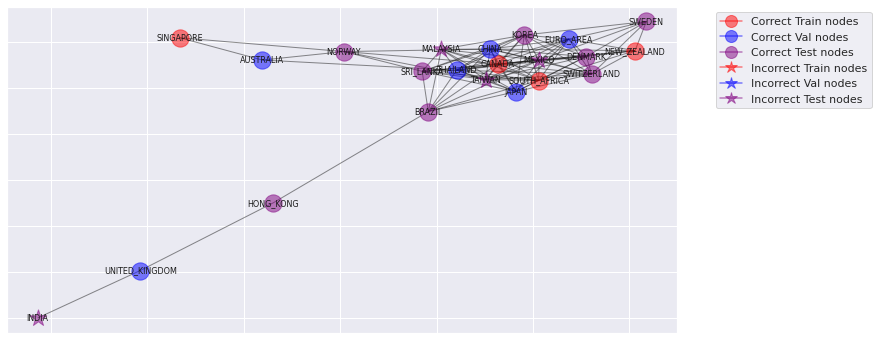

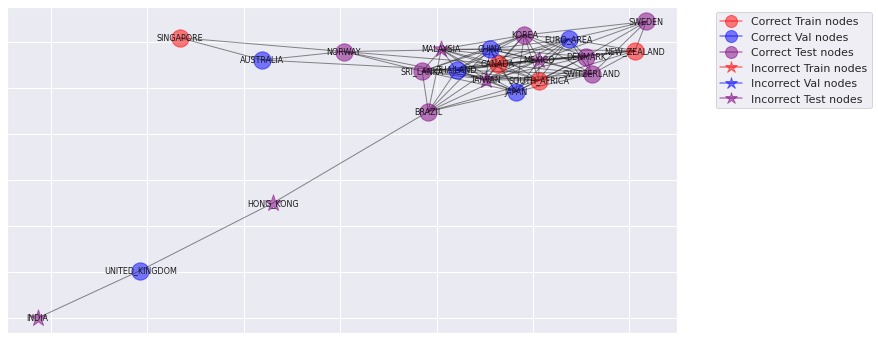

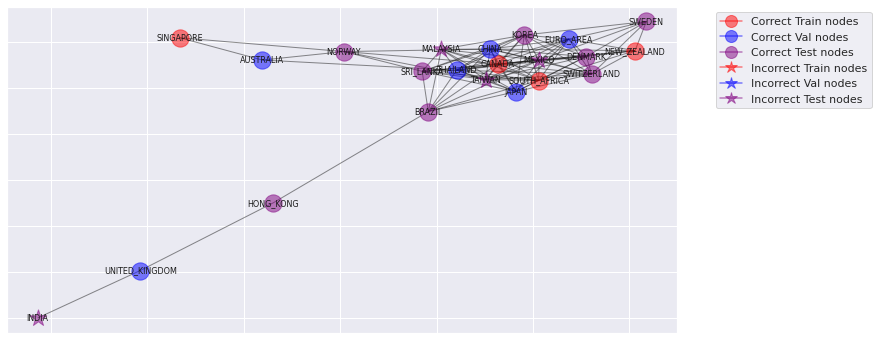

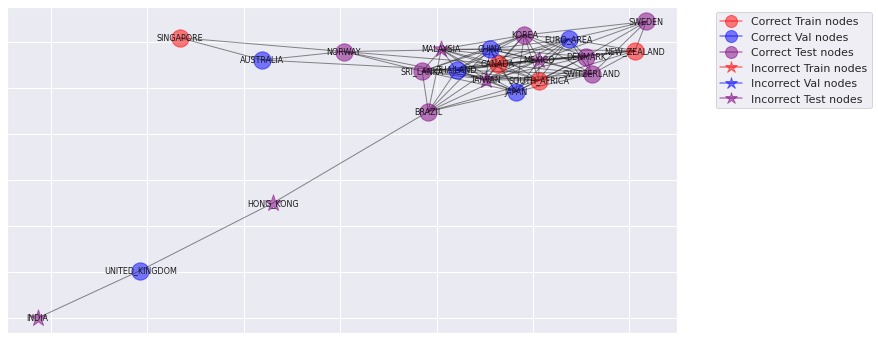

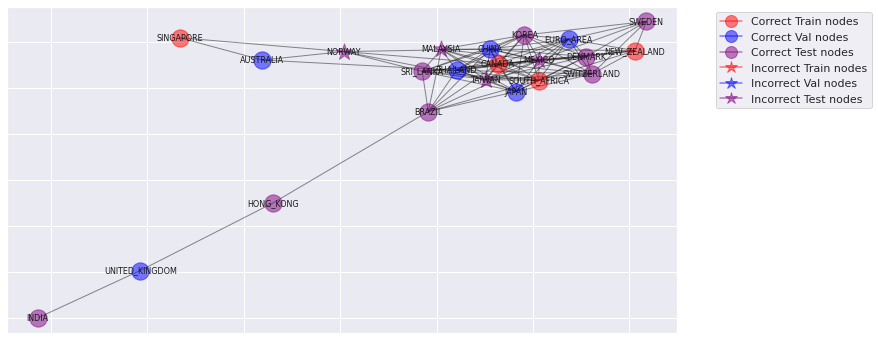

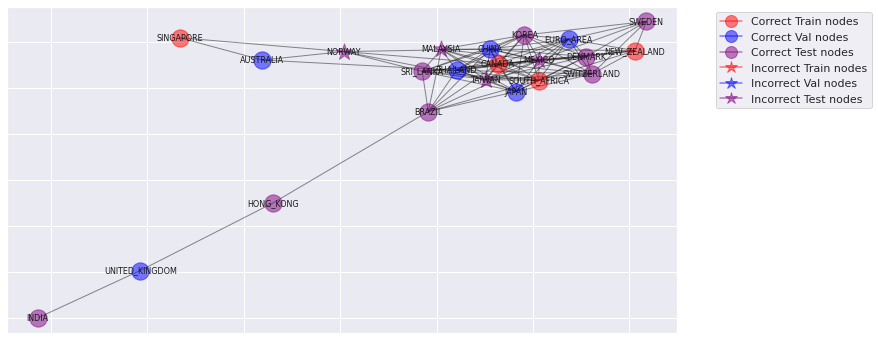

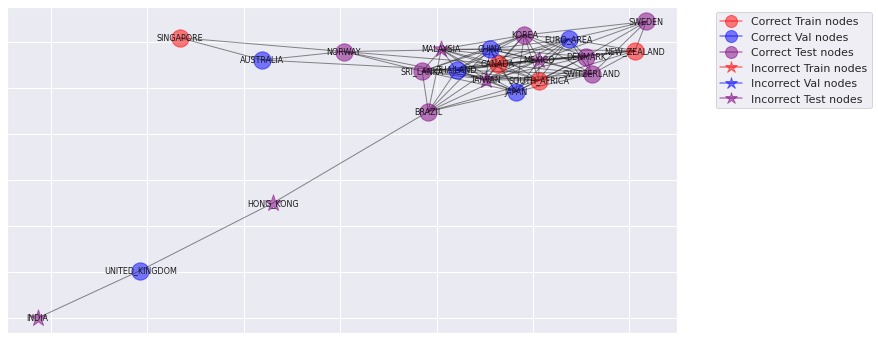

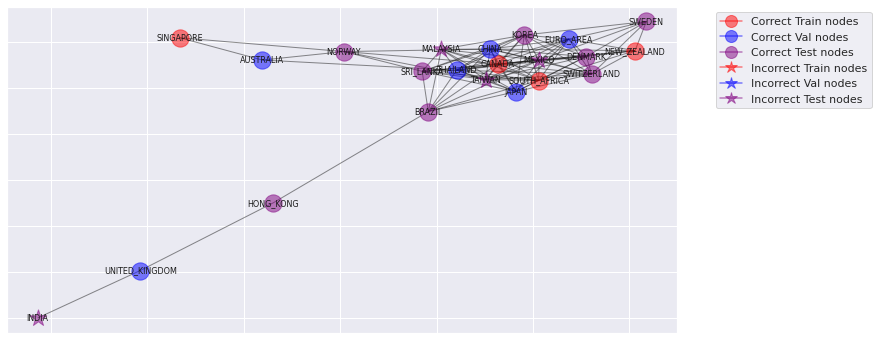

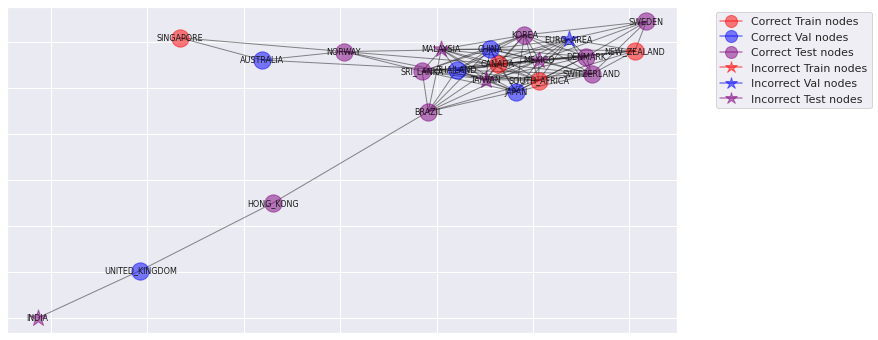

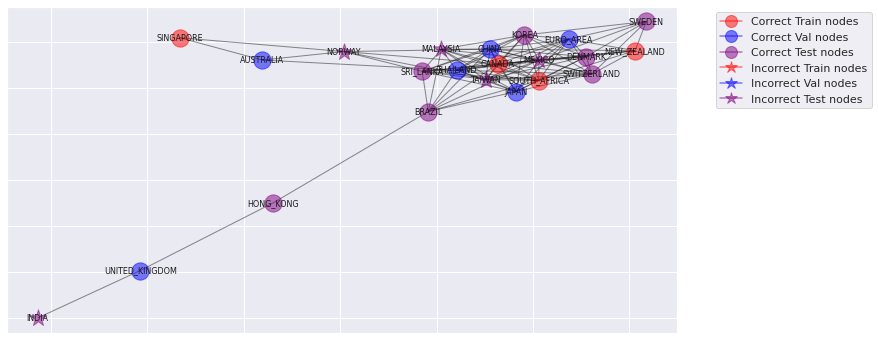

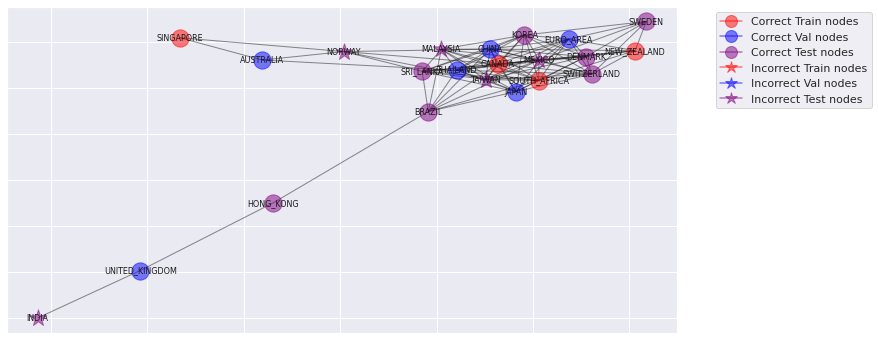

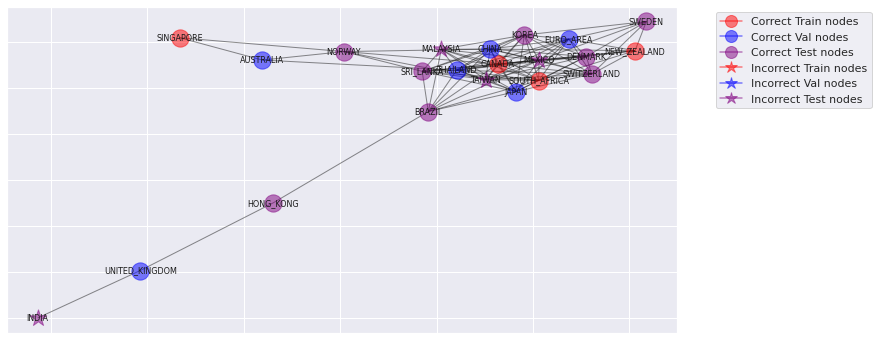

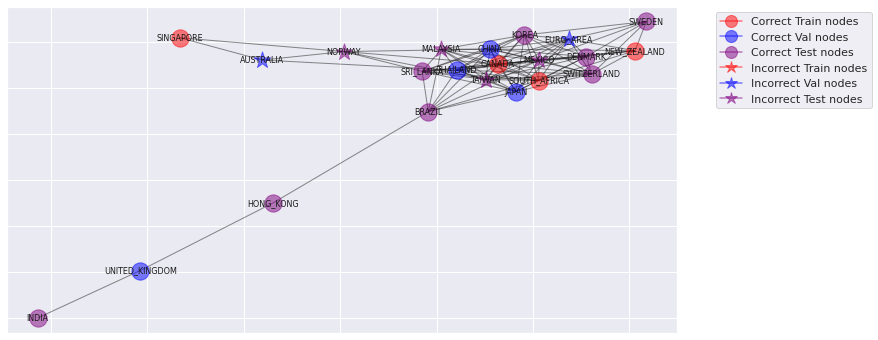

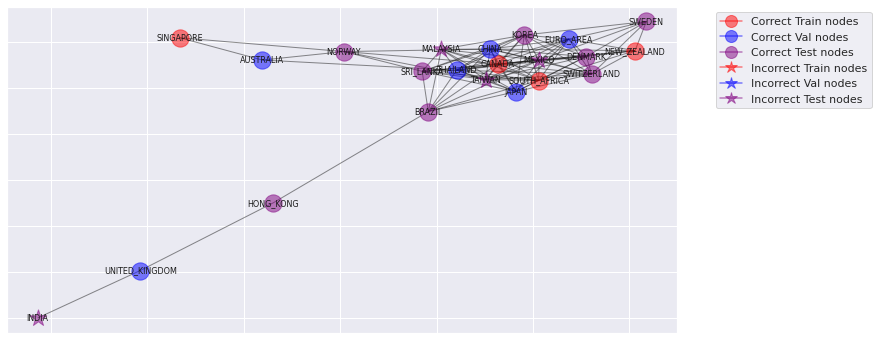

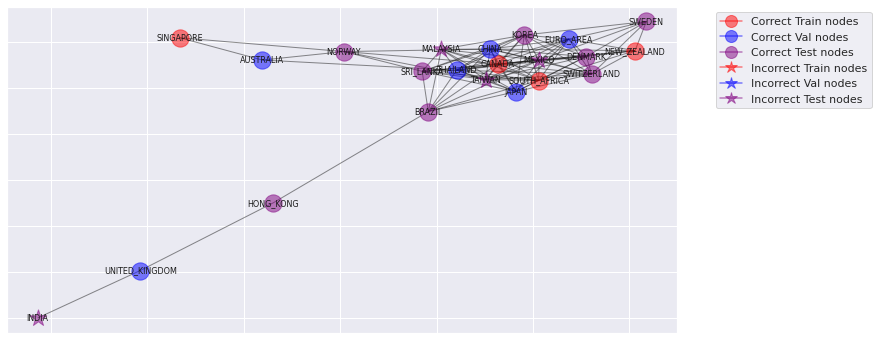

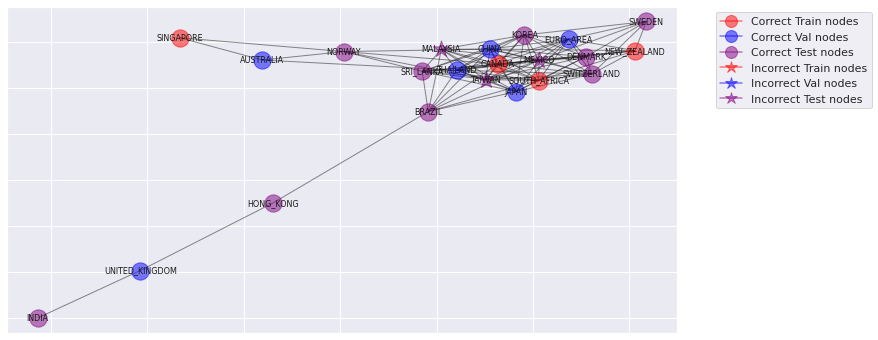

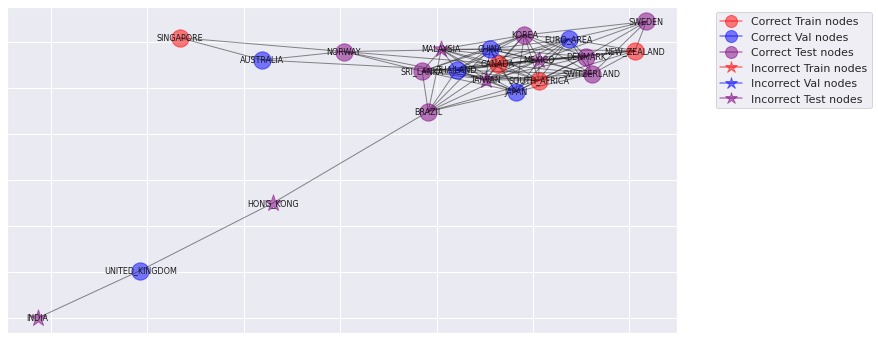

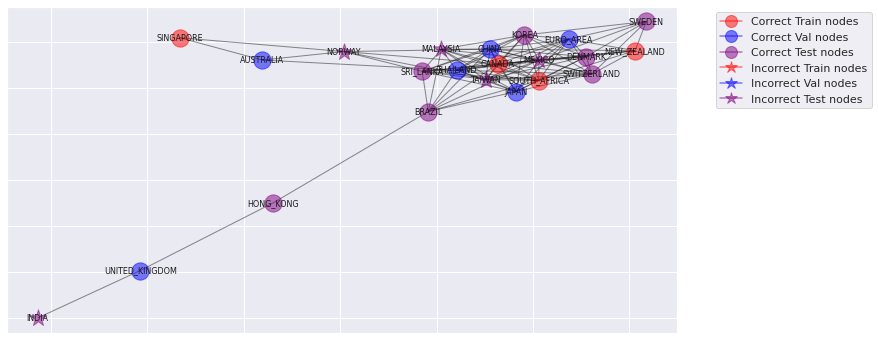

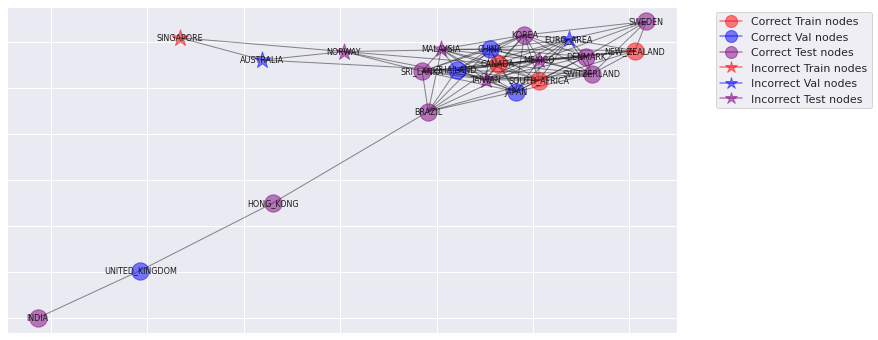

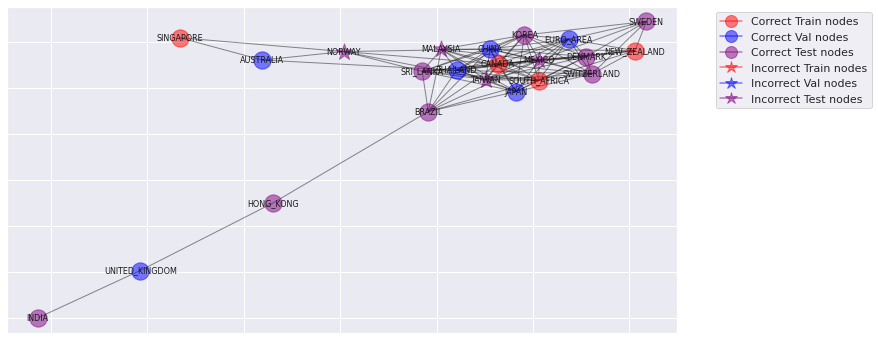

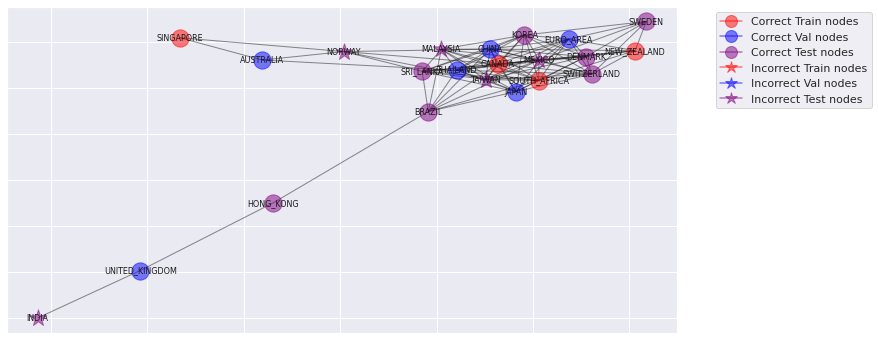

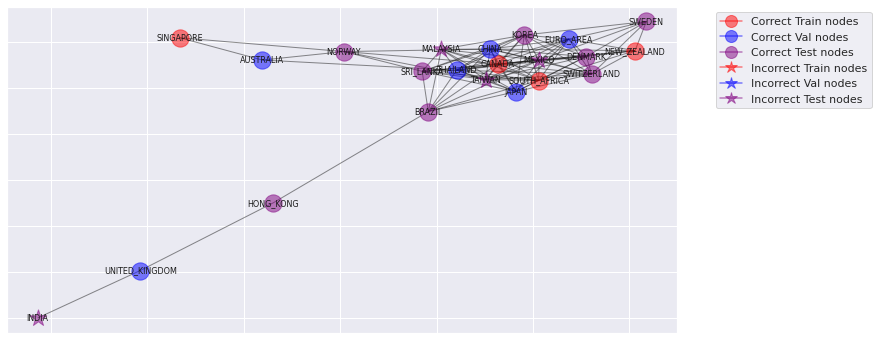

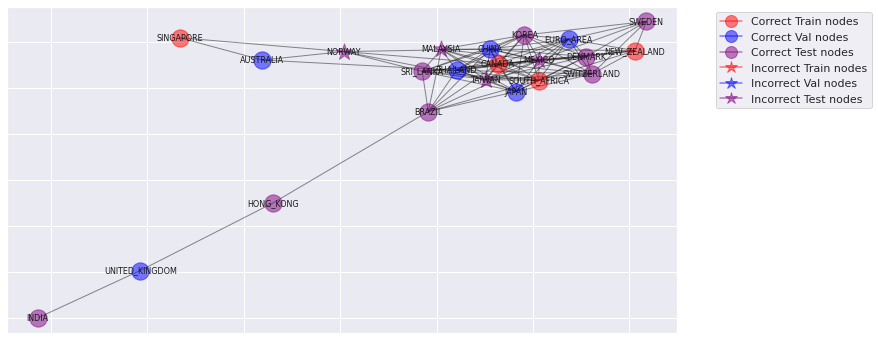

In [ ]:
for i in range(30):
  classification_label(train_node,m1['model{0}'.format(i)]['pred'][train_mask],targets[train_mask],val_node,m1['model{0}'.format(i)]['pred'][val_mask],targets[val_mask], 
                         test_node,m1['model{0}'.format(i)]['pred'][test_mask],targets[test_mask], G)